# MLP Autoencoder

In [1]:
import os
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import warnings
import time
import cPickle
warnings.filterwarnings("ignore", category=DeprecationWarning)  ## just for ignore DeprcationWarning message
print("Current version [%s]" %(tf.__version__))
print("Packages Loaded")

Current version [1.3.1]
Packages Loaded


### Configurations

In [2]:
# Dataset Configurations
tf.app.flags.DEFINE_integer('img_size', 32, """Image size of CIFAR-10 dataset""")
tf.app.flags.DEFINE_integer('img_num', 10000, """Number of images in one cifar batch""")
tf.app.flags.DEFINE_integer('batch_num', 5, """Number of cifar batches in dataset""")
tf.app.flags.DEFINE_string('train_dir', './../../../Dataset/cifar-10-batches-py', """Directory which contains the train data""")
tf.app.flags.DEFINE_string('test_dir', './../../../Dataset/cifar-10-batches-py', """Directory which contains the test data""")

# Network Configurations
tf.app.flags.DEFINE_integer('batch_size', 100, """Number of images to process in a batch""")
tf.app.flags.DEFINE_float('l1_ratio', 0.5, """Ratio of level1""")
tf.app.flags.DEFINE_float('l2_ratio', 0.5, """Ratio of level2""")

# Optimization Configurations
tf.app.flags.DEFINE_float('lr', 0.001, """Learning rate""")

# Training Configurations
tf.app.flags.DEFINE_integer('training_epochs', 2000, """Number of epochs to run""")
tf.app.flags.DEFINE_integer('display_step', 10, """Number of iterations to display training output""")
tf.app.flags.DEFINE_integer('save_step', 10, """Number of interations to save checkpoint""")
tf.app.flags.DEFINE_integer('save_max', 10, """Number of checkpoints to remain""")


# Save Configurations
tf.app.flags.DEFINE_string('nets', './nets', """Directory where to write the checkpoints""")
tf.app.flags.DEFINE_string('outputs', './outputs', """Directory where to save the output images""")
tf.app.flags.DEFINE_string('tboard', './tensorboard', """Directory where to save the tensorboard logs""")


FLAGS = tf.app.flags.FLAGS
print("FLAGS READY")

FLAGS READY


### GPU control

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

### Load Data

In [4]:
def unpickle(file):
    with tf.device('/CPU:0'):
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict

def read_cifar(file):
    with tf.device('/CPU:0'):
        _dic = unpickle(file)
        _img = _dic['data']/255.    # float type
        _label = _dic['labels']    # (10000, )

        _img_shape = np.shape(_img)
        _img = np.reshape(np.transpose(np.reshape(_img, (-1, 3, 32, 32)), (0,2,3,1)), _img_shape)
        return _img   # (10000, 3072)
   

### Generating random noise mask

In [5]:
def noise_mask(prob=0.5):
    with tf.device('/CPU:0'):
        mask = np.zeros([FLAGS.img_size, FLAGS.img_size, 3])
        rd = np.random.random()
        if rd > prob:
            # threshold of the size of masks
            uthd = FLAGS.img_size    
            lthd = 0     
            # mask size should be beween 14x14, 5x5
            while(uthd>14 or lthd<5):
                ver1 = np.random.random_integers(0, FLAGS.img_size-1, size= 2)   # vertex1
                ver2 = np.random.random_integers(0, FLAGS.img_size-1, size= 2)    # vertex2
                uthd = np.maximum(np.abs(ver1[0]-ver2[0]), np.abs(ver1[1]-ver2[1]))    # upperbound
                lthd = np.minimum(np.abs(ver1[0]-ver2[0]), np.abs(ver1[1]-ver2[1]))    # lowerbound
            xmin = np.minimum(ver1[0], ver2[0])    # left x value
            xmax = np.maximum(ver1[0], ver2[0])    # right x value
            ymin = np.minimum(ver1[1], ver2[1])    # top y value
            ymax = np.maximum(ver1[1], ver2[1])    # bottom y value
            noise = np.random.random((xmax-xmin+1, ymax-ymin+1, 3))    # random sample in [0,1]
            mask[xmin:xmax+1, ymin:ymax+1, :] = noise    # noise mask with location
            mask_meta = [xmin, xmax, ymin, ymax, noise, mask]
        mask = np.reshape(mask, [-1])
        return mask

def noise_batch(batch_num):
    with tf.device('/CPU:0'):
        # make random noise batch
        mask_batch = np.zeros([batch_num, FLAGS.img_size*FLAGS.img_size*3])
        for i in range(batch_num):
            mask_batch[i,:] = noise_mask()
        return mask_batch


def occl(target, disturb):
    with tf.device('/CPU:0'):
        # Occlusion generation
        mask = (disturb==0).astype(float)
        masked_target = np.multiply(target, mask)
        crpt = np.add(masked_target, disturb)
        return crpt

### Nested MLP

In [6]:
def _nested_mlp(l1, l2_s, l2, out_channel, name, stddev=0.1, is_init=False, is_last=False):
    l1_shape = l1.get_shape()[1]
    l2_shape = l2.get_shape()[1]
    l2_s_shape = l2_s.get_shape()[1]
    
    if is_init:
        # input is the input image
        with tf.device('/CPU:0'):
            with tf.variable_scope('level1'):
                with tf.variable_scope(name):
                    l1_weights = tf.get_variable('weights', 
                                                 [l1_shape, out_channel*FLAGS.l1_ratio], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l1_biases = tf.get_variable('biases', 
                                                [out_channel*FLAGS.l1_ratio],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
            with tf.variable_scope('level2'):
                with tf.variable_scope(name):
                    l2_s_weights = tf.get_variable('weights_shell', 
                                                 [l2_s_shape, out_channel*FLAGS.l2_ratio], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_s_biases = tf.get_variable('biases_shell', 
                                                [out_channel*FLAGS.l2_ratio],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
                    

        l1_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l1, l1_weights), l1_biases))
        l2_s_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l2_s, l2_s_weights), l2_s_biases))
        l2_mlp = tf.concat((l1_mlp, l2_s_mlp), 1)
    
    elif is_last:
        # output is the generated image
        with tf.device('/CPU:0'):
            with tf.variable_scope('level1'):
                with tf.variable_scope(name):
                    l1_weights = tf.get_variable('weights', 
                                                 [l1_shape, out_channel], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l1_biases = tf.get_variable('biases', 
                                                [out_channel],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
            with tf.variable_scope('level2'):
                with tf.variable_scope(name):
                    l2_s_weights = tf.get_variable('weights_shell', 
                                                 [l2_s_shape, out_channel], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_s_biases = tf.get_variable('biases_shell', 
                                                [out_channel],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_weights = tf.get_variable('weights', 
                                                 [l2_shape, out_channel], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_biases = tf.get_variable('biases', 
                                                [out_channel],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
                    

        l1_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l1, l1_weights), l1_biases))
        l2_s_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l2_s, l2_s_weights), l2_s_biases))
        l2_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l2, l2_weights), l2_biases))
                                 
    else:
        with tf.device('/CPU:0'):
            with tf.variable_scope('level1'):
                with tf.variable_scope(name):
                    l1_weights = tf.get_variable('weights', 
                                                 [l1_shape, out_channel*FLAGS.l1_ratio], 
                                                 tf.float32, 
                                                 initializer=tf.random_normal_initializer(stddev=stddev))
                    l1_biases = tf.get_variable('biases', 
                                                [out_channel*FLAGS.l1_ratio],
                                                tf.float32, 
                                                initializer=tf.random_normal_initializer(stddev=stddev))
            with tf.variable_scope('level2'):
                with tf.variable_scope(name):
                    l2_s_weights = tf.get_variable('weights_shell', 
                                                   [l2_s_shape, out_channel*FLAGS.l2_ratio], 
                                                   tf.float32, 
                                                   initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_s_biases = tf.get_variable('biases_shell', 
                                                  [out_channel*FLAGS.l2_ratio],
                                                  tf.float32, 
                                                  initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_weights_1 = tf.get_variable('weights_1', 
                                                   [l2_s_shape, out_channel*FLAGS.l1_ratio], 
                                                   tf.float32, 
                                                   initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_biases_1 = tf.get_variable('biases_1', 
                                                  [out_channel*FLAGS.l1_ratio],
                                                  tf.float32, 
                                                  initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_weights_2 = tf.get_variable('weights_2', 
                                                   [l1_shape, out_channel*FLAGS.l2_ratio], 
                                                   tf.float32, 
                                                   initializer=tf.random_normal_initializer(stddev=stddev))
                    l2_biases_2 = tf.get_variable('biases_2', 
                                                  [out_channel*FLAGS.l2_ratio],
                                                  tf.float32, 
                                                  initializer=tf.random_normal_initializer(stddev=stddev))

        l1_mlp_r = tf.add(tf.matmul(l1, l1_weights), l1_biases)
        l1_mlp = tf.nn.sigmoid(l1_mlp_r)
        
        l2_s_mlp = tf.nn.sigmoid(tf.add(tf.matmul(l2_s, l2_s_weights), l2_s_biases))
        
        l2_mlp_1_r = tf.add(tf.matmul(l2[:,l1_shape:l2_shape], l2_weights_1), l2_biases_1)
        l2_mlp_1 = tf.nn.sigmoid(tf.add(l1_mlp_r, l2_mlp_1_r))
        l2_mlp_2_r = tf.add(tf.matmul(l2[:,:l1_shape], l2_weights_2), l2_biases_2)
        l2_mlp_3_r = tf.add(tf.matmul(l2[:,l1_shape:l2_shape], l2_s_weights), l2_s_biases)
        l2_mlp_2 = tf.nn.sigmoid(tf.add(l2_mlp_2_r, l2_mlp_3_r))
        l2_mlp = tf.concat((l2_mlp_1, l2_mlp_2), 1)
        
        
    return l1_mlp, l2_s_mlp, l2_mlp

### Graph setup

In [7]:
# Network Topology
n_input = FLAGS.img_size*FLAGS.img_size*3
n_enc1 = 1024/2
n_enc2 = 512/2
n_enc3 = 256/2
n_dec1 = 512/2
n_dec2 = 1024/2
n_out = n_input

# Inputs and Outputs
ph_pure = tf.placeholder("float", [None, n_input])    # pure image --- core
ph_noise= tf.placeholder("float", [None, n_input])    # noise --- shell1
ph_crpt = tf.placeholder("float", [None, n_input])    # corrupted image   --- level2


# Model
def nested_ae_mlp(_X):
    l1_enc1, l2_s_enc1, l2_enc1 = _nested_mlp(_X, _X, _X, n_enc1, name='enc1', is_init=True)
    l1_enc2, l2_s_enc2, l2_enc2 = _nested_mlp(l1_enc1, l2_s_enc1, l2_enc1, n_enc2, name='enc2')
    l1_enc3, l2_s_enc3, l2_enc3 = _nested_mlp(l1_enc2, l2_s_enc2, l2_enc2, n_enc3, name='enc3')
    l1_dec1, l2_s_dec1, l2_dec1 = _nested_mlp(l1_enc3, l2_s_enc3, l2_enc3, n_dec1, name='dec1')
    l1_dec2, l2_s_dec2, l2_dec2 = _nested_mlp(l1_dec1, l2_s_dec1, l2_dec1, n_dec2, name='dec2')
    l1_out, l2_s_out, l2_out = _nested_mlp(l1_dec2, l2_s_dec2, l2_dec2, n_out, name='out',is_last=True)
    return l1_out, l2_s_out, l2_out

# Generation
core_gen, shell2_gen, full_gen = nested_ae_mlp(ph_crpt)   # [None, n_input]

# Loss & Optimizer
with tf.name_scope("loss") as scope:
    loss = tf.reduce_mean(tf.nn.l2_loss(full_gen-ph_crpt)) + tf.reduce_mean(tf.nn.l2_loss(core_gen-ph_pure))\
            + tf.reduce_mean(tf.nn.l2_loss(shell2_gen-ph_noise))
    _train_loss = tf.summary.scalar("train_loss", loss)
    _test_loss = tf.summary.scalar("test_loss", loss)

optm = tf.train.AdamOptimizer(learning_rate=FLAGS.lr).minimize(loss)


print("Graphs Ready")

Graphs Ready


### Initialize

In [8]:
merged = tf.summary.merge_all()
tensorboard_path = FLAGS.tboard
if not os.path.exists(tensorboard_path):
    os.makedirs(tensorboard_path)
writer = tf.summary.FileWriter(tensorboard_path)
init = tf.global_variables_initializer()

print("Initialize Ready")

Initialize Ready


### Data saving

In [9]:
outputdir = FLAGS.outputs
if not os.path.exists(outputdir+'/train'):
    os.makedirs(outputdir+'/train')

if not os.path.exists(outputdir+'/test'):
    os.makedirs(outputdir+'/test')
    
savedir = FLAGS.nets
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
saver = tf.train.Saver(max_to_keep=FLAGS.save_max)
print("Saver ready")

Saver ready


### Run

In [10]:
# Parameters
training_epochs = FLAGS.training_epochs
batch_num = FLAGS.batch_num
batch_size = FLAGS.batch_size
n_total_batch = int(FLAGS.img_num/batch_size)
display_step = FLAGS.display_step

# Plot
n_plot = 5    # plot 5 images
cifar10_train_img = read_cifar(FLAGS.test_dir+'/data_batch_1')     # (10000, 3072)
cifar10_test_img = read_cifar(FLAGS.test_dir+'/test_batch')     # (10000, 3072)
train_disp_idx = np.random.randint(FLAGS.img_num, size=n_plot)    # fixed during train time
train_gt_pure = np.copy(np.take(cifar10_train_img, train_disp_idx, axis=0))    # (n_plot, 3072) fixed
test_disp_idx = np.random.randint(FLAGS.img_num, size=n_plot)
test_gt_pure = np.copy(np.take(cifar10_test_img, test_disp_idx, axis=0))    # (n_plot, 3072) fixed

rand_train_idx = np.arange(FLAGS.img_num)    # for display loss
rand_test_idx = np.arange(FLAGS.img_num)    # for display loss
# Initialize
sess = tf.Session(config=config)
sess.run(init)

cifar10_test_img = read_cifar(FLAGS.test_dir+'/test_batch')     # (10000, 3072)

# Optimize
start_optm = time.time()
for epoch in range(training_epochs):
    for cifar_batch_idx in range(FLAGS.batch_num):
        with tf.device('/CPU:0'):
            start_epoch = time.time()
            cifar_batch_name = FLAGS.train_dir+'/data_batch_%d' %(cifar_batch_idx+1)
            cifar10_img = read_cifar(cifar_batch_name)     # (10000, 3072)
             
            np.random.seed(epoch)
            np.random.shuffle(rand_train_idx)
            np.random.shuffle(rand_test_idx)

        # Iteration
        for batch_idx in range(n_total_batch):
            with tf.device('/CPU:0'):
                batch_pure = np.take(cifar10_img, rand_train_idx[batch_size*batch_idx:batch_size*(batch_idx+1)], axis=0)   # pure image
                noise = noise_batch(batch_size)    # random noise
                batch_crpt = occl(batch_pure, noise)   # corrupted image 
                train_feeds = {ph_pure: batch_pure, ph_noise: noise, ph_crpt: batch_crpt}
            sess.run(optm, feed_dict=train_feeds)

        with tf.device('/CPU:0'):
#             train_pure = np.take(cifar10_img,[rand_train_idx], axis=0)    # pure image
#             train_noise = noise_batch(batch_size)    # random noise
#             train_crpt = occl(train_pure,train_noise)   # corrupted image
#             train_feeds = {ph_pure: train_pure, ph_noise: train_noise, ph_crpt: train_crpt}
            train_loss, tb_train_loss = sess.run([loss,_train_loss], feed_dict=train_feeds)

            test_pure = np.take(cifar10_test_img,rand_test_idx[:batch_size], axis=0)    # pure image
            test_noise = noise_batch(batch_size)    # random noise
            test_crpt = occl(test_pure,test_noise)   # corrupted image
            test_feeds = {ph_pure: test_pure, ph_noise: test_noise, ph_crpt: test_crpt}
            test_loss, tb_test_loss = sess.run([loss,_test_loss], feed_dict=test_feeds)

        writer.add_summary(tb_train_loss, epoch)
        writer.add_summary(tb_test_loss, epoch)
        
        epoch_time = time.time() - start_epoch
        current_time = time.time() - start_optm
        print("Epoch : %03d/%03d data_batch_%d,  Train_loss : %.4f  Test_loss : %.4f, Time/batch_file : %.4f, Training time: %.4f" 
              % (epoch+1, training_epochs, cifar_batch_idx+1, train_loss, test_loss, epoch_time, current_time))   
        
    # Display
    if (epoch+1) % display_step == 0:
        # train_gt_pure  # pure image
        train_gt_noise = noise_batch(n_plot)    # random noise
        train_gt_crpt = occl(train_gt_pure,train_gt_noise)   # corrupted image
        train_gt_feeds = {ph_pure: train_gt_pure, ph_noise: train_gt_noise, ph_crpt: train_gt_crpt}
        
        # test_gt_pure   # pure image
        test_gt_noise = noise_batch(n_plot)    # random noise
        test_gt_crpt = occl(test_gt_pure,test_gt_noise)   # corrupted image
        test_gt_feeds = {ph_pure: test_gt_pure, ph_noise: test_gt_noise, ph_crpt: test_gt_crpt}
        
        # generated images
        train_gen_pure, train_gen_noise, train_gen_crpt = sess.run([core_gen, shell2_gen, full_gen], \
                                        feed_dict=train_gt_feeds)  # 3072-d vector
        test_gen_pure, test_gen_noise, test_gen_crpt = sess.run([core_gen, shell2_gen, full_gen], \
                                        feed_dict=test_gt_feeds)  # 3072-d vector
        
        # plotting results from training data
        with tf.device('/CPU:0'):
            fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,2*n_plot))   # displaying 4*n_plot images
            plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
            for j in range(n_plot):
                train_disp_gt_crpt = np.reshape(train_gt_crpt[j], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
                axes[0, j].imshow(train_disp_gt_crpt, cmap='gray')   
                axes[0, j].set(ylabel='gt_crpt')
                axes[0, j].label_outer()

                train_disp_gen_pure = np.reshape(train_gen_pure[j], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
                axes[1, j].imshow(train_disp_gen_pure, cmap='gray')   
                axes[1, j].set(ylabel='gen_pure')
                axes[1, j].label_outer()

                train_disp_gen_noise = np.reshape(train_gen_noise[j], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
                axes[2, j].imshow(train_disp_gen_noise, cmap='gray')   
                axes[2, j].set(ylabel='gen_noise')
                axes[2, j].label_outer()

                train_disp_gen_crpt = np.reshape(train_gen_crpt[j], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
                axes[3, j].imshow(train_disp_gen_crpt, cmap='gray')   
                axes[3, j].set(ylabel='gen_crpt')
                axes[3, j].label_outer()

            plt.savefig(outputdir+'/train/epoch %03d' %(epoch+1))    
            plt.close(fig)

            # plotting results from testing data
            fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,2*n_plot))   # displaying 4*n_plot images
            plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
            for k in range(n_plot):
                test_disp_gt_crpt = np.reshape(test_gt_crpt[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
                axes[0, k].imshow(test_disp_gt_crpt)   
                axes[0, k].set(ylabel='gt_crpt')
                axes[0, k].label_outer()

                test_disp_gen_pure = np.reshape(test_gen_pure[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
                axes[1, k].imshow(test_disp_gen_pure)   
                axes[1, k].set(ylabel='gen_pure')
                axes[1, k].label_outer()           

                test_disp_gen_noise = np.reshape(test_gen_noise[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
                axes[2, k].imshow(test_disp_gen_noise)   
                axes[2, k].set(ylabel='gen_noise')
                axes[2, k].label_outer()

                test_disp_gen_crpt = np.reshape(test_gen_crpt[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
                axes[3, k].imshow(test_disp_gen_crpt)   
                axes[3, k].set(ylabel='gen_crpt')
                axes[3, k].label_outer()


            plt.savefig(outputdir+'/test/epoch %03d' %(epoch+1))    
            plt.close(fig)

            # Save
            if (epoch+1) % FLAGS.save_step ==0:
                savename = savedir+"/net-"+str(epoch+1)+".ckpt"
                saver.save(sess, savename)
                print("[%s] SAVED" % (savename))

print("Optimization Finished")

Epoch : 001/2000 data_batch_1,  Train_loss : 21205.0879  Test_loss : 22354.9805, Time/batch_file : 2.5858, Training time: 2.5871
Epoch : 001/2000 data_batch_2,  Train_loss : 17368.3965  Test_loss : 16097.6875, Time/batch_file : 2.3333, Training time: 4.9208
Epoch : 001/2000 data_batch_3,  Train_loss : 15704.2314  Test_loss : 15438.1875, Time/batch_file : 2.3098, Training time: 7.2308
Epoch : 001/2000 data_batch_4,  Train_loss : 15436.0898  Test_loss : 14834.8008, Time/batch_file : 2.3062, Training time: 9.5372
Epoch : 001/2000 data_batch_5,  Train_loss : 14354.7988  Test_loss : 13697.2959, Time/batch_file : 2.3017, Training time: 11.8391
Epoch : 002/2000 data_batch_1,  Train_loss : 13955.6797  Test_loss : 13888.5264, Time/batch_file : 2.3487, Training time: 14.1880
Epoch : 002/2000 data_batch_2,  Train_loss : 15542.4014  Test_loss : 13841.1406, Time/batch_file : 2.3008, Training time: 16.4889
Epoch : 002/2000 data_batch_3,  Train_loss : 14438.7930  Test_loss : 13955.3096, Time/batch_fi

Epoch : 013/2000 data_batch_4,  Train_loss : 11613.1533  Test_loss : 11011.9209, Time/batch_file : 2.3042, Training time: 149.5164
Epoch : 013/2000 data_batch_5,  Train_loss : 11137.5664  Test_loss : 11483.2031, Time/batch_file : 2.3092, Training time: 151.8258
Epoch : 014/2000 data_batch_1,  Train_loss : 11766.4541  Test_loss : 11567.7764, Time/batch_file : 2.2990, Training time: 154.1250
Epoch : 014/2000 data_batch_2,  Train_loss : 10795.5762  Test_loss : 11054.9805, Time/batch_file : 2.3061, Training time: 156.4314
Epoch : 014/2000 data_batch_3,  Train_loss : 12084.2275  Test_loss : 11706.8340, Time/batch_file : 2.2970, Training time: 158.7286
Epoch : 014/2000 data_batch_4,  Train_loss : 11343.2852  Test_loss : 11160.5869, Time/batch_file : 2.3103, Training time: 161.0392
Epoch : 014/2000 data_batch_5,  Train_loss : 10837.4111  Test_loss : 11144.8691, Time/batch_file : 2.3052, Training time: 163.3447
Epoch : 015/2000 data_batch_1,  Train_loss : 11133.9277  Test_loss : 10758.7539, Ti

Epoch : 026/2000 data_batch_2,  Train_loss : 10944.3818  Test_loss : 10832.9043, Time/batch_file : 2.3193, Training time: 295.7430
Epoch : 026/2000 data_batch_3,  Train_loss : 11192.3828  Test_loss : 10285.2686, Time/batch_file : 2.2996, Training time: 298.0427
Epoch : 026/2000 data_batch_4,  Train_loss : 10576.8545  Test_loss : 10679.7803, Time/batch_file : 2.3065, Training time: 300.3494
Epoch : 026/2000 data_batch_5,  Train_loss : 11102.4209  Test_loss : 9872.4111, Time/batch_file : 2.3006, Training time: 302.6503
Epoch : 027/2000 data_batch_1,  Train_loss : 10851.2393  Test_loss : 9249.7910, Time/batch_file : 2.2900, Training time: 304.9405
Epoch : 027/2000 data_batch_2,  Train_loss : 10231.7412  Test_loss : 9135.9941, Time/batch_file : 2.2996, Training time: 307.2403
Epoch : 027/2000 data_batch_3,  Train_loss : 10068.1523  Test_loss : 9635.5381, Time/batch_file : 2.3121, Training time: 309.5527
Epoch : 027/2000 data_batch_4,  Train_loss : 9649.2734  Test_loss : 9473.8145, Time/bat

Epoch : 039/2000 data_batch_1,  Train_loss : 9104.7178  Test_loss : 9022.2314, Time/batch_file : 2.3157, Training time: 443.7875
Epoch : 039/2000 data_batch_2,  Train_loss : 9252.9277  Test_loss : 9296.6328, Time/batch_file : 2.2979, Training time: 446.0856
Epoch : 039/2000 data_batch_3,  Train_loss : 9327.5166  Test_loss : 9239.6758, Time/batch_file : 2.3025, Training time: 448.3883
Epoch : 039/2000 data_batch_4,  Train_loss : 9314.0664  Test_loss : 9225.2832, Time/batch_file : 2.2881, Training time: 450.6766
Epoch : 039/2000 data_batch_5,  Train_loss : 8821.0713  Test_loss : 8966.1172, Time/batch_file : 2.3196, Training time: 452.9964
Epoch : 040/2000 data_batch_1,  Train_loss : 9303.9902  Test_loss : 9836.0869, Time/batch_file : 2.2894, Training time: 455.2859
Epoch : 040/2000 data_batch_2,  Train_loss : 8798.0117  Test_loss : 9587.9521, Time/batch_file : 2.2839, Training time: 457.5701
Epoch : 040/2000 data_batch_3,  Train_loss : 8145.3350  Test_loss : 9071.5791, Time/batch_file : 

Epoch : 051/2000 data_batch_5,  Train_loss : 8636.2285  Test_loss : 9114.7803, Time/batch_file : 2.2863, Training time: 593.1173
Epoch : 052/2000 data_batch_1,  Train_loss : 8729.6221  Test_loss : 8682.5967, Time/batch_file : 2.2813, Training time: 595.3988
Epoch : 052/2000 data_batch_2,  Train_loss : 8680.7314  Test_loss : 8199.1230, Time/batch_file : 2.2788, Training time: 597.6778
Epoch : 052/2000 data_batch_3,  Train_loss : 8061.9731  Test_loss : 8184.8955, Time/batch_file : 2.2844, Training time: 599.9625
Epoch : 052/2000 data_batch_4,  Train_loss : 8258.0098  Test_loss : 8553.0078, Time/batch_file : 2.2679, Training time: 602.2307
Epoch : 052/2000 data_batch_5,  Train_loss : 8430.6738  Test_loss : 8576.7871, Time/batch_file : 2.2916, Training time: 604.5224
Epoch : 053/2000 data_batch_1,  Train_loss : 9244.1348  Test_loss : 8723.6348, Time/batch_file : 2.2758, Training time: 606.7984
Epoch : 053/2000 data_batch_2,  Train_loss : 8628.3379  Test_loss : 9205.1074, Time/batch_file : 

Epoch : 064/2000 data_batch_4,  Train_loss : 7931.7617  Test_loss : 8296.9258, Time/batch_file : 2.2960, Training time: 740.8755
Epoch : 064/2000 data_batch_5,  Train_loss : 7852.0283  Test_loss : 7972.7246, Time/batch_file : 2.3134, Training time: 743.1890
Epoch : 065/2000 data_batch_1,  Train_loss : 8803.5596  Test_loss : 8882.4590, Time/batch_file : 2.3011, Training time: 745.4903
Epoch : 065/2000 data_batch_2,  Train_loss : 8743.7188  Test_loss : 9116.5674, Time/batch_file : 2.3002, Training time: 747.7907
Epoch : 065/2000 data_batch_3,  Train_loss : 9063.9795  Test_loss : 8085.8076, Time/batch_file : 2.2964, Training time: 750.0874
Epoch : 065/2000 data_batch_4,  Train_loss : 8999.7236  Test_loss : 8085.9551, Time/batch_file : 2.2834, Training time: 752.3711
Epoch : 065/2000 data_batch_5,  Train_loss : 8518.1309  Test_loss : 8698.3848, Time/batch_file : 2.3000, Training time: 754.6713
Epoch : 066/2000 data_batch_1,  Train_loss : 7985.3975  Test_loss : 8642.4434, Time/batch_file : 

Epoch : 077/2000 data_batch_3,  Train_loss : 7978.9663  Test_loss : 7937.0518, Time/batch_file : 2.2734, Training time: 888.8100
Epoch : 077/2000 data_batch_4,  Train_loss : 8264.9316  Test_loss : 8591.3770, Time/batch_file : 2.2680, Training time: 891.0782
Epoch : 077/2000 data_batch_5,  Train_loss : 8250.3428  Test_loss : 9008.2373, Time/batch_file : 2.2865, Training time: 893.3649
Epoch : 078/2000 data_batch_1,  Train_loss : 8222.3691  Test_loss : 8873.6729, Time/batch_file : 2.3011, Training time: 895.6662
Epoch : 078/2000 data_batch_2,  Train_loss : 8558.4180  Test_loss : 8817.1777, Time/batch_file : 2.2985, Training time: 897.9650
Epoch : 078/2000 data_batch_3,  Train_loss : 8293.1562  Test_loss : 8571.1348, Time/batch_file : 2.2912, Training time: 900.2562
Epoch : 078/2000 data_batch_4,  Train_loss : 8521.3867  Test_loss : 8851.1855, Time/batch_file : 2.3020, Training time: 902.5584
Epoch : 078/2000 data_batch_5,  Train_loss : 8593.1201  Test_loss : 8584.7715, Time/batch_file : 

Epoch : 090/2000 data_batch_2,  Train_loss : 8149.3428  Test_loss : 8361.7910, Time/batch_file : 2.2977, Training time: 1036.8533
Epoch : 090/2000 data_batch_3,  Train_loss : 8369.1680  Test_loss : 8841.1289, Time/batch_file : 2.2805, Training time: 1039.1340
Epoch : 090/2000 data_batch_4,  Train_loss : 8426.7793  Test_loss : 8303.1230, Time/batch_file : 2.2887, Training time: 1041.4229
Epoch : 090/2000 data_batch_5,  Train_loss : 8335.7412  Test_loss : 8696.6113, Time/batch_file : 2.2772, Training time: 1043.7004
[./nets/net-90.ckpt] SAVED
Epoch : 091/2000 data_batch_1,  Train_loss : 7691.1953  Test_loss : 7771.2817, Time/batch_file : 2.2982, Training time: 1047.5415
Epoch : 091/2000 data_batch_2,  Train_loss : 7295.4946  Test_loss : 7584.1372, Time/batch_file : 2.2836, Training time: 1049.8253
Epoch : 091/2000 data_batch_3,  Train_loss : 7636.5239  Test_loss : 7453.6108, Time/batch_file : 2.2930, Training time: 1052.1185
Epoch : 091/2000 data_batch_4,  Train_loss : 7063.4175  Test_lo

Epoch : 102/2000 data_batch_5,  Train_loss : 7506.0737  Test_loss : 7446.5273, Time/batch_file : 2.2991, Training time: 1184.8502
Epoch : 103/2000 data_batch_1,  Train_loss : 7481.0122  Test_loss : 8101.4238, Time/batch_file : 2.3110, Training time: 1187.1614
Epoch : 103/2000 data_batch_2,  Train_loss : 7647.5566  Test_loss : 7542.6499, Time/batch_file : 2.2990, Training time: 1189.4606
Epoch : 103/2000 data_batch_3,  Train_loss : 7901.0947  Test_loss : 8414.8984, Time/batch_file : 2.3133, Training time: 1191.7740
Epoch : 103/2000 data_batch_4,  Train_loss : 7750.7393  Test_loss : 8232.3379, Time/batch_file : 2.3077, Training time: 1194.0819
Epoch : 103/2000 data_batch_5,  Train_loss : 7648.2412  Test_loss : 8588.8301, Time/batch_file : 2.3300, Training time: 1196.4121
Epoch : 104/2000 data_batch_1,  Train_loss : 7700.8818  Test_loss : 7913.5146, Time/batch_file : 2.3252, Training time: 1198.7375
Epoch : 104/2000 data_batch_2,  Train_loss : 7190.2935  Test_loss : 7339.5156, Time/batch_

Epoch : 115/2000 data_batch_3,  Train_loss : 7223.1011  Test_loss : 7629.1387, Time/batch_file : 2.3301, Training time: 1332.0096
Epoch : 115/2000 data_batch_4,  Train_loss : 7414.5981  Test_loss : 7670.3340, Time/batch_file : 2.3282, Training time: 1334.3380
Epoch : 115/2000 data_batch_5,  Train_loss : 7521.0698  Test_loss : 7691.5986, Time/batch_file : 2.2978, Training time: 1336.6360
Epoch : 116/2000 data_batch_1,  Train_loss : 7524.5625  Test_loss : 7482.3672, Time/batch_file : 2.2904, Training time: 1338.9267
Epoch : 116/2000 data_batch_2,  Train_loss : 7792.2168  Test_loss : 7839.4062, Time/batch_file : 2.3236, Training time: 1341.2505
Epoch : 116/2000 data_batch_3,  Train_loss : 7522.3145  Test_loss : 7688.4941, Time/batch_file : 2.2899, Training time: 1343.5407
Epoch : 116/2000 data_batch_4,  Train_loss : 7370.1270  Test_loss : 7645.1973, Time/batch_file : 2.3337, Training time: 1345.8747
Epoch : 116/2000 data_batch_5,  Train_loss : 7525.6978  Test_loss : 7958.7334, Time/batch_

Epoch : 128/2000 data_batch_1,  Train_loss : 7363.1973  Test_loss : 7395.8066, Time/batch_file : 2.3076, Training time: 1479.2741
Epoch : 128/2000 data_batch_2,  Train_loss : 7563.9053  Test_loss : 7076.6416, Time/batch_file : 2.3453, Training time: 1481.6197
Epoch : 128/2000 data_batch_3,  Train_loss : 7306.8130  Test_loss : 7409.6309, Time/batch_file : 2.2904, Training time: 1483.9103
Epoch : 128/2000 data_batch_4,  Train_loss : 7128.2334  Test_loss : 7411.8604, Time/batch_file : 2.3201, Training time: 1486.2307
Epoch : 128/2000 data_batch_5,  Train_loss : 7158.9502  Test_loss : 6983.0264, Time/batch_file : 2.3125, Training time: 1488.5433
Epoch : 129/2000 data_batch_1,  Train_loss : 7180.8364  Test_loss : 6957.2441, Time/batch_file : 2.3076, Training time: 1490.8512
Epoch : 129/2000 data_batch_2,  Train_loss : 6857.6758  Test_loss : 7189.4805, Time/batch_file : 2.3642, Training time: 1493.2157
Epoch : 129/2000 data_batch_3,  Train_loss : 7107.0303  Test_loss : 7403.6318, Time/batch_

Epoch : 140/2000 data_batch_4,  Train_loss : 6846.7197  Test_loss : 7187.7271, Time/batch_file : 2.2969, Training time: 1626.1503
Epoch : 140/2000 data_batch_5,  Train_loss : 7240.1519  Test_loss : 6896.4551, Time/batch_file : 2.2995, Training time: 1628.4499
[./nets/net-140.ckpt] SAVED
Epoch : 141/2000 data_batch_1,  Train_loss : 6854.3096  Test_loss : 7228.0742, Time/batch_file : 2.3414, Training time: 1632.4991
Epoch : 141/2000 data_batch_2,  Train_loss : 6151.1445  Test_loss : 7347.7266, Time/batch_file : 2.2982, Training time: 1634.7976
Epoch : 141/2000 data_batch_3,  Train_loss : 6537.1816  Test_loss : 7310.1191, Time/batch_file : 2.3220, Training time: 1637.1198
Epoch : 141/2000 data_batch_4,  Train_loss : 6239.5791  Test_loss : 6916.5830, Time/batch_file : 2.3096, Training time: 1639.4297
Epoch : 141/2000 data_batch_5,  Train_loss : 6552.6558  Test_loss : 7050.7876, Time/batch_file : 2.3207, Training time: 1641.7506
Epoch : 142/2000 data_batch_1,  Train_loss : 6734.6841  Test_l

Epoch : 153/2000 data_batch_2,  Train_loss : 6570.0762  Test_loss : 7634.4189, Time/batch_file : 2.2999, Training time: 1774.3044
Epoch : 153/2000 data_batch_3,  Train_loss : 6589.9146  Test_loss : 7726.4990, Time/batch_file : 2.2937, Training time: 1776.5984
Epoch : 153/2000 data_batch_4,  Train_loss : 6582.5869  Test_loss : 7274.8447, Time/batch_file : 2.3093, Training time: 1778.9079
Epoch : 153/2000 data_batch_5,  Train_loss : 6885.8691  Test_loss : 7414.4736, Time/batch_file : 2.2876, Training time: 1781.1956
Epoch : 154/2000 data_batch_1,  Train_loss : 6767.8457  Test_loss : 7123.1045, Time/batch_file : 2.3072, Training time: 1783.5030
Epoch : 154/2000 data_batch_2,  Train_loss : 6976.9585  Test_loss : 7192.5532, Time/batch_file : 2.2852, Training time: 1785.7884
Epoch : 154/2000 data_batch_3,  Train_loss : 6951.9697  Test_loss : 6885.2061, Time/batch_file : 2.3012, Training time: 1788.0899
Epoch : 154/2000 data_batch_4,  Train_loss : 6495.5293  Test_loss : 6770.0186, Time/batch_

Epoch : 165/2000 data_batch_5,  Train_loss : 6682.7393  Test_loss : 6925.1006, Time/batch_file : 2.2970, Training time: 1920.2550
Epoch : 166/2000 data_batch_1,  Train_loss : 6214.9561  Test_loss : 6525.2354, Time/batch_file : 2.3052, Training time: 1922.5604
Epoch : 166/2000 data_batch_2,  Train_loss : 6423.3213  Test_loss : 6787.5786, Time/batch_file : 2.2946, Training time: 1924.8552
Epoch : 166/2000 data_batch_3,  Train_loss : 6071.4697  Test_loss : 6710.9385, Time/batch_file : 2.3097, Training time: 1927.1652
Epoch : 166/2000 data_batch_4,  Train_loss : 6129.1401  Test_loss : 7207.3130, Time/batch_file : 2.2834, Training time: 1929.4487
Epoch : 166/2000 data_batch_5,  Train_loss : 6325.3091  Test_loss : 6872.9297, Time/batch_file : 2.3066, Training time: 1931.7555
Epoch : 167/2000 data_batch_1,  Train_loss : 6769.8423  Test_loss : 6701.0190, Time/batch_file : 2.2953, Training time: 1934.0510
Epoch : 167/2000 data_batch_2,  Train_loss : 6662.6416  Test_loss : 6854.8218, Time/batch_

Epoch : 178/2000 data_batch_3,  Train_loss : 6767.0713  Test_loss : 6567.1270, Time/batch_file : 2.3050, Training time: 2067.0549
Epoch : 178/2000 data_batch_4,  Train_loss : 6752.3501  Test_loss : 6671.8623, Time/batch_file : 2.3132, Training time: 2069.3683
Epoch : 178/2000 data_batch_5,  Train_loss : 6650.2344  Test_loss : 6649.2129, Time/batch_file : 2.3060, Training time: 2071.6745
Epoch : 179/2000 data_batch_1,  Train_loss : 6388.5488  Test_loss : 6660.8301, Time/batch_file : 2.2710, Training time: 2073.9457
Epoch : 179/2000 data_batch_2,  Train_loss : 6591.4653  Test_loss : 6705.7158, Time/batch_file : 2.2998, Training time: 2076.2458
Epoch : 179/2000 data_batch_3,  Train_loss : 6830.6006  Test_loss : 6838.1821, Time/batch_file : 2.2772, Training time: 2078.5232
Epoch : 179/2000 data_batch_4,  Train_loss : 6127.2354  Test_loss : 6755.8428, Time/batch_file : 2.2876, Training time: 2080.8110
Epoch : 179/2000 data_batch_5,  Train_loss : 6550.0776  Test_loss : 7027.4492, Time/batch_

[./nets/net-190.ckpt] SAVED
Epoch : 191/2000 data_batch_1,  Train_loss : 6798.8398  Test_loss : 6925.8945, Time/batch_file : 2.3290, Training time: 2214.3387
Epoch : 191/2000 data_batch_2,  Train_loss : 6500.6582  Test_loss : 6392.6787, Time/batch_file : 2.3206, Training time: 2216.6595
Epoch : 191/2000 data_batch_3,  Train_loss : 6726.8970  Test_loss : 6364.4512, Time/batch_file : 2.2852, Training time: 2218.9449
Epoch : 191/2000 data_batch_4,  Train_loss : 6374.2812  Test_loss : 6751.8755, Time/batch_file : 2.3040, Training time: 2221.2492
Epoch : 191/2000 data_batch_5,  Train_loss : 6786.6709  Test_loss : 6560.9258, Time/batch_file : 2.2894, Training time: 2223.5388
Epoch : 192/2000 data_batch_1,  Train_loss : 5988.9536  Test_loss : 6298.0361, Time/batch_file : 2.3108, Training time: 2225.8498
Epoch : 192/2000 data_batch_2,  Train_loss : 6388.6025  Test_loss : 6148.8701, Time/batch_file : 2.3062, Training time: 2228.1563
Epoch : 192/2000 data_batch_3,  Train_loss : 6425.2285  Test_l

Epoch : 203/2000 data_batch_4,  Train_loss : 6234.2959  Test_loss : 6845.9082, Time/batch_file : 2.3268, Training time: 2361.4946
Epoch : 203/2000 data_batch_5,  Train_loss : 5833.6763  Test_loss : 6697.5884, Time/batch_file : 2.3126, Training time: 2363.8075
Epoch : 204/2000 data_batch_1,  Train_loss : 6434.2632  Test_loss : 6494.2124, Time/batch_file : 2.3094, Training time: 2366.1171
Epoch : 204/2000 data_batch_2,  Train_loss : 6443.0200  Test_loss : 6720.8008, Time/batch_file : 2.3061, Training time: 2368.4234
Epoch : 204/2000 data_batch_3,  Train_loss : 6404.9795  Test_loss : 6639.0708, Time/batch_file : 2.3074, Training time: 2370.7310
Epoch : 204/2000 data_batch_4,  Train_loss : 6828.6279  Test_loss : 6688.1172, Time/batch_file : 2.3065, Training time: 2373.0377
Epoch : 204/2000 data_batch_5,  Train_loss : 6464.4956  Test_loss : 6662.8198, Time/batch_file : 2.3162, Training time: 2375.3541
Epoch : 205/2000 data_batch_1,  Train_loss : 6360.7383  Test_loss : 6134.2256, Time/batch_

Epoch : 216/2000 data_batch_2,  Train_loss : 6696.9463  Test_loss : 6894.7368, Time/batch_file : 2.3227, Training time: 2509.3394
Epoch : 216/2000 data_batch_3,  Train_loss : 6666.8823  Test_loss : 6681.0469, Time/batch_file : 2.3225, Training time: 2511.6621
Epoch : 216/2000 data_batch_4,  Train_loss : 6852.5137  Test_loss : 6605.0547, Time/batch_file : 2.3183, Training time: 2513.9806
Epoch : 216/2000 data_batch_5,  Train_loss : 6799.9258  Test_loss : 6676.4287, Time/batch_file : 2.3163, Training time: 2516.2972
Epoch : 217/2000 data_batch_1,  Train_loss : 6412.8721  Test_loss : 6298.1030, Time/batch_file : 2.3270, Training time: 2518.6244
Epoch : 217/2000 data_batch_2,  Train_loss : 6515.0352  Test_loss : 6492.3701, Time/batch_file : 2.3209, Training time: 2520.9455
Epoch : 217/2000 data_batch_3,  Train_loss : 6670.2759  Test_loss : 6358.1313, Time/batch_file : 2.3293, Training time: 2523.2750
Epoch : 217/2000 data_batch_4,  Train_loss : 6473.0293  Test_loss : 6182.9077, Time/batch_

Epoch : 228/2000 data_batch_5,  Train_loss : 5813.2271  Test_loss : 7207.0977, Time/batch_file : 2.2928, Training time: 2656.0333
Epoch : 229/2000 data_batch_1,  Train_loss : 6613.9902  Test_loss : 6585.1729, Time/batch_file : 2.3070, Training time: 2658.3406
Epoch : 229/2000 data_batch_2,  Train_loss : 6668.8848  Test_loss : 6725.6821, Time/batch_file : 2.2797, Training time: 2660.6205
Epoch : 229/2000 data_batch_3,  Train_loss : 6126.8916  Test_loss : 6691.7954, Time/batch_file : 2.2694, Training time: 2662.8902
Epoch : 229/2000 data_batch_4,  Train_loss : 6365.2632  Test_loss : 6522.7246, Time/batch_file : 2.2985, Training time: 2665.1889
Epoch : 229/2000 data_batch_5,  Train_loss : 7006.3940  Test_loss : 6501.6357, Time/batch_file : 2.2856, Training time: 2667.4747
Epoch : 230/2000 data_batch_1,  Train_loss : 6312.9951  Test_loss : 6110.9697, Time/batch_file : 2.3147, Training time: 2669.7897
Epoch : 230/2000 data_batch_2,  Train_loss : 5753.9238  Test_loss : 6591.1084, Time/batch_

Epoch : 241/2000 data_batch_3,  Train_loss : 5443.9863  Test_loss : 6461.1387, Time/batch_file : 2.2921, Training time: 2803.2254
Epoch : 241/2000 data_batch_4,  Train_loss : 5687.1172  Test_loss : 6234.3257, Time/batch_file : 2.2850, Training time: 2805.5106
Epoch : 241/2000 data_batch_5,  Train_loss : 5427.0215  Test_loss : 6219.9824, Time/batch_file : 2.2928, Training time: 2807.8037
Epoch : 242/2000 data_batch_1,  Train_loss : 5940.8364  Test_loss : 6153.7397, Time/batch_file : 2.2839, Training time: 2810.0879
Epoch : 242/2000 data_batch_2,  Train_loss : 5739.8398  Test_loss : 5965.3428, Time/batch_file : 2.2726, Training time: 2812.3607
Epoch : 242/2000 data_batch_3,  Train_loss : 5723.0337  Test_loss : 6040.4316, Time/batch_file : 2.2882, Training time: 2814.6490
Epoch : 242/2000 data_batch_4,  Train_loss : 6013.9907  Test_loss : 5739.2861, Time/batch_file : 2.3221, Training time: 2816.9713
Epoch : 242/2000 data_batch_5,  Train_loss : 6055.6597  Test_loss : 5925.5825, Time/batch_

Epoch : 254/2000 data_batch_1,  Train_loss : 6356.8906  Test_loss : 6272.9189, Time/batch_file : 2.3003, Training time: 2949.0328
Epoch : 254/2000 data_batch_2,  Train_loss : 6647.4824  Test_loss : 6136.4561, Time/batch_file : 2.3136, Training time: 2951.3465
Epoch : 254/2000 data_batch_3,  Train_loss : 6974.9619  Test_loss : 6415.9053, Time/batch_file : 2.2897, Training time: 2953.6364
Epoch : 254/2000 data_batch_4,  Train_loss : 6529.3008  Test_loss : 6334.6362, Time/batch_file : 2.2999, Training time: 2955.9365
Epoch : 254/2000 data_batch_5,  Train_loss : 6327.7070  Test_loss : 6020.6851, Time/batch_file : 2.2794, Training time: 2958.2160
Epoch : 255/2000 data_batch_1,  Train_loss : 6303.4731  Test_loss : 6418.0649, Time/batch_file : 2.2765, Training time: 2960.4927
Epoch : 255/2000 data_batch_2,  Train_loss : 6353.3979  Test_loss : 6479.6587, Time/batch_file : 2.2894, Training time: 2962.7822
Epoch : 255/2000 data_batch_3,  Train_loss : 6298.7334  Test_loss : 6385.7197, Time/batch_

Epoch : 266/2000 data_batch_4,  Train_loss : 6261.1992  Test_loss : 6027.3755, Time/batch_file : 2.2828, Training time: 3096.0181
Epoch : 266/2000 data_batch_5,  Train_loss : 6135.7979  Test_loss : 6110.3501, Time/batch_file : 2.3111, Training time: 3098.3293
Epoch : 267/2000 data_batch_1,  Train_loss : 6309.8906  Test_loss : 6062.8574, Time/batch_file : 2.3041, Training time: 3100.6336
Epoch : 267/2000 data_batch_2,  Train_loss : 6421.5518  Test_loss : 6027.9482, Time/batch_file : 2.2897, Training time: 3102.9234
Epoch : 267/2000 data_batch_3,  Train_loss : 6341.3345  Test_loss : 5922.7549, Time/batch_file : 2.2950, Training time: 3105.2186
Epoch : 267/2000 data_batch_4,  Train_loss : 6134.1167  Test_loss : 5867.6660, Time/batch_file : 2.2796, Training time: 3107.4983
Epoch : 267/2000 data_batch_5,  Train_loss : 6303.3623  Test_loss : 5820.9106, Time/batch_file : 2.2808, Training time: 3109.7794
Epoch : 268/2000 data_batch_1,  Train_loss : 6657.6587  Test_loss : 6013.9854, Time/batch_

Epoch : 279/2000 data_batch_2,  Train_loss : 5955.2441  Test_loss : 6223.6748, Time/batch_file : 2.2899, Training time: 3241.8701
Epoch : 279/2000 data_batch_3,  Train_loss : 5724.8389  Test_loss : 6367.6587, Time/batch_file : 2.2875, Training time: 3244.1578
Epoch : 279/2000 data_batch_4,  Train_loss : 5960.5024  Test_loss : 5840.5405, Time/batch_file : 2.3036, Training time: 3246.4616
Epoch : 279/2000 data_batch_5,  Train_loss : 6220.7510  Test_loss : 5833.1050, Time/batch_file : 2.2931, Training time: 3248.7549
Epoch : 280/2000 data_batch_1,  Train_loss : 6134.9561  Test_loss : 6002.6245, Time/batch_file : 2.2952, Training time: 3251.0503
Epoch : 280/2000 data_batch_2,  Train_loss : 6070.8911  Test_loss : 6382.2637, Time/batch_file : 2.2796, Training time: 3253.3301
Epoch : 280/2000 data_batch_3,  Train_loss : 6102.0474  Test_loss : 6431.1646, Time/batch_file : 2.2986, Training time: 3255.6289
Epoch : 280/2000 data_batch_4,  Train_loss : 6058.2036  Test_loss : 6440.1465, Time/batch_

Epoch : 291/2000 data_batch_5,  Train_loss : 5430.0430  Test_loss : 6565.5327, Time/batch_file : 2.2777, Training time: 3388.5606
Epoch : 292/2000 data_batch_1,  Train_loss : 6388.0112  Test_loss : 5656.2773, Time/batch_file : 2.2813, Training time: 3390.8422
Epoch : 292/2000 data_batch_2,  Train_loss : 6404.9746  Test_loss : 5895.8281, Time/batch_file : 2.2753, Training time: 3393.1177
Epoch : 292/2000 data_batch_3,  Train_loss : 6215.7988  Test_loss : 5653.0347, Time/batch_file : 2.2727, Training time: 3395.3906
Epoch : 292/2000 data_batch_4,  Train_loss : 6152.3188  Test_loss : 5807.7803, Time/batch_file : 2.2724, Training time: 3397.6632
Epoch : 292/2000 data_batch_5,  Train_loss : 6080.9287  Test_loss : 5851.3247, Time/batch_file : 2.2759, Training time: 3399.9394
Epoch : 293/2000 data_batch_1,  Train_loss : 5509.5957  Test_loss : 5322.9194, Time/batch_file : 2.2699, Training time: 3402.2095
Epoch : 293/2000 data_batch_2,  Train_loss : 6182.4023  Test_loss : 5790.7090, Time/batch_

Epoch : 304/2000 data_batch_3,  Train_loss : 5804.2979  Test_loss : 5875.3833, Time/batch_file : 2.2786, Training time: 3533.7539
Epoch : 304/2000 data_batch_4,  Train_loss : 5824.7891  Test_loss : 5811.5381, Time/batch_file : 2.3145, Training time: 3536.0686
Epoch : 304/2000 data_batch_5,  Train_loss : 6116.1514  Test_loss : 5938.2974, Time/batch_file : 2.3041, Training time: 3538.3728
Epoch : 305/2000 data_batch_1,  Train_loss : 5593.1875  Test_loss : 5946.2788, Time/batch_file : 2.2948, Training time: 3540.6678
Epoch : 305/2000 data_batch_2,  Train_loss : 5860.0220  Test_loss : 5895.2578, Time/batch_file : 2.2816, Training time: 3542.9497
Epoch : 305/2000 data_batch_3,  Train_loss : 6041.8442  Test_loss : 6175.2837, Time/batch_file : 2.2850, Training time: 3545.2349
Epoch : 305/2000 data_batch_4,  Train_loss : 5592.6191  Test_loss : 6265.0234, Time/batch_file : 2.3068, Training time: 3547.5420
Epoch : 305/2000 data_batch_5,  Train_loss : 5746.6470  Test_loss : 6437.1621, Time/batch_

Epoch : 317/2000 data_batch_1,  Train_loss : 6364.8711  Test_loss : 5970.3496, Time/batch_file : 2.2825, Training time: 3679.8989
Epoch : 317/2000 data_batch_2,  Train_loss : 6400.4194  Test_loss : 5942.7583, Time/batch_file : 2.2879, Training time: 3682.1870
Epoch : 317/2000 data_batch_3,  Train_loss : 6620.8223  Test_loss : 6009.2329, Time/batch_file : 2.2810, Training time: 3684.4681
Epoch : 317/2000 data_batch_4,  Train_loss : 6571.8965  Test_loss : 6066.5718, Time/batch_file : 2.2787, Training time: 3686.7470
Epoch : 317/2000 data_batch_5,  Train_loss : 6446.9487  Test_loss : 6209.6997, Time/batch_file : 2.2983, Training time: 3689.0455
Epoch : 318/2000 data_batch_1,  Train_loss : 5053.0190  Test_loss : 6388.0552, Time/batch_file : 2.2902, Training time: 3691.3360
Epoch : 318/2000 data_batch_2,  Train_loss : 5014.0693  Test_loss : 5866.1323, Time/batch_file : 2.2895, Training time: 3693.6258
Epoch : 318/2000 data_batch_3,  Train_loss : 5088.8804  Test_loss : 6192.2285, Time/batch_

Epoch : 329/2000 data_batch_4,  Train_loss : 5508.4590  Test_loss : 5653.4375, Time/batch_file : 2.2770, Training time: 3826.6386
Epoch : 329/2000 data_batch_5,  Train_loss : 4962.5664  Test_loss : 5747.2368, Time/batch_file : 2.3035, Training time: 3828.9422
Epoch : 330/2000 data_batch_1,  Train_loss : 6294.3076  Test_loss : 5525.6504, Time/batch_file : 2.2906, Training time: 3831.2331
Epoch : 330/2000 data_batch_2,  Train_loss : 6038.3447  Test_loss : 5855.6582, Time/batch_file : 2.2963, Training time: 3833.5295
Epoch : 330/2000 data_batch_3,  Train_loss : 6296.9663  Test_loss : 5503.7529, Time/batch_file : 2.2951, Training time: 3835.8248
Epoch : 330/2000 data_batch_4,  Train_loss : 5976.2798  Test_loss : 5780.3701, Time/batch_file : 2.3065, Training time: 3838.1316
Epoch : 330/2000 data_batch_5,  Train_loss : 5884.5054  Test_loss : 5864.4756, Time/batch_file : 2.2929, Training time: 3840.4247
[./nets/net-330.ckpt] SAVED
Epoch : 331/2000 data_batch_1,  Train_loss : 5116.7363  Test_l

Epoch : 342/2000 data_batch_2,  Train_loss : 6385.9912  Test_loss : 5887.9727, Time/batch_file : 2.3073, Training time: 3973.8873
Epoch : 342/2000 data_batch_3,  Train_loss : 6140.4346  Test_loss : 6117.3145, Time/batch_file : 2.2858, Training time: 3976.1733
Epoch : 342/2000 data_batch_4,  Train_loss : 6024.3730  Test_loss : 5668.2549, Time/batch_file : 2.3197, Training time: 3978.4932
Epoch : 342/2000 data_batch_5,  Train_loss : 5997.4526  Test_loss : 5895.1768, Time/batch_file : 2.3020, Training time: 3980.7955
Epoch : 343/2000 data_batch_1,  Train_loss : 5556.7705  Test_loss : 6139.9756, Time/batch_file : 2.2928, Training time: 3983.0884
Epoch : 343/2000 data_batch_2,  Train_loss : 5399.9497  Test_loss : 5877.8931, Time/batch_file : 2.2786, Training time: 3985.3672
Epoch : 343/2000 data_batch_3,  Train_loss : 5777.9199  Test_loss : 6338.4380, Time/batch_file : 2.3090, Training time: 3987.6763
Epoch : 343/2000 data_batch_4,  Train_loss : 5407.8721  Test_loss : 6144.6396, Time/batch_

Epoch : 354/2000 data_batch_5,  Train_loss : 5864.9443  Test_loss : 5518.5317, Time/batch_file : 2.2890, Training time: 4119.6602
Epoch : 355/2000 data_batch_1,  Train_loss : 5426.4028  Test_loss : 5804.8989, Time/batch_file : 2.2652, Training time: 4121.9257
Epoch : 355/2000 data_batch_2,  Train_loss : 5525.6323  Test_loss : 5999.8359, Time/batch_file : 2.2941, Training time: 4124.2199
Epoch : 355/2000 data_batch_3,  Train_loss : 5835.8730  Test_loss : 6027.5195, Time/batch_file : 2.2610, Training time: 4126.4811
Epoch : 355/2000 data_batch_4,  Train_loss : 5897.4380  Test_loss : 6279.9531, Time/batch_file : 2.2837, Training time: 4128.7651
Epoch : 355/2000 data_batch_5,  Train_loss : 5829.7104  Test_loss : 5696.3257, Time/batch_file : 2.2771, Training time: 4131.0424
Epoch : 356/2000 data_batch_1,  Train_loss : 6265.3662  Test_loss : 6693.9502, Time/batch_file : 2.2832, Training time: 4133.3258
Epoch : 356/2000 data_batch_2,  Train_loss : 6101.0142  Test_loss : 6189.6543, Time/batch_

Epoch : 367/2000 data_batch_3,  Train_loss : 5261.8936  Test_loss : 6023.0103, Time/batch_file : 2.3049, Training time: 4265.6978
Epoch : 367/2000 data_batch_4,  Train_loss : 5264.0112  Test_loss : 6305.1973, Time/batch_file : 2.3152, Training time: 4268.0132
Epoch : 367/2000 data_batch_5,  Train_loss : 5217.8252  Test_loss : 6494.0703, Time/batch_file : 2.2853, Training time: 4270.2986
Epoch : 368/2000 data_batch_1,  Train_loss : 6173.9863  Test_loss : 5966.8032, Time/batch_file : 2.3145, Training time: 4272.6134
Epoch : 368/2000 data_batch_2,  Train_loss : 5796.9019  Test_loss : 6059.5757, Time/batch_file : 2.3182, Training time: 4274.9318
Epoch : 368/2000 data_batch_3,  Train_loss : 5891.2261  Test_loss : 5946.9961, Time/batch_file : 2.3023, Training time: 4277.2343
Epoch : 368/2000 data_batch_4,  Train_loss : 5927.3691  Test_loss : 6003.5127, Time/batch_file : 2.3307, Training time: 4279.5652
Epoch : 368/2000 data_batch_5,  Train_loss : 5967.2964  Test_loss : 5981.2056, Time/batch_

Epoch : 380/2000 data_batch_1,  Train_loss : 5914.4243  Test_loss : 6030.6172, Time/batch_file : 2.3060, Training time: 4411.9556
Epoch : 380/2000 data_batch_2,  Train_loss : 5862.2471  Test_loss : 6205.2275, Time/batch_file : 2.2956, Training time: 4414.2516
Epoch : 380/2000 data_batch_3,  Train_loss : 5706.3945  Test_loss : 6311.5723, Time/batch_file : 2.2937, Training time: 4416.5455
Epoch : 380/2000 data_batch_4,  Train_loss : 6044.3149  Test_loss : 5951.9463, Time/batch_file : 2.2946, Training time: 4418.8404
Epoch : 380/2000 data_batch_5,  Train_loss : 5911.1357  Test_loss : 6019.9229, Time/batch_file : 2.2961, Training time: 4421.1367
[./nets/net-380.ckpt] SAVED
Epoch : 381/2000 data_batch_1,  Train_loss : 5590.5156  Test_loss : 5587.1108, Time/batch_file : 2.3070, Training time: 4425.8937
Epoch : 381/2000 data_batch_2,  Train_loss : 5649.2129  Test_loss : 5588.9023, Time/batch_file : 2.3226, Training time: 4428.2165
Epoch : 381/2000 data_batch_3,  Train_loss : 5824.5278  Test_l

Epoch : 392/2000 data_batch_4,  Train_loss : 5651.3247  Test_loss : 5579.7700, Time/batch_file : 2.2794, Training time: 4560.6677
Epoch : 392/2000 data_batch_5,  Train_loss : 5889.0283  Test_loss : 5990.1821, Time/batch_file : 2.2986, Training time: 4562.9664
Epoch : 393/2000 data_batch_1,  Train_loss : 6294.5625  Test_loss : 6103.2578, Time/batch_file : 2.2966, Training time: 4565.2631
Epoch : 393/2000 data_batch_2,  Train_loss : 6038.1621  Test_loss : 5895.6094, Time/batch_file : 2.2931, Training time: 4567.5564
Epoch : 393/2000 data_batch_3,  Train_loss : 6375.9922  Test_loss : 6064.6772, Time/batch_file : 2.3086, Training time: 4569.8652
Epoch : 393/2000 data_batch_4,  Train_loss : 6146.2715  Test_loss : 6203.7100, Time/batch_file : 2.2802, Training time: 4572.1455
Epoch : 393/2000 data_batch_5,  Train_loss : 6340.5254  Test_loss : 6082.4995, Time/batch_file : 2.2874, Training time: 4574.4331
Epoch : 394/2000 data_batch_1,  Train_loss : 5935.8203  Test_loss : 5948.7485, Time/batch_

Epoch : 405/2000 data_batch_2,  Train_loss : 6128.0000  Test_loss : 5865.3350, Time/batch_file : 2.3065, Training time: 4706.3511
Epoch : 405/2000 data_batch_3,  Train_loss : 6164.1479  Test_loss : 5882.2593, Time/batch_file : 2.2858, Training time: 4708.6370
Epoch : 405/2000 data_batch_4,  Train_loss : 6003.0488  Test_loss : 6234.2720, Time/batch_file : 2.3057, Training time: 4710.9429
Epoch : 405/2000 data_batch_5,  Train_loss : 5942.7422  Test_loss : 6015.1875, Time/batch_file : 2.3264, Training time: 4713.2695
Epoch : 406/2000 data_batch_1,  Train_loss : 5644.9648  Test_loss : 5625.3916, Time/batch_file : 2.2706, Training time: 4715.5403
Epoch : 406/2000 data_batch_2,  Train_loss : 5577.6260  Test_loss : 5767.7900, Time/batch_file : 2.2852, Training time: 4717.8257
Epoch : 406/2000 data_batch_3,  Train_loss : 5796.0977  Test_loss : 5910.7739, Time/batch_file : 2.2850, Training time: 4720.1109
Epoch : 406/2000 data_batch_4,  Train_loss : 5696.4829  Test_loss : 5336.0581, Time/batch_

Epoch : 417/2000 data_batch_5,  Train_loss : 4830.2334  Test_loss : 5910.8252, Time/batch_file : 2.2879, Training time: 4851.9857
Epoch : 418/2000 data_batch_1,  Train_loss : 5949.3188  Test_loss : 6003.3052, Time/batch_file : 2.2932, Training time: 4854.2792
Epoch : 418/2000 data_batch_2,  Train_loss : 6009.4087  Test_loss : 5767.0078, Time/batch_file : 2.3107, Training time: 4856.5901
Epoch : 418/2000 data_batch_3,  Train_loss : 6207.5332  Test_loss : 6136.4370, Time/batch_file : 2.2920, Training time: 4858.8822
Epoch : 418/2000 data_batch_4,  Train_loss : 5942.2383  Test_loss : 5942.8433, Time/batch_file : 2.2893, Training time: 4861.1717
Epoch : 418/2000 data_batch_5,  Train_loss : 5787.5654  Test_loss : 6045.6582, Time/batch_file : 2.3048, Training time: 4863.4766
Epoch : 419/2000 data_batch_1,  Train_loss : 5706.3877  Test_loss : 5472.8413, Time/batch_file : 2.2734, Training time: 4865.7502
Epoch : 419/2000 data_batch_2,  Train_loss : 5556.2817  Test_loss : 6021.4277, Time/batch_

Epoch : 430/2000 data_batch_3,  Train_loss : 5354.2695  Test_loss : 5709.0674, Time/batch_file : 2.3087, Training time: 4998.0762
Epoch : 430/2000 data_batch_4,  Train_loss : 5670.8906  Test_loss : 5611.9355, Time/batch_file : 2.2912, Training time: 5000.3677
Epoch : 430/2000 data_batch_5,  Train_loss : 5531.1387  Test_loss : 5451.5493, Time/batch_file : 2.3271, Training time: 5002.6950
[./nets/net-430.ckpt] SAVED
Epoch : 431/2000 data_batch_1,  Train_loss : 5362.5234  Test_loss : 5812.4224, Time/batch_file : 2.2983, Training time: 5006.2882
Epoch : 431/2000 data_batch_2,  Train_loss : 4857.4531  Test_loss : 5824.9590, Time/batch_file : 2.3019, Training time: 5008.5903
Epoch : 431/2000 data_batch_3,  Train_loss : 5153.3262  Test_loss : 5941.1348, Time/batch_file : 2.3005, Training time: 5010.8911
Epoch : 431/2000 data_batch_4,  Train_loss : 5201.7451  Test_loss : 6006.3467, Time/batch_file : 2.3022, Training time: 5013.1935
Epoch : 431/2000 data_batch_5,  Train_loss : 5033.6846  Test_l

Epoch : 443/2000 data_batch_1,  Train_loss : 5178.2231  Test_loss : 5965.0928, Time/batch_file : 2.3189, Training time: 5145.8477
Epoch : 443/2000 data_batch_2,  Train_loss : 5639.1816  Test_loss : 6168.6592, Time/batch_file : 2.3087, Training time: 5148.1565
Epoch : 443/2000 data_batch_3,  Train_loss : 5668.8828  Test_loss : 6127.4502, Time/batch_file : 2.3347, Training time: 5150.4915
Epoch : 443/2000 data_batch_4,  Train_loss : 5605.3521  Test_loss : 6134.0449, Time/batch_file : 2.2996, Training time: 5152.7913
Epoch : 443/2000 data_batch_5,  Train_loss : 5491.6670  Test_loss : 6403.0889, Time/batch_file : 2.3253, Training time: 5155.1168
Epoch : 444/2000 data_batch_1,  Train_loss : 5923.2837  Test_loss : 5496.9087, Time/batch_file : 2.2813, Training time: 5157.3985
Epoch : 444/2000 data_batch_2,  Train_loss : 5811.0557  Test_loss : 5557.3799, Time/batch_file : 2.3174, Training time: 5159.7161
Epoch : 444/2000 data_batch_3,  Train_loss : 6089.0684  Test_loss : 5547.6074, Time/batch_

Epoch : 455/2000 data_batch_4,  Train_loss : 5634.2397  Test_loss : 5193.0820, Time/batch_file : 2.3023, Training time: 5292.4132
Epoch : 455/2000 data_batch_5,  Train_loss : 5595.4307  Test_loss : 5584.8936, Time/batch_file : 2.2907, Training time: 5294.7043
Epoch : 456/2000 data_batch_1,  Train_loss : 5502.9160  Test_loss : 5630.7461, Time/batch_file : 2.2875, Training time: 5296.9919
Epoch : 456/2000 data_batch_2,  Train_loss : 5503.3774  Test_loss : 5070.7539, Time/batch_file : 2.2819, Training time: 5299.2740
Epoch : 456/2000 data_batch_3,  Train_loss : 5585.6089  Test_loss : 5457.0869, Time/batch_file : 2.2903, Training time: 5301.5646
Epoch : 456/2000 data_batch_4,  Train_loss : 5092.9893  Test_loss : 5690.0610, Time/batch_file : 2.2806, Training time: 5303.8453
Epoch : 456/2000 data_batch_5,  Train_loss : 5732.2759  Test_loss : 5752.4805, Time/batch_file : 2.3000, Training time: 5306.1454
Epoch : 457/2000 data_batch_1,  Train_loss : 5760.9717  Test_loss : 5645.0229, Time/batch_

Epoch : 468/2000 data_batch_2,  Train_loss : 5482.6572  Test_loss : 5560.3203, Time/batch_file : 2.2977, Training time: 5438.0167
Epoch : 468/2000 data_batch_3,  Train_loss : 5413.0088  Test_loss : 5500.9595, Time/batch_file : 2.2825, Training time: 5440.2993
Epoch : 468/2000 data_batch_4,  Train_loss : 5577.4517  Test_loss : 5640.3457, Time/batch_file : 2.2835, Training time: 5442.5830
Epoch : 468/2000 data_batch_5,  Train_loss : 5564.2393  Test_loss : 5695.5161, Time/batch_file : 2.2834, Training time: 5444.8665
Epoch : 469/2000 data_batch_1,  Train_loss : 6165.3296  Test_loss : 5949.4609, Time/batch_file : 2.2974, Training time: 5447.1641
Epoch : 469/2000 data_batch_2,  Train_loss : 5887.4966  Test_loss : 5718.1641, Time/batch_file : 2.2993, Training time: 5449.4636
Epoch : 469/2000 data_batch_3,  Train_loss : 6011.7305  Test_loss : 5831.7490, Time/batch_file : 2.3122, Training time: 5451.7761
Epoch : 469/2000 data_batch_4,  Train_loss : 5461.0781  Test_loss : 5491.3960, Time/batch_

Epoch : 480/2000 data_batch_5,  Train_loss : 5305.4526  Test_loss : 5852.6450, Time/batch_file : 2.2945, Training time: 5584.6584
[./nets/net-480.ckpt] SAVED
Epoch : 481/2000 data_batch_1,  Train_loss : 5319.5537  Test_loss : 5508.6924, Time/batch_file : 2.3066, Training time: 5588.2733
Epoch : 481/2000 data_batch_2,  Train_loss : 5633.6064  Test_loss : 5451.3916, Time/batch_file : 2.2863, Training time: 5590.5598
Epoch : 481/2000 data_batch_3,  Train_loss : 5834.0312  Test_loss : 5436.6772, Time/batch_file : 2.2701, Training time: 5592.8301
Epoch : 481/2000 data_batch_4,  Train_loss : 5238.2612  Test_loss : 5390.6196, Time/batch_file : 2.2962, Training time: 5595.1265
Epoch : 481/2000 data_batch_5,  Train_loss : 5352.9219  Test_loss : 5537.1582, Time/batch_file : 2.2780, Training time: 5597.4047
Epoch : 482/2000 data_batch_1,  Train_loss : 5674.1768  Test_loss : 5249.4282, Time/batch_file : 2.2871, Training time: 5599.6920
Epoch : 482/2000 data_batch_2,  Train_loss : 5723.9648  Test_l

Epoch : 493/2000 data_batch_3,  Train_loss : 5815.7393  Test_loss : 5377.4692, Time/batch_file : 2.2926, Training time: 5731.4823
Epoch : 493/2000 data_batch_4,  Train_loss : 5679.3594  Test_loss : 5557.0376, Time/batch_file : 2.2867, Training time: 5733.7693
Epoch : 493/2000 data_batch_5,  Train_loss : 5690.3291  Test_loss : 5972.9473, Time/batch_file : 2.2874, Training time: 5736.0568
Epoch : 494/2000 data_batch_1,  Train_loss : 5356.5117  Test_loss : 5208.1978, Time/batch_file : 2.2601, Training time: 5738.3172
Epoch : 494/2000 data_batch_2,  Train_loss : 5205.6240  Test_loss : 5388.0996, Time/batch_file : 2.2717, Training time: 5740.5890
Epoch : 494/2000 data_batch_3,  Train_loss : 5397.3008  Test_loss : 5316.8164, Time/batch_file : 2.2687, Training time: 5742.8579
Epoch : 494/2000 data_batch_4,  Train_loss : 5106.3735  Test_loss : 5340.4185, Time/batch_file : 2.2720, Training time: 5745.1300
Epoch : 494/2000 data_batch_5,  Train_loss : 5272.5469  Test_loss : 5117.3960, Time/batch_

Epoch : 506/2000 data_batch_1,  Train_loss : 5305.7041  Test_loss : 5678.8169, Time/batch_file : 2.2863, Training time: 5876.7899
Epoch : 506/2000 data_batch_2,  Train_loss : 5409.1909  Test_loss : 5716.2622, Time/batch_file : 2.3024, Training time: 5879.0925
Epoch : 506/2000 data_batch_3,  Train_loss : 5433.8989  Test_loss : 5835.0464, Time/batch_file : 2.2903, Training time: 5881.3830
Epoch : 506/2000 data_batch_4,  Train_loss : 5093.0684  Test_loss : 5786.5024, Time/batch_file : 2.2978, Training time: 5883.6810
Epoch : 506/2000 data_batch_5,  Train_loss : 5132.0513  Test_loss : 5746.5874, Time/batch_file : 2.3088, Training time: 5885.9900
Epoch : 507/2000 data_batch_1,  Train_loss : 5242.8735  Test_loss : 6253.3477, Time/batch_file : 2.3078, Training time: 5888.2979
Epoch : 507/2000 data_batch_2,  Train_loss : 5366.2734  Test_loss : 6004.1060, Time/batch_file : 2.2959, Training time: 5890.5941
Epoch : 507/2000 data_batch_3,  Train_loss : 5380.1450  Test_loss : 5992.5967, Time/batch_

Epoch : 518/2000 data_batch_4,  Train_loss : 4813.4102  Test_loss : 5963.8911, Time/batch_file : 2.2805, Training time: 6022.7766
Epoch : 518/2000 data_batch_5,  Train_loss : 5087.8735  Test_loss : 5709.0537, Time/batch_file : 2.2771, Training time: 6025.0540
Epoch : 519/2000 data_batch_1,  Train_loss : 5105.5361  Test_loss : 5454.4165, Time/batch_file : 2.3202, Training time: 6027.3743
Epoch : 519/2000 data_batch_2,  Train_loss : 5182.3232  Test_loss : 5477.2300, Time/batch_file : 2.3107, Training time: 6029.6853
Epoch : 519/2000 data_batch_3,  Train_loss : 5164.4365  Test_loss : 5628.3984, Time/batch_file : 2.2894, Training time: 6031.9748
Epoch : 519/2000 data_batch_4,  Train_loss : 5110.6665  Test_loss : 5544.7690, Time/batch_file : 2.2884, Training time: 6034.2633
Epoch : 519/2000 data_batch_5,  Train_loss : 5083.0361  Test_loss : 5359.7207, Time/batch_file : 2.3255, Training time: 6036.5890
Epoch : 520/2000 data_batch_1,  Train_loss : 5597.2158  Test_loss : 5930.3066, Time/batch_

Epoch : 531/2000 data_batch_2,  Train_loss : 5006.7427  Test_loss : 5548.1279, Time/batch_file : 2.2967, Training time: 6169.4709
Epoch : 531/2000 data_batch_3,  Train_loss : 5204.5918  Test_loss : 5890.9600, Time/batch_file : 2.3071, Training time: 6171.7782
Epoch : 531/2000 data_batch_4,  Train_loss : 5053.7002  Test_loss : 5386.5469, Time/batch_file : 2.3050, Training time: 6174.0833
Epoch : 531/2000 data_batch_5,  Train_loss : 5060.8813  Test_loss : 5489.9287, Time/batch_file : 2.3097, Training time: 6176.3934
Epoch : 532/2000 data_batch_1,  Train_loss : 5517.1650  Test_loss : 5616.8281, Time/batch_file : 2.2882, Training time: 6178.6818
Epoch : 532/2000 data_batch_2,  Train_loss : 5483.2900  Test_loss : 5201.2905, Time/batch_file : 2.2714, Training time: 6180.9534
Epoch : 532/2000 data_batch_3,  Train_loss : 5649.4463  Test_loss : 5707.6318, Time/batch_file : 2.2891, Training time: 6183.2427
Epoch : 532/2000 data_batch_4,  Train_loss : 5680.6533  Test_loss : 5521.3794, Time/batch_

Epoch : 543/2000 data_batch_5,  Train_loss : 4960.8936  Test_loss : 5336.6079, Time/batch_file : 2.3165, Training time: 6315.3923
Epoch : 544/2000 data_batch_1,  Train_loss : 5549.3921  Test_loss : 5167.3076, Time/batch_file : 2.3180, Training time: 6317.7105
Epoch : 544/2000 data_batch_2,  Train_loss : 5420.8818  Test_loss : 5155.4966, Time/batch_file : 2.3392, Training time: 6320.0499
Epoch : 544/2000 data_batch_3,  Train_loss : 5667.8794  Test_loss : 5055.5674, Time/batch_file : 2.3176, Training time: 6322.3676
Epoch : 544/2000 data_batch_4,  Train_loss : 5406.6328  Test_loss : 5099.8169, Time/batch_file : 2.3211, Training time: 6324.6890
Epoch : 544/2000 data_batch_5,  Train_loss : 5270.0713  Test_loss : 5336.7915, Time/batch_file : 2.3234, Training time: 6327.0127
Epoch : 545/2000 data_batch_1,  Train_loss : 5812.8652  Test_loss : 5954.4512, Time/batch_file : 2.3296, Training time: 6329.3425
Epoch : 545/2000 data_batch_2,  Train_loss : 5878.5967  Test_loss : 5829.9111, Time/batch_

Epoch : 556/2000 data_batch_3,  Train_loss : 5310.9097  Test_loss : 5856.1523, Time/batch_file : 2.2964, Training time: 6462.1795
Epoch : 556/2000 data_batch_4,  Train_loss : 5385.2163  Test_loss : 5834.6284, Time/batch_file : 2.3046, Training time: 6464.4843
Epoch : 556/2000 data_batch_5,  Train_loss : 5169.3066  Test_loss : 6028.2651, Time/batch_file : 2.2988, Training time: 6466.7833
Epoch : 557/2000 data_batch_1,  Train_loss : 5370.5713  Test_loss : 5795.9229, Time/batch_file : 2.2861, Training time: 6469.0696
Epoch : 557/2000 data_batch_2,  Train_loss : 5539.9395  Test_loss : 6234.5234, Time/batch_file : 2.2933, Training time: 6471.3630
Epoch : 557/2000 data_batch_3,  Train_loss : 5486.1260  Test_loss : 5943.4980, Time/batch_file : 2.3089, Training time: 6473.6721
Epoch : 557/2000 data_batch_4,  Train_loss : 5810.1763  Test_loss : 6001.9209, Time/batch_file : 2.2833, Training time: 6475.9557
Epoch : 557/2000 data_batch_5,  Train_loss : 5606.8896  Test_loss : 6038.6074, Time/batch_

Epoch : 569/2000 data_batch_1,  Train_loss : 4922.9985  Test_loss : 5195.8369, Time/batch_file : 2.2877, Training time: 6610.5075
Epoch : 569/2000 data_batch_2,  Train_loss : 4996.9316  Test_loss : 4922.3286, Time/batch_file : 2.3152, Training time: 6612.8229
Epoch : 569/2000 data_batch_3,  Train_loss : 4919.4375  Test_loss : 5115.5010, Time/batch_file : 2.3193, Training time: 6615.1424
Epoch : 569/2000 data_batch_4,  Train_loss : 5172.3428  Test_loss : 5055.5278, Time/batch_file : 2.3191, Training time: 6617.4617
Epoch : 569/2000 data_batch_5,  Train_loss : 4923.3291  Test_loss : 4872.4102, Time/batch_file : 2.3294, Training time: 6619.7912
Epoch : 570/2000 data_batch_1,  Train_loss : 5077.7236  Test_loss : 5811.2368, Time/batch_file : 2.3209, Training time: 6622.1124
Epoch : 570/2000 data_batch_2,  Train_loss : 5099.3521  Test_loss : 5426.3462, Time/batch_file : 2.3013, Training time: 6624.4138
Epoch : 570/2000 data_batch_3,  Train_loss : 5067.9106  Test_loss : 5701.3867, Time/batch_

Epoch : 581/2000 data_batch_4,  Train_loss : 5320.0898  Test_loss : 5270.9854, Time/batch_file : 2.2731, Training time: 6757.7758
Epoch : 581/2000 data_batch_5,  Train_loss : 5455.1631  Test_loss : 5623.1465, Time/batch_file : 2.2681, Training time: 6760.0442
Epoch : 582/2000 data_batch_1,  Train_loss : 5234.7295  Test_loss : 5099.1494, Time/batch_file : 2.2908, Training time: 6762.3352
Epoch : 582/2000 data_batch_2,  Train_loss : 5468.5439  Test_loss : 5420.2197, Time/batch_file : 2.2827, Training time: 6764.6182
Epoch : 582/2000 data_batch_3,  Train_loss : 5761.9585  Test_loss : 5602.1387, Time/batch_file : 2.2800, Training time: 6766.8984
Epoch : 582/2000 data_batch_4,  Train_loss : 5460.8501  Test_loss : 5037.2363, Time/batch_file : 2.2815, Training time: 6769.1801
Epoch : 582/2000 data_batch_5,  Train_loss : 5605.5010  Test_loss : 4926.8359, Time/batch_file : 2.2799, Training time: 6771.4602
Epoch : 583/2000 data_batch_1,  Train_loss : 5200.7915  Test_loss : 5919.8657, Time/batch_

Epoch : 594/2000 data_batch_2,  Train_loss : 5378.9619  Test_loss : 5549.8491, Time/batch_file : 2.2790, Training time: 6902.8671
Epoch : 594/2000 data_batch_3,  Train_loss : 5505.6265  Test_loss : 5589.1943, Time/batch_file : 2.3000, Training time: 6905.1672
Epoch : 594/2000 data_batch_4,  Train_loss : 5326.6782  Test_loss : 5406.2500, Time/batch_file : 2.3064, Training time: 6907.4738
Epoch : 594/2000 data_batch_5,  Train_loss : 5567.3926  Test_loss : 5878.2041, Time/batch_file : 2.2867, Training time: 6909.7607
Epoch : 595/2000 data_batch_1,  Train_loss : 5465.6279  Test_loss : 5058.9014, Time/batch_file : 2.2963, Training time: 6912.0573
Epoch : 595/2000 data_batch_2,  Train_loss : 5802.3979  Test_loss : 5009.6758, Time/batch_file : 2.2979, Training time: 6914.3552
Epoch : 595/2000 data_batch_3,  Train_loss : 5657.4263  Test_loss : 5119.9058, Time/batch_file : 2.2947, Training time: 6916.6500
Epoch : 595/2000 data_batch_4,  Train_loss : 5810.0508  Test_loss : 5168.0117, Time/batch_

Epoch : 606/2000 data_batch_5,  Train_loss : 5243.4033  Test_loss : 5647.7129, Time/batch_file : 2.3017, Training time: 7049.0847
Epoch : 607/2000 data_batch_1,  Train_loss : 5188.1050  Test_loss : 5817.2061, Time/batch_file : 2.2691, Training time: 7051.3540
Epoch : 607/2000 data_batch_2,  Train_loss : 5171.9219  Test_loss : 5761.9243, Time/batch_file : 2.3099, Training time: 7053.6641
Epoch : 607/2000 data_batch_3,  Train_loss : 5300.0903  Test_loss : 5600.6221, Time/batch_file : 2.2805, Training time: 7055.9448
Epoch : 607/2000 data_batch_4,  Train_loss : 5126.1694  Test_loss : 5634.0181, Time/batch_file : 2.3150, Training time: 7058.2599
Epoch : 607/2000 data_batch_5,  Train_loss : 5093.4795  Test_loss : 5488.0835, Time/batch_file : 2.2668, Training time: 7060.5269
Epoch : 608/2000 data_batch_1,  Train_loss : 5153.5771  Test_loss : 5950.7720, Time/batch_file : 2.2987, Training time: 7062.8258
Epoch : 608/2000 data_batch_2,  Train_loss : 5093.1431  Test_loss : 5687.8560, Time/batch_

Epoch : 619/2000 data_batch_3,  Train_loss : 5112.2896  Test_loss : 5723.2427, Time/batch_file : 2.2996, Training time: 7194.6166
Epoch : 619/2000 data_batch_4,  Train_loss : 5564.2671  Test_loss : 5878.7729, Time/batch_file : 2.2887, Training time: 7196.9056
Epoch : 619/2000 data_batch_5,  Train_loss : 5340.8193  Test_loss : 5697.1982, Time/batch_file : 2.3091, Training time: 7199.2149
Epoch : 620/2000 data_batch_1,  Train_loss : 5187.8862  Test_loss : 4740.0908, Time/batch_file : 2.2770, Training time: 7201.4923
Epoch : 620/2000 data_batch_2,  Train_loss : 5142.0791  Test_loss : 4653.4565, Time/batch_file : 2.2911, Training time: 7203.7836
Epoch : 620/2000 data_batch_3,  Train_loss : 5195.8330  Test_loss : 5094.8423, Time/batch_file : 2.2803, Training time: 7206.0640
Epoch : 620/2000 data_batch_4,  Train_loss : 5183.4609  Test_loss : 4896.9756, Time/batch_file : 2.3030, Training time: 7208.3673
Epoch : 620/2000 data_batch_5,  Train_loss : 5317.0273  Test_loss : 4712.6094, Time/batch_

Epoch : 632/2000 data_batch_1,  Train_loss : 5213.0063  Test_loss : 5357.1177, Time/batch_file : 2.2686, Training time: 7341.2229
Epoch : 632/2000 data_batch_2,  Train_loss : 5124.9463  Test_loss : 5371.1094, Time/batch_file : 2.2840, Training time: 7343.5071
Epoch : 632/2000 data_batch_3,  Train_loss : 5175.0596  Test_loss : 5348.8779, Time/batch_file : 2.3043, Training time: 7345.8116
Epoch : 632/2000 data_batch_4,  Train_loss : 5074.9141  Test_loss : 5358.9199, Time/batch_file : 2.2554, Training time: 7348.0672
Epoch : 632/2000 data_batch_5,  Train_loss : 5145.6650  Test_loss : 5713.1519, Time/batch_file : 2.2846, Training time: 7350.3520
Epoch : 633/2000 data_batch_1,  Train_loss : 4834.1182  Test_loss : 5291.3120, Time/batch_file : 2.2827, Training time: 7352.6349
Epoch : 633/2000 data_batch_2,  Train_loss : 4850.3086  Test_loss : 5460.9375, Time/batch_file : 2.2614, Training time: 7354.8965
Epoch : 633/2000 data_batch_3,  Train_loss : 4785.5684  Test_loss : 5446.2241, Time/batch_

Epoch : 644/2000 data_batch_4,  Train_loss : 4868.9702  Test_loss : 5068.4697, Time/batch_file : 2.2804, Training time: 7486.4578
Epoch : 644/2000 data_batch_5,  Train_loss : 4906.9229  Test_loss : 4999.5078, Time/batch_file : 2.2886, Training time: 7488.7465
Epoch : 645/2000 data_batch_1,  Train_loss : 4597.4102  Test_loss : 5590.2559, Time/batch_file : 2.2792, Training time: 7491.0260
Epoch : 645/2000 data_batch_2,  Train_loss : 4930.5059  Test_loss : 5032.6562, Time/batch_file : 2.2704, Training time: 7493.2967
Epoch : 645/2000 data_batch_3,  Train_loss : 4604.6445  Test_loss : 5232.5713, Time/batch_file : 2.2685, Training time: 7495.5654
Epoch : 645/2000 data_batch_4,  Train_loss : 4684.8623  Test_loss : 5301.6558, Time/batch_file : 2.2932, Training time: 7497.8590
Epoch : 645/2000 data_batch_5,  Train_loss : 4847.8867  Test_loss : 5211.9219, Time/batch_file : 2.2743, Training time: 7500.1335
Epoch : 646/2000 data_batch_1,  Train_loss : 5496.9224  Test_loss : 5203.8584, Time/batch_

Epoch : 657/2000 data_batch_2,  Train_loss : 5192.7373  Test_loss : 5704.6094, Time/batch_file : 2.2827, Training time: 7631.6602
Epoch : 657/2000 data_batch_3,  Train_loss : 5253.4658  Test_loss : 5870.1055, Time/batch_file : 2.2912, Training time: 7633.9515
Epoch : 657/2000 data_batch_4,  Train_loss : 5242.9380  Test_loss : 5613.0557, Time/batch_file : 2.2833, Training time: 7636.2350
Epoch : 657/2000 data_batch_5,  Train_loss : 5283.6558  Test_loss : 5894.3716, Time/batch_file : 2.2900, Training time: 7638.5252
Epoch : 658/2000 data_batch_1,  Train_loss : 5347.1484  Test_loss : 5557.5322, Time/batch_file : 2.3018, Training time: 7640.8273
Epoch : 658/2000 data_batch_2,  Train_loss : 5326.4805  Test_loss : 5709.9702, Time/batch_file : 2.2863, Training time: 7643.1138
Epoch : 658/2000 data_batch_3,  Train_loss : 4941.4707  Test_loss : 5944.7334, Time/batch_file : 2.3012, Training time: 7645.4153
Epoch : 658/2000 data_batch_4,  Train_loss : 5256.0264  Test_loss : 5711.9365, Time/batch_

Epoch : 669/2000 data_batch_5,  Train_loss : 5140.2686  Test_loss : 5792.3188, Time/batch_file : 2.2588, Training time: 7776.2682
Epoch : 670/2000 data_batch_1,  Train_loss : 5498.8760  Test_loss : 5237.7212, Time/batch_file : 2.2813, Training time: 7778.5497
Epoch : 670/2000 data_batch_2,  Train_loss : 5449.5449  Test_loss : 5330.4854, Time/batch_file : 2.2603, Training time: 7780.8102
Epoch : 670/2000 data_batch_3,  Train_loss : 5156.8701  Test_loss : 5121.7686, Time/batch_file : 2.2894, Training time: 7783.0998
Epoch : 670/2000 data_batch_4,  Train_loss : 5433.3032  Test_loss : 5498.4854, Time/batch_file : 2.2701, Training time: 7785.3702
Epoch : 670/2000 data_batch_5,  Train_loss : 5214.3877  Test_loss : 5407.8877, Time/batch_file : 2.2832, Training time: 7787.6535
[./nets/net-670.ckpt] SAVED
Epoch : 671/2000 data_batch_1,  Train_loss : 5436.0742  Test_loss : 5474.7197, Time/batch_file : 2.3173, Training time: 7791.2364
Epoch : 671/2000 data_batch_2,  Train_loss : 5715.0869  Test_l

Epoch : 682/2000 data_batch_3,  Train_loss : 5165.2964  Test_loss : 5291.6943, Time/batch_file : 2.2746, Training time: 7924.7251
Epoch : 682/2000 data_batch_4,  Train_loss : 5103.6523  Test_loss : 5312.4639, Time/batch_file : 2.2713, Training time: 7926.9966
Epoch : 682/2000 data_batch_5,  Train_loss : 5150.2217  Test_loss : 5336.9683, Time/batch_file : 2.2731, Training time: 7929.2699
Epoch : 683/2000 data_batch_1,  Train_loss : 5365.4189  Test_loss : 4885.6738, Time/batch_file : 2.2746, Training time: 7931.5447
Epoch : 683/2000 data_batch_2,  Train_loss : 5210.8535  Test_loss : 4885.6040, Time/batch_file : 2.2802, Training time: 7933.8251
Epoch : 683/2000 data_batch_3,  Train_loss : 5282.3740  Test_loss : 5105.0249, Time/batch_file : 2.2739, Training time: 7936.0993
Epoch : 683/2000 data_batch_4,  Train_loss : 4969.7026  Test_loss : 5243.2363, Time/batch_file : 2.2815, Training time: 7938.3810
Epoch : 683/2000 data_batch_5,  Train_loss : 5121.1670  Test_loss : 5097.2373, Time/batch_

Epoch : 695/2000 data_batch_1,  Train_loss : 5628.6870  Test_loss : 5013.9775, Time/batch_file : 2.3023, Training time: 8069.4236
Epoch : 695/2000 data_batch_2,  Train_loss : 5704.6138  Test_loss : 4805.0684, Time/batch_file : 2.2989, Training time: 8071.7226
Epoch : 695/2000 data_batch_3,  Train_loss : 5577.3335  Test_loss : 4998.6128, Time/batch_file : 2.2965, Training time: 8074.0194
Epoch : 695/2000 data_batch_4,  Train_loss : 5362.8291  Test_loss : 5094.6050, Time/batch_file : 2.2851, Training time: 8076.3048
Epoch : 695/2000 data_batch_5,  Train_loss : 5410.2275  Test_loss : 5019.0811, Time/batch_file : 2.3066, Training time: 8078.6116
Epoch : 696/2000 data_batch_1,  Train_loss : 5258.0137  Test_loss : 5267.1177, Time/batch_file : 2.2875, Training time: 8080.8993
Epoch : 696/2000 data_batch_2,  Train_loss : 5383.8574  Test_loss : 5296.4204, Time/batch_file : 2.3174, Training time: 8083.2168
Epoch : 696/2000 data_batch_3,  Train_loss : 5176.8008  Test_loss : 4866.5142, Time/batch_

Epoch : 707/2000 data_batch_4,  Train_loss : 5354.3887  Test_loss : 5456.2715, Time/batch_file : 2.2616, Training time: 8214.6571
Epoch : 707/2000 data_batch_5,  Train_loss : 5418.2529  Test_loss : 5031.0522, Time/batch_file : 2.2862, Training time: 8216.9436
Epoch : 708/2000 data_batch_1,  Train_loss : 5086.0693  Test_loss : 5201.6094, Time/batch_file : 2.2853, Training time: 8219.2290
Epoch : 708/2000 data_batch_2,  Train_loss : 4751.5439  Test_loss : 5185.9980, Time/batch_file : 2.2751, Training time: 8221.5043
Epoch : 708/2000 data_batch_3,  Train_loss : 4870.9795  Test_loss : 4990.4268, Time/batch_file : 2.2842, Training time: 8223.7888
Epoch : 708/2000 data_batch_4,  Train_loss : 4933.8022  Test_loss : 5185.9443, Time/batch_file : 2.2694, Training time: 8226.0584
Epoch : 708/2000 data_batch_5,  Train_loss : 4798.9141  Test_loss : 5082.5830, Time/batch_file : 2.2782, Training time: 8228.3367
Epoch : 709/2000 data_batch_1,  Train_loss : 4794.0830  Test_loss : 5294.9219, Time/batch_

Epoch : 720/2000 data_batch_2,  Train_loss : 4936.3872  Test_loss : 5827.6685, Time/batch_file : 2.2659, Training time: 8360.0072
Epoch : 720/2000 data_batch_3,  Train_loss : 5101.5498  Test_loss : 5627.1650, Time/batch_file : 2.2774, Training time: 8362.2848
Epoch : 720/2000 data_batch_4,  Train_loss : 5096.6025  Test_loss : 5857.6455, Time/batch_file : 2.2718, Training time: 8364.5567
Epoch : 720/2000 data_batch_5,  Train_loss : 4814.9077  Test_loss : 4999.7510, Time/batch_file : 2.2571, Training time: 8366.8141
[./nets/net-720.ckpt] SAVED
Epoch : 721/2000 data_batch_1,  Train_loss : 5405.3994  Test_loss : 5369.7959, Time/batch_file : 2.2911, Training time: 8370.3779
Epoch : 721/2000 data_batch_2,  Train_loss : 5409.1719  Test_loss : 5528.0225, Time/batch_file : 2.2670, Training time: 8372.6451
Epoch : 721/2000 data_batch_3,  Train_loss : 5499.7959  Test_loss : 5037.5459, Time/batch_file : 2.3007, Training time: 8374.9460
Epoch : 721/2000 data_batch_4,  Train_loss : 5303.0869  Test_l

Epoch : 732/2000 data_batch_5,  Train_loss : 5190.2314  Test_loss : 5108.8447, Time/batch_file : 2.2888, Training time: 8506.1314
Epoch : 733/2000 data_batch_1,  Train_loss : 5144.6318  Test_loss : 5762.8032, Time/batch_file : 2.2782, Training time: 8508.4098
Epoch : 733/2000 data_batch_2,  Train_loss : 5195.6963  Test_loss : 5526.4326, Time/batch_file : 2.2862, Training time: 8510.6962
Epoch : 733/2000 data_batch_3,  Train_loss : 5126.8604  Test_loss : 5736.8032, Time/batch_file : 2.2641, Training time: 8512.9605
Epoch : 733/2000 data_batch_4,  Train_loss : 5385.8354  Test_loss : 5565.6187, Time/batch_file : 2.2923, Training time: 8515.2529
Epoch : 733/2000 data_batch_5,  Train_loss : 5388.4482  Test_loss : 5899.3232, Time/batch_file : 2.2881, Training time: 8517.5412
Epoch : 734/2000 data_batch_1,  Train_loss : 5182.6367  Test_loss : 6106.3237, Time/batch_file : 2.2780, Training time: 8519.8195
Epoch : 734/2000 data_batch_2,  Train_loss : 5138.6318  Test_loss : 5706.8110, Time/batch_

Epoch : 745/2000 data_batch_3,  Train_loss : 5598.0347  Test_loss : 5190.9331, Time/batch_file : 2.2668, Training time: 8650.8016
Epoch : 745/2000 data_batch_4,  Train_loss : 5228.3652  Test_loss : 5396.7725, Time/batch_file : 2.2866, Training time: 8653.0883
Epoch : 745/2000 data_batch_5,  Train_loss : 5434.2920  Test_loss : 5191.8477, Time/batch_file : 2.2692, Training time: 8655.3577
Epoch : 746/2000 data_batch_1,  Train_loss : 5227.8057  Test_loss : 5109.9570, Time/batch_file : 2.2857, Training time: 8657.6436
Epoch : 746/2000 data_batch_2,  Train_loss : 5461.0229  Test_loss : 5092.9326, Time/batch_file : 2.2755, Training time: 8659.9193
Epoch : 746/2000 data_batch_3,  Train_loss : 5442.4658  Test_loss : 5217.8809, Time/batch_file : 2.2834, Training time: 8662.2029
Epoch : 746/2000 data_batch_4,  Train_loss : 5198.6265  Test_loss : 4888.2686, Time/batch_file : 2.2787, Training time: 8664.4817
Epoch : 746/2000 data_batch_5,  Train_loss : 5424.7832  Test_loss : 5515.0942, Time/batch_

Epoch : 758/2000 data_batch_1,  Train_loss : 5281.6982  Test_loss : 5452.5674, Time/batch_file : 2.2869, Training time: 8795.7922
Epoch : 758/2000 data_batch_2,  Train_loss : 5170.4717  Test_loss : 5530.2778, Time/batch_file : 2.2787, Training time: 8798.0712
Epoch : 758/2000 data_batch_3,  Train_loss : 5388.8135  Test_loss : 5593.0693, Time/batch_file : 2.2806, Training time: 8800.3520
Epoch : 758/2000 data_batch_4,  Train_loss : 5220.8843  Test_loss : 5613.2188, Time/batch_file : 2.2849, Training time: 8802.6371
Epoch : 758/2000 data_batch_5,  Train_loss : 5263.9746  Test_loss : 5432.5342, Time/batch_file : 2.2944, Training time: 8804.9316
Epoch : 759/2000 data_batch_1,  Train_loss : 4810.3560  Test_loss : 5552.1035, Time/batch_file : 2.2813, Training time: 8807.2130
Epoch : 759/2000 data_batch_2,  Train_loss : 5142.4053  Test_loss : 5200.8940, Time/batch_file : 2.2692, Training time: 8809.4825
Epoch : 759/2000 data_batch_3,  Train_loss : 5168.8901  Test_loss : 5390.3071, Time/batch_

Epoch : 770/2000 data_batch_4,  Train_loss : 5099.3389  Test_loss : 5454.6523, Time/batch_file : 2.3159, Training time: 8941.3487
Epoch : 770/2000 data_batch_5,  Train_loss : 5144.0508  Test_loss : 5810.8555, Time/batch_file : 2.2950, Training time: 8943.6438
[./nets/net-770.ckpt] SAVED
Epoch : 771/2000 data_batch_1,  Train_loss : 5086.7520  Test_loss : 5390.0547, Time/batch_file : 2.2865, Training time: 8947.1901
Epoch : 771/2000 data_batch_2,  Train_loss : 5001.4995  Test_loss : 5042.7998, Time/batch_file : 2.2756, Training time: 8949.4658
Epoch : 771/2000 data_batch_3,  Train_loss : 5451.1709  Test_loss : 5450.4482, Time/batch_file : 2.2711, Training time: 8951.7372
Epoch : 771/2000 data_batch_4,  Train_loss : 5128.0249  Test_loss : 5406.9482, Time/batch_file : 2.2790, Training time: 8954.0164
Epoch : 771/2000 data_batch_5,  Train_loss : 5280.1230  Test_loss : 5608.0273, Time/batch_file : 2.2754, Training time: 8956.2920
Epoch : 772/2000 data_batch_1,  Train_loss : 5223.9927  Test_l

Epoch : 783/2000 data_batch_2,  Train_loss : 5023.4600  Test_loss : 5222.2510, Time/batch_file : 2.2738, Training time: 9086.8507
Epoch : 783/2000 data_batch_3,  Train_loss : 5020.3062  Test_loss : 5515.3955, Time/batch_file : 2.2690, Training time: 9089.1199
Epoch : 783/2000 data_batch_4,  Train_loss : 4783.6260  Test_loss : 5262.4043, Time/batch_file : 2.2675, Training time: 9091.3876
Epoch : 783/2000 data_batch_5,  Train_loss : 4937.9404  Test_loss : 5291.1455, Time/batch_file : 2.2748, Training time: 9093.6627
Epoch : 784/2000 data_batch_1,  Train_loss : 5007.0366  Test_loss : 4942.8589, Time/batch_file : 2.2675, Training time: 9095.9304
Epoch : 784/2000 data_batch_2,  Train_loss : 4883.5708  Test_loss : 4954.4180, Time/batch_file : 2.2696, Training time: 9098.2001
Epoch : 784/2000 data_batch_3,  Train_loss : 4882.4180  Test_loss : 5352.9355, Time/batch_file : 2.2754, Training time: 9100.4757
Epoch : 784/2000 data_batch_4,  Train_loss : 4856.9185  Test_loss : 5005.6006, Time/batch_

Epoch : 795/2000 data_batch_5,  Train_loss : 5020.9478  Test_loss : 5396.0332, Time/batch_file : 2.2637, Training time: 9231.4242
Epoch : 796/2000 data_batch_1,  Train_loss : 4415.5283  Test_loss : 5108.7393, Time/batch_file : 2.2577, Training time: 9233.6820
Epoch : 796/2000 data_batch_2,  Train_loss : 4512.1899  Test_loss : 5180.4502, Time/batch_file : 2.2678, Training time: 9235.9501
Epoch : 796/2000 data_batch_3,  Train_loss : 4855.1230  Test_loss : 5766.6909, Time/batch_file : 2.2638, Training time: 9238.2141
Epoch : 796/2000 data_batch_4,  Train_loss : 4506.8623  Test_loss : 5449.5879, Time/batch_file : 2.2656, Training time: 9240.4798
Epoch : 796/2000 data_batch_5,  Train_loss : 4729.0762  Test_loss : 5222.0625, Time/batch_file : 2.2683, Training time: 9242.7482
Epoch : 797/2000 data_batch_1,  Train_loss : 4841.8936  Test_loss : 5317.7266, Time/batch_file : 2.2736, Training time: 9245.0221
Epoch : 797/2000 data_batch_2,  Train_loss : 4956.6768  Test_loss : 5090.9648, Time/batch_

Epoch : 808/2000 data_batch_3,  Train_loss : 4633.1636  Test_loss : 5215.3799, Time/batch_file : 2.2685, Training time: 9375.9004
Epoch : 808/2000 data_batch_4,  Train_loss : 4987.9722  Test_loss : 5654.3428, Time/batch_file : 2.2673, Training time: 9378.1679
Epoch : 808/2000 data_batch_5,  Train_loss : 5046.1113  Test_loss : 5351.8569, Time/batch_file : 2.2679, Training time: 9380.4359
Epoch : 809/2000 data_batch_1,  Train_loss : 4613.4214  Test_loss : 5190.5356, Time/batch_file : 2.2697, Training time: 9382.7058
Epoch : 809/2000 data_batch_2,  Train_loss : 4606.0083  Test_loss : 5096.4502, Time/batch_file : 2.2630, Training time: 9384.9690
Epoch : 809/2000 data_batch_3,  Train_loss : 4775.4614  Test_loss : 5057.1382, Time/batch_file : 2.2656, Training time: 9387.2348
Epoch : 809/2000 data_batch_4,  Train_loss : 4500.5190  Test_loss : 5320.9429, Time/batch_file : 2.2524, Training time: 9389.4874
Epoch : 809/2000 data_batch_5,  Train_loss : 4571.5747  Test_loss : 4846.3828, Time/batch_

[./nets/net-820.ckpt] SAVED
Epoch : 821/2000 data_batch_1,  Train_loss : 4701.4854  Test_loss : 4900.1475, Time/batch_file : 2.3317, Training time: 9525.7697
Epoch : 821/2000 data_batch_2,  Train_loss : 4655.5205  Test_loss : 5422.5508, Time/batch_file : 2.2866, Training time: 9528.0565
Epoch : 821/2000 data_batch_3,  Train_loss : 4916.3472  Test_loss : 5245.6758, Time/batch_file : 2.2996, Training time: 9530.3562
Epoch : 821/2000 data_batch_4,  Train_loss : 4833.5552  Test_loss : 5252.8013, Time/batch_file : 2.2690, Training time: 9532.6254
Epoch : 821/2000 data_batch_5,  Train_loss : 5033.6104  Test_loss : 5201.2930, Time/batch_file : 2.2915, Training time: 9534.9172
Epoch : 822/2000 data_batch_1,  Train_loss : 4824.9878  Test_loss : 5251.2627, Time/batch_file : 2.2789, Training time: 9537.1963
Epoch : 822/2000 data_batch_2,  Train_loss : 4942.5225  Test_loss : 4950.2471, Time/batch_file : 2.3025, Training time: 9539.4990
Epoch : 822/2000 data_batch_3,  Train_loss : 5151.3203  Test_l

Epoch : 833/2000 data_batch_4,  Train_loss : 4429.7163  Test_loss : 5156.4321, Time/batch_file : 2.2822, Training time: 9670.8591
Epoch : 833/2000 data_batch_5,  Train_loss : 4371.6807  Test_loss : 5503.1636, Time/batch_file : 2.2785, Training time: 9673.1378
Epoch : 834/2000 data_batch_1,  Train_loss : 5244.1582  Test_loss : 5383.8042, Time/batch_file : 2.2672, Training time: 9675.4052
Epoch : 834/2000 data_batch_2,  Train_loss : 5354.3745  Test_loss : 5092.2910, Time/batch_file : 2.2697, Training time: 9677.6752
Epoch : 834/2000 data_batch_3,  Train_loss : 5515.7593  Test_loss : 5110.3164, Time/batch_file : 2.2707, Training time: 9679.9460
Epoch : 834/2000 data_batch_4,  Train_loss : 5144.7803  Test_loss : 5546.6548, Time/batch_file : 2.2711, Training time: 9682.2174
Epoch : 834/2000 data_batch_5,  Train_loss : 5088.9424  Test_loss : 5413.7549, Time/batch_file : 2.2652, Training time: 9684.4828
Epoch : 835/2000 data_batch_1,  Train_loss : 4753.4932  Test_loss : 5055.9668, Time/batch_

Epoch : 846/2000 data_batch_2,  Train_loss : 5103.1567  Test_loss : 5577.5312, Time/batch_file : 2.2945, Training time: 9816.0424
Epoch : 846/2000 data_batch_3,  Train_loss : 5029.1958  Test_loss : 5471.1724, Time/batch_file : 2.2929, Training time: 9818.3356
Epoch : 846/2000 data_batch_4,  Train_loss : 5311.4341  Test_loss : 5372.9980, Time/batch_file : 2.3273, Training time: 9820.6632
Epoch : 846/2000 data_batch_5,  Train_loss : 5223.0205  Test_loss : 5342.2056, Time/batch_file : 2.2817, Training time: 9822.9451
Epoch : 847/2000 data_batch_1,  Train_loss : 5060.4375  Test_loss : 5412.4468, Time/batch_file : 2.2809, Training time: 9825.2262
Epoch : 847/2000 data_batch_2,  Train_loss : 5052.6270  Test_loss : 5255.4541, Time/batch_file : 2.3188, Training time: 9827.5451
Epoch : 847/2000 data_batch_3,  Train_loss : 4815.0688  Test_loss : 5312.4653, Time/batch_file : 2.2824, Training time: 9829.8277
Epoch : 847/2000 data_batch_4,  Train_loss : 5118.7202  Test_loss : 5123.0205, Time/batch_

Epoch : 858/2000 data_batch_5,  Train_loss : 4711.8154  Test_loss : 5364.8193, Time/batch_file : 2.2938, Training time: 9961.7224
Epoch : 859/2000 data_batch_1,  Train_loss : 5238.8135  Test_loss : 5574.7500, Time/batch_file : 2.2945, Training time: 9964.0171
Epoch : 859/2000 data_batch_2,  Train_loss : 5012.7104  Test_loss : 5330.2168, Time/batch_file : 2.2653, Training time: 9966.2826
Epoch : 859/2000 data_batch_3,  Train_loss : 4973.1572  Test_loss : 5536.7905, Time/batch_file : 2.2965, Training time: 9968.5793
Epoch : 859/2000 data_batch_4,  Train_loss : 5033.8428  Test_loss : 5582.4170, Time/batch_file : 2.2721, Training time: 9970.8516
Epoch : 859/2000 data_batch_5,  Train_loss : 5222.2734  Test_loss : 5504.1309, Time/batch_file : 2.3085, Training time: 9973.1603
Epoch : 860/2000 data_batch_1,  Train_loss : 5454.1318  Test_loss : 5458.4170, Time/batch_file : 2.2782, Training time: 9975.4388
Epoch : 860/2000 data_batch_2,  Train_loss : 5370.0801  Test_loss : 5620.6255, Time/batch_

Epoch : 871/2000 data_batch_3,  Train_loss : 4532.4556  Test_loss : 5432.4941, Time/batch_file : 2.2830, Training time: 10109.5192
Epoch : 871/2000 data_batch_4,  Train_loss : 4595.3467  Test_loss : 5219.6836, Time/batch_file : 2.3320, Training time: 10111.8514
Epoch : 871/2000 data_batch_5,  Train_loss : 4643.0005  Test_loss : 5243.7925, Time/batch_file : 2.2923, Training time: 10114.1439
Epoch : 872/2000 data_batch_1,  Train_loss : 4844.2334  Test_loss : 5111.2373, Time/batch_file : 2.3171, Training time: 10116.4612
Epoch : 872/2000 data_batch_2,  Train_loss : 5074.6729  Test_loss : 5506.2734, Time/batch_file : 2.3150, Training time: 10118.7764
Epoch : 872/2000 data_batch_3,  Train_loss : 4691.5386  Test_loss : 5223.8384, Time/batch_file : 2.3273, Training time: 10121.1039
Epoch : 872/2000 data_batch_4,  Train_loss : 4994.8633  Test_loss : 5054.0464, Time/batch_file : 2.3074, Training time: 10123.4114
Epoch : 872/2000 data_batch_5,  Train_loss : 5129.5869  Test_loss : 5514.5361, Time

Epoch : 884/2000 data_batch_1,  Train_loss : 5370.5688  Test_loss : 5343.7490, Time/batch_file : 2.3033, Training time: 10256.0855
Epoch : 884/2000 data_batch_2,  Train_loss : 5189.3813  Test_loss : 5124.5586, Time/batch_file : 2.3438, Training time: 10258.4294
Epoch : 884/2000 data_batch_3,  Train_loss : 5319.4219  Test_loss : 5230.7710, Time/batch_file : 2.3038, Training time: 10260.7335
Epoch : 884/2000 data_batch_4,  Train_loss : 5300.4570  Test_loss : 5255.4268, Time/batch_file : 2.3377, Training time: 10263.0712
Epoch : 884/2000 data_batch_5,  Train_loss : 5258.1802  Test_loss : 4951.6772, Time/batch_file : 2.3116, Training time: 10265.3830
Epoch : 885/2000 data_batch_1,  Train_loss : 4901.4453  Test_loss : 5335.4092, Time/batch_file : 2.3350, Training time: 10267.7182
Epoch : 885/2000 data_batch_2,  Train_loss : 4738.2139  Test_loss : 5276.8433, Time/batch_file : 2.3188, Training time: 10270.0373
Epoch : 885/2000 data_batch_3,  Train_loss : 5066.1875  Test_loss : 5617.4941, Time

Epoch : 896/2000 data_batch_4,  Train_loss : 5036.2158  Test_loss : 5145.2109, Time/batch_file : 2.2680, Training time: 10401.9559
Epoch : 896/2000 data_batch_5,  Train_loss : 5020.9795  Test_loss : 5312.7036, Time/batch_file : 2.2654, Training time: 10404.2215
Epoch : 897/2000 data_batch_1,  Train_loss : 4689.6724  Test_loss : 4260.0029, Time/batch_file : 2.2547, Training time: 10406.4764
Epoch : 897/2000 data_batch_2,  Train_loss : 4805.8672  Test_loss : 4392.8354, Time/batch_file : 2.2699, Training time: 10408.7465
Epoch : 897/2000 data_batch_3,  Train_loss : 4782.9985  Test_loss : 4444.4395, Time/batch_file : 2.2583, Training time: 10411.0050
Epoch : 897/2000 data_batch_4,  Train_loss : 5043.4297  Test_loss : 4375.1396, Time/batch_file : 2.2695, Training time: 10413.2747
Epoch : 897/2000 data_batch_5,  Train_loss : 4758.1631  Test_loss : 4345.0283, Time/batch_file : 2.2536, Training time: 10415.5286
Epoch : 898/2000 data_batch_1,  Train_loss : 4999.3652  Test_loss : 5312.2534, Time

Epoch : 909/2000 data_batch_2,  Train_loss : 5138.4678  Test_loss : 4803.6997, Time/batch_file : 2.2708, Training time: 10546.7005
Epoch : 909/2000 data_batch_3,  Train_loss : 5200.9209  Test_loss : 4783.1001, Time/batch_file : 2.2732, Training time: 10548.9739
Epoch : 909/2000 data_batch_4,  Train_loss : 5299.5815  Test_loss : 4785.2700, Time/batch_file : 2.2749, Training time: 10551.2490
Epoch : 909/2000 data_batch_5,  Train_loss : 5177.3506  Test_loss : 5146.8057, Time/batch_file : 2.2709, Training time: 10553.5202
Epoch : 910/2000 data_batch_1,  Train_loss : 4799.5947  Test_loss : 5284.4229, Time/batch_file : 2.2762, Training time: 10555.7966
Epoch : 910/2000 data_batch_2,  Train_loss : 4939.4072  Test_loss : 5280.9131, Time/batch_file : 2.2857, Training time: 10558.0826
Epoch : 910/2000 data_batch_3,  Train_loss : 5170.4897  Test_loss : 5292.9902, Time/batch_file : 2.2771, Training time: 10560.3598
Epoch : 910/2000 data_batch_4,  Train_loss : 4600.1792  Test_loss : 5091.7368, Time

Epoch : 921/2000 data_batch_5,  Train_loss : 5031.0801  Test_loss : 5652.2158, Time/batch_file : 2.2806, Training time: 10692.5513
Epoch : 922/2000 data_batch_1,  Train_loss : 4773.4531  Test_loss : 5423.1367, Time/batch_file : 2.2834, Training time: 10694.8350
Epoch : 922/2000 data_batch_2,  Train_loss : 5075.4243  Test_loss : 5245.4033, Time/batch_file : 2.3130, Training time: 10697.1481
Epoch : 922/2000 data_batch_3,  Train_loss : 5016.0137  Test_loss : 5390.5078, Time/batch_file : 2.2889, Training time: 10699.4371
Epoch : 922/2000 data_batch_4,  Train_loss : 4857.8496  Test_loss : 5696.9731, Time/batch_file : 2.2810, Training time: 10701.7183
Epoch : 922/2000 data_batch_5,  Train_loss : 4954.0435  Test_loss : 5562.1992, Time/batch_file : 2.2848, Training time: 10704.0033
Epoch : 923/2000 data_batch_1,  Train_loss : 4904.9082  Test_loss : 5370.0933, Time/batch_file : 2.2690, Training time: 10706.2725
Epoch : 923/2000 data_batch_2,  Train_loss : 4736.2515  Test_loss : 5556.4258, Time

Epoch : 934/2000 data_batch_3,  Train_loss : 5014.4487  Test_loss : 5571.1021, Time/batch_file : 2.2648, Training time: 10837.7755
Epoch : 934/2000 data_batch_4,  Train_loss : 5224.8809  Test_loss : 5396.2031, Time/batch_file : 2.2792, Training time: 10840.0549
Epoch : 934/2000 data_batch_5,  Train_loss : 5119.9287  Test_loss : 5472.7412, Time/batch_file : 2.2791, Training time: 10842.3341
Epoch : 935/2000 data_batch_1,  Train_loss : 5344.9536  Test_loss : 5009.0127, Time/batch_file : 2.2775, Training time: 10844.6118
Epoch : 935/2000 data_batch_2,  Train_loss : 5358.3042  Test_loss : 4965.7456, Time/batch_file : 2.2758, Training time: 10846.8880
Epoch : 935/2000 data_batch_3,  Train_loss : 5377.6382  Test_loss : 5064.4062, Time/batch_file : 2.2725, Training time: 10849.1607
Epoch : 935/2000 data_batch_4,  Train_loss : 5443.8184  Test_loss : 5108.4688, Time/batch_file : 2.2674, Training time: 10851.4283
Epoch : 935/2000 data_batch_5,  Train_loss : 5380.1973  Test_loss : 4979.8696, Time

Epoch : 947/2000 data_batch_1,  Train_loss : 4643.4634  Test_loss : 5463.7793, Time/batch_file : 2.2752, Training time: 10982.5575
Epoch : 947/2000 data_batch_2,  Train_loss : 4545.9756  Test_loss : 5513.9199, Time/batch_file : 2.2805, Training time: 10984.8381
Epoch : 947/2000 data_batch_3,  Train_loss : 4614.4976  Test_loss : 5402.3301, Time/batch_file : 2.2687, Training time: 10987.1071
Epoch : 947/2000 data_batch_4,  Train_loss : 4695.9062  Test_loss : 5262.6338, Time/batch_file : 2.2811, Training time: 10989.3885
Epoch : 947/2000 data_batch_5,  Train_loss : 4808.1113  Test_loss : 5719.1055, Time/batch_file : 2.2721, Training time: 10991.6608
Epoch : 948/2000 data_batch_1,  Train_loss : 5096.3267  Test_loss : 5137.1650, Time/batch_file : 2.2901, Training time: 10993.9511
Epoch : 948/2000 data_batch_2,  Train_loss : 5052.4531  Test_loss : 5079.1992, Time/batch_file : 2.2757, Training time: 10996.2270
Epoch : 948/2000 data_batch_3,  Train_loss : 5211.8262  Test_loss : 5077.9233, Time

Epoch : 959/2000 data_batch_4,  Train_loss : 4673.0293  Test_loss : 4181.1582, Time/batch_file : 2.2766, Training time: 11128.1290
Epoch : 959/2000 data_batch_5,  Train_loss : 4758.7324  Test_loss : 3996.3208, Time/batch_file : 2.3009, Training time: 11130.4301
Epoch : 960/2000 data_batch_1,  Train_loss : 5336.0205  Test_loss : 5193.4795, Time/batch_file : 2.2846, Training time: 11132.7149
Epoch : 960/2000 data_batch_2,  Train_loss : 5412.2471  Test_loss : 5263.1885, Time/batch_file : 2.2936, Training time: 11135.0088
Epoch : 960/2000 data_batch_3,  Train_loss : 5366.2480  Test_loss : 5534.1689, Time/batch_file : 2.2645, Training time: 11137.2735
Epoch : 960/2000 data_batch_4,  Train_loss : 5381.6431  Test_loss : 5097.6475, Time/batch_file : 2.2960, Training time: 11139.5697
Epoch : 960/2000 data_batch_5,  Train_loss : 5215.1387  Test_loss : 5537.8359, Time/batch_file : 2.2773, Training time: 11141.8473
[./nets/net-960.ckpt] SAVED
Epoch : 961/2000 data_batch_1,  Train_loss : 4350.8457 

Epoch : 972/2000 data_batch_2,  Train_loss : 4907.2915  Test_loss : 5127.4180, Time/batch_file : 2.2941, Training time: 11274.7171
Epoch : 972/2000 data_batch_3,  Train_loss : 5012.8081  Test_loss : 5277.6006, Time/batch_file : 2.2639, Training time: 11276.9812
Epoch : 972/2000 data_batch_4,  Train_loss : 4550.0669  Test_loss : 5330.5957, Time/batch_file : 2.2724, Training time: 11279.2539
Epoch : 972/2000 data_batch_5,  Train_loss : 4762.6904  Test_loss : 5318.1436, Time/batch_file : 2.2704, Training time: 11281.5245
Epoch : 973/2000 data_batch_1,  Train_loss : 5110.0293  Test_loss : 5069.5996, Time/batch_file : 2.2917, Training time: 11283.8163
Epoch : 973/2000 data_batch_2,  Train_loss : 4925.9814  Test_loss : 5579.2227, Time/batch_file : 2.2923, Training time: 11286.1087
Epoch : 973/2000 data_batch_3,  Train_loss : 5033.1523  Test_loss : 4908.0488, Time/batch_file : 2.2930, Training time: 11288.4019
Epoch : 973/2000 data_batch_4,  Train_loss : 4836.0771  Test_loss : 5096.2720, Time

Epoch : 984/2000 data_batch_5,  Train_loss : 4891.3569  Test_loss : 5085.3193, Time/batch_file : 2.2817, Training time: 11423.0272
Epoch : 985/2000 data_batch_1,  Train_loss : 4738.0747  Test_loss : 5372.4521, Time/batch_file : 2.2758, Training time: 11425.3031
Epoch : 985/2000 data_batch_2,  Train_loss : 4907.0146  Test_loss : 5102.3345, Time/batch_file : 2.2832, Training time: 11427.5866
Epoch : 985/2000 data_batch_3,  Train_loss : 4870.0532  Test_loss : 5335.7202, Time/batch_file : 2.2716, Training time: 11429.8584
Epoch : 985/2000 data_batch_4,  Train_loss : 4894.2920  Test_loss : 4972.8940, Time/batch_file : 2.2940, Training time: 11432.1526
Epoch : 985/2000 data_batch_5,  Train_loss : 5171.5801  Test_loss : 5447.6724, Time/batch_file : 2.2770, Training time: 11434.4298
Epoch : 986/2000 data_batch_1,  Train_loss : 5185.0913  Test_loss : 5330.5337, Time/batch_file : 2.2972, Training time: 11436.7272
Epoch : 986/2000 data_batch_2,  Train_loss : 4865.6147  Test_loss : 5540.9131, Time

Epoch : 997/2000 data_batch_3,  Train_loss : 5390.6802  Test_loss : 5608.9302, Time/batch_file : 2.3097, Training time: 11568.3057
Epoch : 997/2000 data_batch_4,  Train_loss : 5110.4180  Test_loss : 5648.8008, Time/batch_file : 2.2903, Training time: 11570.5961
Epoch : 997/2000 data_batch_5,  Train_loss : 5238.0942  Test_loss : 5990.5518, Time/batch_file : 2.2757, Training time: 11572.8720
Epoch : 998/2000 data_batch_1,  Train_loss : 4892.3008  Test_loss : 5365.0356, Time/batch_file : 2.2686, Training time: 11575.1408
Epoch : 998/2000 data_batch_2,  Train_loss : 4817.4326  Test_loss : 5225.6040, Time/batch_file : 2.3045, Training time: 11577.4456
Epoch : 998/2000 data_batch_3,  Train_loss : 4871.5918  Test_loss : 4949.8467, Time/batch_file : 2.2821, Training time: 11579.7278
Epoch : 998/2000 data_batch_4,  Train_loss : 4896.7568  Test_loss : 5311.4263, Time/batch_file : 2.2852, Training time: 11582.0132
Epoch : 998/2000 data_batch_5,  Train_loss : 4680.7188  Test_loss : 5137.6060, Time

Epoch : 1009/2000 data_batch_5,  Train_loss : 4846.7808  Test_loss : 5027.5640, Time/batch_file : 2.2895, Training time: 11711.1508
Epoch : 1010/2000 data_batch_1,  Train_loss : 5831.0312  Test_loss : 5176.9502, Time/batch_file : 2.2912, Training time: 11713.4421
Epoch : 1010/2000 data_batch_2,  Train_loss : 5663.8828  Test_loss : 5154.6855, Time/batch_file : 2.3082, Training time: 11715.7505
Epoch : 1010/2000 data_batch_3,  Train_loss : 5680.2764  Test_loss : 5096.5664, Time/batch_file : 2.3012, Training time: 11718.0519
Epoch : 1010/2000 data_batch_4,  Train_loss : 5469.5508  Test_loss : 5043.9946, Time/batch_file : 2.3445, Training time: 11720.3966
Epoch : 1010/2000 data_batch_5,  Train_loss : 5702.9795  Test_loss : 5125.9775, Time/batch_file : 2.2922, Training time: 11722.6890
[./nets/net-1010.ckpt] SAVED
Epoch : 1011/2000 data_batch_1,  Train_loss : 4634.4854  Test_loss : 4830.9502, Time/batch_file : 2.3030, Training time: 11726.2938
Epoch : 1011/2000 data_batch_2,  Train_loss : 4

Epoch : 1022/2000 data_batch_2,  Train_loss : 4514.5464  Test_loss : 5015.5508, Time/batch_file : 2.2873, Training time: 11855.6941
Epoch : 1022/2000 data_batch_3,  Train_loss : 4443.6919  Test_loss : 4657.8755, Time/batch_file : 2.2738, Training time: 11857.9681
Epoch : 1022/2000 data_batch_4,  Train_loss : 4688.2539  Test_loss : 5055.9194, Time/batch_file : 2.2713, Training time: 11860.2396
Epoch : 1022/2000 data_batch_5,  Train_loss : 4627.9272  Test_loss : 4977.9150, Time/batch_file : 2.2724, Training time: 11862.5123
Epoch : 1023/2000 data_batch_1,  Train_loss : 4745.2529  Test_loss : 5001.8711, Time/batch_file : 2.2724, Training time: 11864.7850
Epoch : 1023/2000 data_batch_2,  Train_loss : 4905.0186  Test_loss : 5019.5835, Time/batch_file : 2.2682, Training time: 11867.0533
Epoch : 1023/2000 data_batch_3,  Train_loss : 4710.2939  Test_loss : 4979.1279, Time/batch_file : 2.2855, Training time: 11869.3391
Epoch : 1023/2000 data_batch_4,  Train_loss : 4585.5493  Test_loss : 5051.35

Epoch : 1034/2000 data_batch_4,  Train_loss : 4896.7310  Test_loss : 5315.7983, Time/batch_file : 2.2667, Training time: 11999.4397
Epoch : 1034/2000 data_batch_5,  Train_loss : 4528.0146  Test_loss : 4969.6143, Time/batch_file : 2.2863, Training time: 12001.7262
Epoch : 1035/2000 data_batch_1,  Train_loss : 5116.9771  Test_loss : 4654.5869, Time/batch_file : 2.2738, Training time: 12004.0002
Epoch : 1035/2000 data_batch_2,  Train_loss : 4977.6724  Test_loss : 4882.5806, Time/batch_file : 2.2778, Training time: 12006.2781
Epoch : 1035/2000 data_batch_3,  Train_loss : 5318.6523  Test_loss : 5046.5107, Time/batch_file : 2.2707, Training time: 12008.5490
Epoch : 1035/2000 data_batch_4,  Train_loss : 5102.6699  Test_loss : 4904.8584, Time/batch_file : 2.2698, Training time: 12010.8191
Epoch : 1035/2000 data_batch_5,  Train_loss : 5050.9766  Test_loss : 5056.0859, Time/batch_file : 2.2801, Training time: 12013.0993
Epoch : 1036/2000 data_batch_1,  Train_loss : 4346.1934  Test_loss : 4790.73

Epoch : 1047/2000 data_batch_1,  Train_loss : 4956.3896  Test_loss : 4876.0142, Time/batch_file : 2.2728, Training time: 12143.5982
Epoch : 1047/2000 data_batch_2,  Train_loss : 5222.2236  Test_loss : 4851.2441, Time/batch_file : 2.2793, Training time: 12145.8777
Epoch : 1047/2000 data_batch_3,  Train_loss : 5171.0830  Test_loss : 4755.2227, Time/batch_file : 2.2762, Training time: 12148.1541
Epoch : 1047/2000 data_batch_4,  Train_loss : 5190.3613  Test_loss : 4755.3521, Time/batch_file : 2.2720, Training time: 12150.4263
Epoch : 1047/2000 data_batch_5,  Train_loss : 5041.7876  Test_loss : 4630.1113, Time/batch_file : 2.2730, Training time: 12152.6996
Epoch : 1048/2000 data_batch_1,  Train_loss : 4950.9980  Test_loss : 5125.6216, Time/batch_file : 2.2612, Training time: 12154.9610
Epoch : 1048/2000 data_batch_2,  Train_loss : 4810.2285  Test_loss : 5167.1172, Time/batch_file : 2.2656, Training time: 12157.2268
Epoch : 1048/2000 data_batch_3,  Train_loss : 4535.2725  Test_loss : 5046.58

Epoch : 1059/2000 data_batch_3,  Train_loss : 4840.0903  Test_loss : 5119.6396, Time/batch_file : 2.2877, Training time: 12286.5873
Epoch : 1059/2000 data_batch_4,  Train_loss : 5246.4102  Test_loss : 5028.1040, Time/batch_file : 2.2876, Training time: 12288.8751
Epoch : 1059/2000 data_batch_5,  Train_loss : 4904.4072  Test_loss : 4865.0957, Time/batch_file : 2.2725, Training time: 12291.1479
Epoch : 1060/2000 data_batch_1,  Train_loss : 4809.9092  Test_loss : 5593.6768, Time/batch_file : 2.2948, Training time: 12293.4429
Epoch : 1060/2000 data_batch_2,  Train_loss : 4844.3564  Test_loss : 5529.2705, Time/batch_file : 2.2679, Training time: 12295.7109
Epoch : 1060/2000 data_batch_3,  Train_loss : 4899.3389  Test_loss : 5374.2734, Time/batch_file : 2.3246, Training time: 12298.0357
Epoch : 1060/2000 data_batch_4,  Train_loss : 4693.0928  Test_loss : 5415.5005, Time/batch_file : 2.2844, Training time: 12300.3203
Epoch : 1060/2000 data_batch_5,  Train_loss : 4595.0215  Test_loss : 5575.56

Epoch : 1071/2000 data_batch_5,  Train_loss : 4990.1152  Test_loss : 5334.7090, Time/batch_file : 2.3079, Training time: 12431.4854
Epoch : 1072/2000 data_batch_1,  Train_loss : 5119.6318  Test_loss : 5389.3398, Time/batch_file : 2.2580, Training time: 12433.7435
Epoch : 1072/2000 data_batch_2,  Train_loss : 5074.5679  Test_loss : 5381.4717, Time/batch_file : 2.2657, Training time: 12436.0095
Epoch : 1072/2000 data_batch_3,  Train_loss : 5288.2754  Test_loss : 5158.0620, Time/batch_file : 2.2689, Training time: 12438.2786
Epoch : 1072/2000 data_batch_4,  Train_loss : 5074.9990  Test_loss : 5240.0210, Time/batch_file : 2.2605, Training time: 12440.5393
Epoch : 1072/2000 data_batch_5,  Train_loss : 5163.7383  Test_loss : 5028.1206, Time/batch_file : 2.2563, Training time: 12442.7956
Epoch : 1073/2000 data_batch_1,  Train_loss : 5399.2700  Test_loss : 4449.6416, Time/batch_file : 2.2974, Training time: 12445.0933
Epoch : 1073/2000 data_batch_2,  Train_loss : 5492.3257  Test_loss : 4232.47

Epoch : 1084/2000 data_batch_2,  Train_loss : 4937.9209  Test_loss : 5464.3389, Time/batch_file : 2.2715, Training time: 12574.5087
Epoch : 1084/2000 data_batch_3,  Train_loss : 4438.8164  Test_loss : 5363.7295, Time/batch_file : 2.2786, Training time: 12576.7875
Epoch : 1084/2000 data_batch_4,  Train_loss : 4724.8027  Test_loss : 5481.9478, Time/batch_file : 2.2964, Training time: 12579.0841
Epoch : 1084/2000 data_batch_5,  Train_loss : 4531.2930  Test_loss : 5500.2383, Time/batch_file : 2.2578, Training time: 12581.3421
Epoch : 1085/2000 data_batch_1,  Train_loss : 4731.7090  Test_loss : 5415.7666, Time/batch_file : 2.3096, Training time: 12583.6520
Epoch : 1085/2000 data_batch_2,  Train_loss : 4409.1909  Test_loss : 5358.1260, Time/batch_file : 2.2977, Training time: 12585.9499
Epoch : 1085/2000 data_batch_3,  Train_loss : 4735.6484  Test_loss : 5220.6821, Time/batch_file : 2.2814, Training time: 12588.2314
Epoch : 1085/2000 data_batch_4,  Train_loss : 4517.9390  Test_loss : 5144.57

Epoch : 1096/2000 data_batch_4,  Train_loss : 4899.7817  Test_loss : 5633.7905, Time/batch_file : 2.2695, Training time: 12717.7524
Epoch : 1096/2000 data_batch_5,  Train_loss : 4965.6445  Test_loss : 5412.8833, Time/batch_file : 2.3031, Training time: 12720.0556
Epoch : 1097/2000 data_batch_1,  Train_loss : 5304.6450  Test_loss : 4752.2549, Time/batch_file : 2.2747, Training time: 12722.3305
Epoch : 1097/2000 data_batch_2,  Train_loss : 5122.6191  Test_loss : 4582.5151, Time/batch_file : 2.3024, Training time: 12724.6330
Epoch : 1097/2000 data_batch_3,  Train_loss : 5445.1338  Test_loss : 4863.2959, Time/batch_file : 2.2957, Training time: 12726.9289
Epoch : 1097/2000 data_batch_4,  Train_loss : 5191.7158  Test_loss : 4627.0093, Time/batch_file : 2.2860, Training time: 12729.2151
Epoch : 1097/2000 data_batch_5,  Train_loss : 5255.0605  Test_loss : 4669.8813, Time/batch_file : 2.2629, Training time: 12731.4783
Epoch : 1098/2000 data_batch_1,  Train_loss : 4579.4165  Test_loss : 5371.56

Epoch : 1109/2000 data_batch_1,  Train_loss : 4902.1963  Test_loss : 4876.4487, Time/batch_file : 2.2846, Training time: 12866.4525
Epoch : 1109/2000 data_batch_2,  Train_loss : 4619.7319  Test_loss : 4915.2441, Time/batch_file : 2.2996, Training time: 12868.7523
Epoch : 1109/2000 data_batch_3,  Train_loss : 4615.1133  Test_loss : 5148.7515, Time/batch_file : 2.2889, Training time: 12871.0414
Epoch : 1109/2000 data_batch_4,  Train_loss : 4529.3984  Test_loss : 4685.5488, Time/batch_file : 2.2994, Training time: 12873.3410
Epoch : 1109/2000 data_batch_5,  Train_loss : 4613.5244  Test_loss : 4834.1772, Time/batch_file : 2.2866, Training time: 12875.6278
Epoch : 1110/2000 data_batch_1,  Train_loss : 4589.9468  Test_loss : 5119.9048, Time/batch_file : 2.2862, Training time: 12877.9143
Epoch : 1110/2000 data_batch_2,  Train_loss : 4825.5229  Test_loss : 5147.5591, Time/batch_file : 2.2720, Training time: 12880.1865
Epoch : 1110/2000 data_batch_3,  Train_loss : 4795.8271  Test_loss : 5551.37

Epoch : 1121/2000 data_batch_3,  Train_loss : 4381.7861  Test_loss : 5062.0283, Time/batch_file : 2.2835, Training time: 13010.6912
Epoch : 1121/2000 data_batch_4,  Train_loss : 4572.8789  Test_loss : 5233.7485, Time/batch_file : 2.2748, Training time: 13012.9663
Epoch : 1121/2000 data_batch_5,  Train_loss : 4542.3125  Test_loss : 4989.9858, Time/batch_file : 2.3073, Training time: 13015.2737
Epoch : 1122/2000 data_batch_1,  Train_loss : 5378.1797  Test_loss : 5283.7793, Time/batch_file : 2.2778, Training time: 13017.5518
Epoch : 1122/2000 data_batch_2,  Train_loss : 4785.2422  Test_loss : 5629.8301, Time/batch_file : 2.3120, Training time: 13019.8641
Epoch : 1122/2000 data_batch_3,  Train_loss : 4922.5278  Test_loss : 5006.6514, Time/batch_file : 2.2557, Training time: 13022.1200
Epoch : 1122/2000 data_batch_4,  Train_loss : 4873.5312  Test_loss : 5379.7559, Time/batch_file : 2.2978, Training time: 13024.4180
Epoch : 1122/2000 data_batch_5,  Train_loss : 5061.4893  Test_loss : 4971.88

Epoch : 1133/2000 data_batch_5,  Train_loss : 4871.5459  Test_loss : 5613.6167, Time/batch_file : 2.2712, Training time: 13153.7487
Epoch : 1134/2000 data_batch_1,  Train_loss : 4409.0747  Test_loss : 5000.9287, Time/batch_file : 2.3042, Training time: 13156.0533
Epoch : 1134/2000 data_batch_2,  Train_loss : 4276.0444  Test_loss : 4776.0186, Time/batch_file : 2.2799, Training time: 13158.3334
Epoch : 1134/2000 data_batch_3,  Train_loss : 4276.6460  Test_loss : 5434.7681, Time/batch_file : 2.2938, Training time: 13160.6274
Epoch : 1134/2000 data_batch_4,  Train_loss : 4544.6084  Test_loss : 5043.3887, Time/batch_file : 2.2683, Training time: 13162.8959
Epoch : 1134/2000 data_batch_5,  Train_loss : 4433.0293  Test_loss : 5079.4751, Time/batch_file : 2.3008, Training time: 13165.1969
Epoch : 1135/2000 data_batch_1,  Train_loss : 4590.4277  Test_loss : 4852.6387, Time/batch_file : 2.2781, Training time: 13167.4753
Epoch : 1135/2000 data_batch_2,  Train_loss : 4540.5122  Test_loss : 5002.12

Epoch : 1146/2000 data_batch_2,  Train_loss : 5155.9819  Test_loss : 5200.4849, Time/batch_file : 2.2580, Training time: 13296.4368
Epoch : 1146/2000 data_batch_3,  Train_loss : 5080.9839  Test_loss : 5224.2373, Time/batch_file : 2.2731, Training time: 13298.7102
Epoch : 1146/2000 data_batch_4,  Train_loss : 5034.6641  Test_loss : 5336.8267, Time/batch_file : 2.2594, Training time: 13300.9698
Epoch : 1146/2000 data_batch_5,  Train_loss : 5073.2715  Test_loss : 5100.8584, Time/batch_file : 2.2730, Training time: 13303.2429
Epoch : 1147/2000 data_batch_1,  Train_loss : 4520.6318  Test_loss : 4566.8345, Time/batch_file : 2.2704, Training time: 13305.5136
Epoch : 1147/2000 data_batch_2,  Train_loss : 4569.5830  Test_loss : 4747.0830, Time/batch_file : 2.2660, Training time: 13307.7799
Epoch : 1147/2000 data_batch_3,  Train_loss : 4502.4302  Test_loss : 4940.4360, Time/batch_file : 2.2598, Training time: 13310.0399
Epoch : 1147/2000 data_batch_4,  Train_loss : 4395.3916  Test_loss : 4767.65

Epoch : 1158/2000 data_batch_4,  Train_loss : 4842.7148  Test_loss : 5479.8955, Time/batch_file : 2.3105, Training time: 13439.2959
Epoch : 1158/2000 data_batch_5,  Train_loss : 4566.7280  Test_loss : 5690.4932, Time/batch_file : 2.2946, Training time: 13441.5907
Epoch : 1159/2000 data_batch_1,  Train_loss : 5067.3818  Test_loss : 4501.2358, Time/batch_file : 2.2886, Training time: 13443.8795
Epoch : 1159/2000 data_batch_2,  Train_loss : 4969.7803  Test_loss : 4602.3101, Time/batch_file : 2.2928, Training time: 13446.1724
Epoch : 1159/2000 data_batch_3,  Train_loss : 5095.5557  Test_loss : 4596.5889, Time/batch_file : 2.3079, Training time: 13448.4805
Epoch : 1159/2000 data_batch_4,  Train_loss : 4758.6504  Test_loss : 4657.1328, Time/batch_file : 2.3082, Training time: 13450.7892
Epoch : 1159/2000 data_batch_5,  Train_loss : 4986.4146  Test_loss : 4765.5098, Time/batch_file : 2.2972, Training time: 13453.0867
Epoch : 1160/2000 data_batch_1,  Train_loss : 4780.5869  Test_loss : 5152.89

[./nets/net-1170.ckpt] SAVED
Epoch : 1171/2000 data_batch_1,  Train_loss : 4723.9385  Test_loss : 5066.6060, Time/batch_file : 2.2952, Training time: 13587.2147
Epoch : 1171/2000 data_batch_2,  Train_loss : 5130.0137  Test_loss : 5376.2432, Time/batch_file : 2.2833, Training time: 13589.4983
Epoch : 1171/2000 data_batch_3,  Train_loss : 5219.2983  Test_loss : 5305.2568, Time/batch_file : 2.3152, Training time: 13591.8137
Epoch : 1171/2000 data_batch_4,  Train_loss : 5163.7910  Test_loss : 5287.9297, Time/batch_file : 2.2855, Training time: 13594.0995
Epoch : 1171/2000 data_batch_5,  Train_loss : 4873.0332  Test_loss : 5238.7168, Time/batch_file : 2.2848, Training time: 13596.3846
Epoch : 1172/2000 data_batch_1,  Train_loss : 4176.6602  Test_loss : 5162.8882, Time/batch_file : 2.2755, Training time: 13598.6604
Epoch : 1172/2000 data_batch_2,  Train_loss : 4442.7393  Test_loss : 4831.2744, Time/batch_file : 2.2691, Training time: 13600.9297
Epoch : 1172/2000 data_batch_3,  Train_loss : 4

Epoch : 1183/2000 data_batch_3,  Train_loss : 4587.5225  Test_loss : 5148.5518, Time/batch_file : 2.2607, Training time: 13730.7298
Epoch : 1183/2000 data_batch_4,  Train_loss : 4811.4287  Test_loss : 4930.3252, Time/batch_file : 2.2842, Training time: 13733.0142
Epoch : 1183/2000 data_batch_5,  Train_loss : 4823.2734  Test_loss : 5262.5127, Time/batch_file : 2.2769, Training time: 13735.2913
Epoch : 1184/2000 data_batch_1,  Train_loss : 5102.6899  Test_loss : 5401.6387, Time/batch_file : 2.3124, Training time: 13737.6039
Epoch : 1184/2000 data_batch_2,  Train_loss : 5047.5918  Test_loss : 5248.2544, Time/batch_file : 2.2830, Training time: 13739.8871
Epoch : 1184/2000 data_batch_3,  Train_loss : 4993.1211  Test_loss : 5295.9590, Time/batch_file : 2.2848, Training time: 13742.1721
Epoch : 1184/2000 data_batch_4,  Train_loss : 5148.2012  Test_loss : 5413.4316, Time/batch_file : 2.2810, Training time: 13744.4534
Epoch : 1184/2000 data_batch_5,  Train_loss : 5147.7471  Test_loss : 5464.47

Epoch : 1195/2000 data_batch_5,  Train_loss : 4721.7656  Test_loss : 4888.9346, Time/batch_file : 2.3175, Training time: 13874.6070
Epoch : 1196/2000 data_batch_1,  Train_loss : 5060.0684  Test_loss : 5417.4634, Time/batch_file : 2.2882, Training time: 13876.8955
Epoch : 1196/2000 data_batch_2,  Train_loss : 5109.4160  Test_loss : 5328.7646, Time/batch_file : 2.3122, Training time: 13879.2078
Epoch : 1196/2000 data_batch_3,  Train_loss : 5093.3457  Test_loss : 5411.0205, Time/batch_file : 2.3000, Training time: 13881.5081
Epoch : 1196/2000 data_batch_4,  Train_loss : 4827.4204  Test_loss : 5512.2090, Time/batch_file : 2.3354, Training time: 13883.8438
Epoch : 1196/2000 data_batch_5,  Train_loss : 4769.9360  Test_loss : 5528.4355, Time/batch_file : 2.2922, Training time: 13886.1362
Epoch : 1197/2000 data_batch_1,  Train_loss : 5125.3203  Test_loss : 4932.0093, Time/batch_file : 2.3269, Training time: 13888.4632
Epoch : 1197/2000 data_batch_2,  Train_loss : 5010.2861  Test_loss : 5313.16

Epoch : 1208/2000 data_batch_2,  Train_loss : 4883.8662  Test_loss : 5133.9336, Time/batch_file : 2.2626, Training time: 14018.7460
Epoch : 1208/2000 data_batch_3,  Train_loss : 4558.0752  Test_loss : 5276.0283, Time/batch_file : 2.3081, Training time: 14021.0543
Epoch : 1208/2000 data_batch_4,  Train_loss : 4777.3076  Test_loss : 5118.9756, Time/batch_file : 2.2793, Training time: 14023.3338
Epoch : 1208/2000 data_batch_5,  Train_loss : 4834.5811  Test_loss : 5379.9023, Time/batch_file : 2.3062, Training time: 14025.6402
Epoch : 1209/2000 data_batch_1,  Train_loss : 5037.3262  Test_loss : 5025.9702, Time/batch_file : 2.2706, Training time: 14027.9111
Epoch : 1209/2000 data_batch_2,  Train_loss : 4981.3276  Test_loss : 5140.2744, Time/batch_file : 2.2964, Training time: 14030.2077
Epoch : 1209/2000 data_batch_3,  Train_loss : 4990.6240  Test_loss : 5049.1943, Time/batch_file : 2.2696, Training time: 14032.4776
Epoch : 1209/2000 data_batch_4,  Train_loss : 4847.8271  Test_loss : 4917.85

Epoch : 1220/2000 data_batch_4,  Train_loss : 4516.3579  Test_loss : 4921.4785, Time/batch_file : 2.2767, Training time: 14162.2894
Epoch : 1220/2000 data_batch_5,  Train_loss : 4562.3662  Test_loss : 5343.3379, Time/batch_file : 2.3005, Training time: 14164.5901
[./nets/net-1220.ckpt] SAVED
Epoch : 1221/2000 data_batch_1,  Train_loss : 4609.9219  Test_loss : 4836.1221, Time/batch_file : 2.2988, Training time: 14168.1695
Epoch : 1221/2000 data_batch_2,  Train_loss : 5173.3105  Test_loss : 5085.4453, Time/batch_file : 2.2930, Training time: 14170.4627
Epoch : 1221/2000 data_batch_3,  Train_loss : 5095.2593  Test_loss : 4883.0098, Time/batch_file : 2.2941, Training time: 14172.7570
Epoch : 1221/2000 data_batch_4,  Train_loss : 4776.0991  Test_loss : 5029.5122, Time/batch_file : 2.2873, Training time: 14175.0445
Epoch : 1221/2000 data_batch_5,  Train_loss : 4814.0259  Test_loss : 4903.6587, Time/batch_file : 2.3143, Training time: 14177.3590
Epoch : 1222/2000 data_batch_1,  Train_loss : 4

Epoch : 1233/2000 data_batch_1,  Train_loss : 4914.3574  Test_loss : 5167.2168, Time/batch_file : 2.2591, Training time: 14306.8996
Epoch : 1233/2000 data_batch_2,  Train_loss : 4869.0571  Test_loss : 4970.7554, Time/batch_file : 2.2742, Training time: 14309.1741
Epoch : 1233/2000 data_batch_3,  Train_loss : 4771.6670  Test_loss : 4984.5957, Time/batch_file : 2.2626, Training time: 14311.4369
Epoch : 1233/2000 data_batch_4,  Train_loss : 5017.8281  Test_loss : 5026.1084, Time/batch_file : 2.2672, Training time: 14313.7042
Epoch : 1233/2000 data_batch_5,  Train_loss : 4893.1294  Test_loss : 5202.4844, Time/batch_file : 2.2690, Training time: 14315.9734
Epoch : 1234/2000 data_batch_1,  Train_loss : 4834.7505  Test_loss : 5099.8828, Time/batch_file : 2.2715, Training time: 14318.2452
Epoch : 1234/2000 data_batch_2,  Train_loss : 5079.2822  Test_loss : 4963.4292, Time/batch_file : 2.2568, Training time: 14320.5021
Epoch : 1234/2000 data_batch_3,  Train_loss : 4980.0659  Test_loss : 5249.64

Epoch : 1245/2000 data_batch_3,  Train_loss : 4907.4834  Test_loss : 4622.0503, Time/batch_file : 2.2760, Training time: 14449.0439
Epoch : 1245/2000 data_batch_4,  Train_loss : 5065.5776  Test_loss : 4768.5054, Time/batch_file : 2.2816, Training time: 14451.3257
Epoch : 1245/2000 data_batch_5,  Train_loss : 4863.6313  Test_loss : 4915.5771, Time/batch_file : 2.2604, Training time: 14453.5864
Epoch : 1246/2000 data_batch_1,  Train_loss : 4642.4883  Test_loss : 5354.6597, Time/batch_file : 2.2773, Training time: 14455.8639
Epoch : 1246/2000 data_batch_2,  Train_loss : 4532.8491  Test_loss : 5557.2856, Time/batch_file : 2.2806, Training time: 14458.1447
Epoch : 1246/2000 data_batch_3,  Train_loss : 4802.9014  Test_loss : 5108.1260, Time/batch_file : 2.2694, Training time: 14460.4144
Epoch : 1246/2000 data_batch_4,  Train_loss : 4785.1841  Test_loss : 5186.1172, Time/batch_file : 2.2684, Training time: 14462.6830
Epoch : 1246/2000 data_batch_5,  Train_loss : 4774.8857  Test_loss : 5600.81

Epoch : 1257/2000 data_batch_5,  Train_loss : 4443.1958  Test_loss : 4454.4805, Time/batch_file : 2.2719, Training time: 14591.7143
Epoch : 1258/2000 data_batch_1,  Train_loss : 4235.9316  Test_loss : 4493.0674, Time/batch_file : 2.2791, Training time: 14593.9935
Epoch : 1258/2000 data_batch_2,  Train_loss : 4335.0054  Test_loss : 4830.9131, Time/batch_file : 2.2794, Training time: 14596.2733
Epoch : 1258/2000 data_batch_3,  Train_loss : 4526.1177  Test_loss : 4546.5879, Time/batch_file : 2.2748, Training time: 14598.5483
Epoch : 1258/2000 data_batch_4,  Train_loss : 4495.5576  Test_loss : 4999.9082, Time/batch_file : 2.2665, Training time: 14600.8149
Epoch : 1258/2000 data_batch_5,  Train_loss : 4642.8003  Test_loss : 4875.2832, Time/batch_file : 2.2757, Training time: 14603.0908
Epoch : 1259/2000 data_batch_1,  Train_loss : 5134.5244  Test_loss : 5124.5918, Time/batch_file : 2.2836, Training time: 14605.3746
Epoch : 1259/2000 data_batch_2,  Train_loss : 5115.7505  Test_loss : 5040.79

Epoch : 1270/2000 data_batch_2,  Train_loss : 4368.6943  Test_loss : 5062.5830, Time/batch_file : 2.2825, Training time: 14734.4955
Epoch : 1270/2000 data_batch_3,  Train_loss : 4545.4771  Test_loss : 5114.3252, Time/batch_file : 2.2759, Training time: 14736.7716
Epoch : 1270/2000 data_batch_4,  Train_loss : 4509.5605  Test_loss : 4914.5605, Time/batch_file : 2.2783, Training time: 14739.0500
Epoch : 1270/2000 data_batch_5,  Train_loss : 4822.7891  Test_loss : 4967.1733, Time/batch_file : 2.2710, Training time: 14741.3212
[./nets/net-1270.ckpt] SAVED
Epoch : 1271/2000 data_batch_1,  Train_loss : 4924.5669  Test_loss : 5180.6079, Time/batch_file : 2.3039, Training time: 14744.9060
Epoch : 1271/2000 data_batch_2,  Train_loss : 5000.4346  Test_loss : 5225.9595, Time/batch_file : 2.2826, Training time: 14747.1889
Epoch : 1271/2000 data_batch_3,  Train_loss : 5081.8848  Test_loss : 5166.4507, Time/batch_file : 2.3077, Training time: 14749.4967
Epoch : 1271/2000 data_batch_4,  Train_loss : 4

Epoch : 1282/2000 data_batch_4,  Train_loss : 4755.5430  Test_loss : 4642.5801, Time/batch_file : 2.2699, Training time: 14878.9530
Epoch : 1282/2000 data_batch_5,  Train_loss : 4671.9395  Test_loss : 4977.2207, Time/batch_file : 2.2811, Training time: 14881.2343
Epoch : 1283/2000 data_batch_1,  Train_loss : 5033.4263  Test_loss : 5511.9316, Time/batch_file : 2.2879, Training time: 14883.5225
Epoch : 1283/2000 data_batch_2,  Train_loss : 5320.6494  Test_loss : 5161.3398, Time/batch_file : 2.2760, Training time: 14885.7988
Epoch : 1283/2000 data_batch_3,  Train_loss : 5140.3691  Test_loss : 5229.7642, Time/batch_file : 2.2898, Training time: 14888.0888
Epoch : 1283/2000 data_batch_4,  Train_loss : 5036.9053  Test_loss : 5154.8906, Time/batch_file : 2.2738, Training time: 14890.3628
Epoch : 1283/2000 data_batch_5,  Train_loss : 5039.3711  Test_loss : 5401.5566, Time/batch_file : 2.2864, Training time: 14892.6495
Epoch : 1284/2000 data_batch_1,  Train_loss : 5365.0928  Test_loss : 5289.08

Epoch : 1295/2000 data_batch_1,  Train_loss : 4661.6104  Test_loss : 5137.8945, Time/batch_file : 2.3004, Training time: 15021.3467
Epoch : 1295/2000 data_batch_2,  Train_loss : 4792.5776  Test_loss : 5201.0332, Time/batch_file : 2.2613, Training time: 15023.6081
Epoch : 1295/2000 data_batch_3,  Train_loss : 4614.0977  Test_loss : 5259.4043, Time/batch_file : 2.2621, Training time: 15025.8705
Epoch : 1295/2000 data_batch_4,  Train_loss : 4632.8062  Test_loss : 5198.9536, Time/batch_file : 2.2676, Training time: 15028.1383
Epoch : 1295/2000 data_batch_5,  Train_loss : 4746.5820  Test_loss : 5273.5898, Time/batch_file : 2.2706, Training time: 15030.4090
Epoch : 1296/2000 data_batch_1,  Train_loss : 4651.6372  Test_loss : 5397.5498, Time/batch_file : 2.2749, Training time: 15032.6842
Epoch : 1296/2000 data_batch_2,  Train_loss : 4673.1475  Test_loss : 5305.8726, Time/batch_file : 2.2781, Training time: 15034.9624
Epoch : 1296/2000 data_batch_3,  Train_loss : 4746.8555  Test_loss : 5106.24

Epoch : 1307/2000 data_batch_3,  Train_loss : 4829.2334  Test_loss : 4743.3188, Time/batch_file : 2.2631, Training time: 15163.2117
Epoch : 1307/2000 data_batch_4,  Train_loss : 4877.7139  Test_loss : 4698.3350, Time/batch_file : 2.2679, Training time: 15165.4797
Epoch : 1307/2000 data_batch_5,  Train_loss : 4718.5215  Test_loss : 4715.5356, Time/batch_file : 2.2723, Training time: 15167.7523
Epoch : 1308/2000 data_batch_1,  Train_loss : 5032.1616  Test_loss : 5259.1680, Time/batch_file : 2.2682, Training time: 15170.0207
Epoch : 1308/2000 data_batch_2,  Train_loss : 4846.1445  Test_loss : 5142.7231, Time/batch_file : 2.2801, Training time: 15172.3009
Epoch : 1308/2000 data_batch_3,  Train_loss : 4958.7881  Test_loss : 4879.6016, Time/batch_file : 2.2650, Training time: 15174.5660
Epoch : 1308/2000 data_batch_4,  Train_loss : 4858.8452  Test_loss : 4915.4263, Time/batch_file : 2.2761, Training time: 15176.8423
Epoch : 1308/2000 data_batch_5,  Train_loss : 4688.3740  Test_loss : 5077.68

Epoch : 1319/2000 data_batch_5,  Train_loss : 4787.2749  Test_loss : 5196.4185, Time/batch_file : 2.2422, Training time: 15305.5749
Epoch : 1320/2000 data_batch_1,  Train_loss : 4628.0557  Test_loss : 5606.7266, Time/batch_file : 2.2723, Training time: 15307.8474
Epoch : 1320/2000 data_batch_2,  Train_loss : 4667.0532  Test_loss : 5541.1636, Time/batch_file : 2.2596, Training time: 15310.1072
Epoch : 1320/2000 data_batch_3,  Train_loss : 4787.3862  Test_loss : 5707.8154, Time/batch_file : 2.2916, Training time: 15312.3989
Epoch : 1320/2000 data_batch_4,  Train_loss : 4791.0698  Test_loss : 5534.6826, Time/batch_file : 2.2608, Training time: 15314.6600
Epoch : 1320/2000 data_batch_5,  Train_loss : 4758.8306  Test_loss : 5315.7783, Time/batch_file : 2.2683, Training time: 15316.9285
[./nets/net-1320.ckpt] SAVED
Epoch : 1321/2000 data_batch_1,  Train_loss : 5003.4414  Test_loss : 5126.7974, Time/batch_file : 2.5721, Training time: 15320.7892
Epoch : 1321/2000 data_batch_2,  Train_loss : 4

Epoch : 1332/2000 data_batch_2,  Train_loss : 5094.0464  Test_loss : 4961.1187, Time/batch_file : 2.2780, Training time: 15449.8707
Epoch : 1332/2000 data_batch_3,  Train_loss : 4927.9087  Test_loss : 5030.7754, Time/batch_file : 2.2698, Training time: 15452.1407
Epoch : 1332/2000 data_batch_4,  Train_loss : 5143.1299  Test_loss : 4949.2695, Time/batch_file : 2.2848, Training time: 15454.4258
Epoch : 1332/2000 data_batch_5,  Train_loss : 5041.8213  Test_loss : 5184.3677, Time/batch_file : 2.2920, Training time: 15456.7179
Epoch : 1333/2000 data_batch_1,  Train_loss : 5391.1748  Test_loss : 4611.7964, Time/batch_file : 2.2837, Training time: 15459.0018
Epoch : 1333/2000 data_batch_2,  Train_loss : 5099.5791  Test_loss : 4584.2495, Time/batch_file : 2.2719, Training time: 15461.2740
Epoch : 1333/2000 data_batch_3,  Train_loss : 5182.8159  Test_loss : 4503.6367, Time/batch_file : 2.2847, Training time: 15463.5589
Epoch : 1333/2000 data_batch_4,  Train_loss : 4954.5645  Test_loss : 4546.30

Epoch : 1344/2000 data_batch_4,  Train_loss : 4561.4800  Test_loss : 4915.3340, Time/batch_file : 2.2960, Training time: 15592.9021
Epoch : 1344/2000 data_batch_5,  Train_loss : 4549.0474  Test_loss : 4871.0117, Time/batch_file : 2.2821, Training time: 15595.1844
Epoch : 1345/2000 data_batch_1,  Train_loss : 4744.9351  Test_loss : 4784.8379, Time/batch_file : 2.3015, Training time: 15597.4861
Epoch : 1345/2000 data_batch_2,  Train_loss : 4762.1865  Test_loss : 4878.2959, Time/batch_file : 2.2938, Training time: 15599.7801
Epoch : 1345/2000 data_batch_3,  Train_loss : 4586.1045  Test_loss : 4758.2124, Time/batch_file : 2.3124, Training time: 15602.0926
Epoch : 1345/2000 data_batch_4,  Train_loss : 4516.3525  Test_loss : 4722.8618, Time/batch_file : 2.3069, Training time: 15604.3998
Epoch : 1345/2000 data_batch_5,  Train_loss : 4545.6670  Test_loss : 4959.0474, Time/batch_file : 2.2917, Training time: 15606.6917
Epoch : 1346/2000 data_batch_1,  Train_loss : 4454.8359  Test_loss : 4766.26

Epoch : 1357/2000 data_batch_1,  Train_loss : 4448.9736  Test_loss : 5382.3770, Time/batch_file : 2.2734, Training time: 15736.1981
Epoch : 1357/2000 data_batch_2,  Train_loss : 4466.5317  Test_loss : 5810.2944, Time/batch_file : 2.2821, Training time: 15738.4804
Epoch : 1357/2000 data_batch_3,  Train_loss : 4359.4893  Test_loss : 5454.8652, Time/batch_file : 2.2855, Training time: 15740.7661
Epoch : 1357/2000 data_batch_4,  Train_loss : 4505.5142  Test_loss : 5438.5200, Time/batch_file : 2.2611, Training time: 15743.0274
Epoch : 1357/2000 data_batch_5,  Train_loss : 4532.1992  Test_loss : 5580.4229, Time/batch_file : 2.2782, Training time: 15745.3057
Epoch : 1358/2000 data_batch_1,  Train_loss : 4631.7383  Test_loss : 5035.3555, Time/batch_file : 2.2745, Training time: 15747.5804
Epoch : 1358/2000 data_batch_2,  Train_loss : 4373.1348  Test_loss : 5249.3447, Time/batch_file : 2.2915, Training time: 15749.8721
Epoch : 1358/2000 data_batch_3,  Train_loss : 4616.6831  Test_loss : 5072.85

Epoch : 1369/2000 data_batch_3,  Train_loss : 4490.1733  Test_loss : 4838.0674, Time/batch_file : 2.2790, Training time: 15878.7205
Epoch : 1369/2000 data_batch_4,  Train_loss : 4277.4336  Test_loss : 4984.7642, Time/batch_file : 2.2763, Training time: 15880.9971
Epoch : 1369/2000 data_batch_5,  Train_loss : 4207.0776  Test_loss : 5069.7803, Time/batch_file : 2.2689, Training time: 15883.2663
Epoch : 1370/2000 data_batch_1,  Train_loss : 4487.9668  Test_loss : 4699.8159, Time/batch_file : 2.2733, Training time: 15885.5398
Epoch : 1370/2000 data_batch_2,  Train_loss : 4586.8335  Test_loss : 4543.6963, Time/batch_file : 2.2769, Training time: 15887.8170
Epoch : 1370/2000 data_batch_3,  Train_loss : 4724.4546  Test_loss : 4643.3481, Time/batch_file : 2.2725, Training time: 15890.0896
Epoch : 1370/2000 data_batch_4,  Train_loss : 4457.6157  Test_loss : 4805.9126, Time/batch_file : 2.2715, Training time: 15892.3613
Epoch : 1370/2000 data_batch_5,  Train_loss : 4390.8198  Test_loss : 4595.04

Epoch : 1381/2000 data_batch_5,  Train_loss : 4657.6880  Test_loss : 5029.4941, Time/batch_file : 2.2712, Training time: 16022.5911
Epoch : 1382/2000 data_batch_1,  Train_loss : 4792.6528  Test_loss : 4929.4590, Time/batch_file : 2.2805, Training time: 16024.8718
Epoch : 1382/2000 data_batch_2,  Train_loss : 4481.0244  Test_loss : 4946.6216, Time/batch_file : 2.2596, Training time: 16027.1316
Epoch : 1382/2000 data_batch_3,  Train_loss : 4447.5220  Test_loss : 5234.4658, Time/batch_file : 2.2622, Training time: 16029.3940
Epoch : 1382/2000 data_batch_4,  Train_loss : 4572.5220  Test_loss : 5137.7939, Time/batch_file : 2.2599, Training time: 16031.6540
Epoch : 1382/2000 data_batch_5,  Train_loss : 4407.7651  Test_loss : 5286.6064, Time/batch_file : 2.2622, Training time: 16033.9164
Epoch : 1383/2000 data_batch_1,  Train_loss : 4212.9531  Test_loss : 4663.0630, Time/batch_file : 2.2645, Training time: 16036.1811
Epoch : 1383/2000 data_batch_2,  Train_loss : 4458.4766  Test_loss : 4799.79

Epoch : 1394/2000 data_batch_2,  Train_loss : 4915.1055  Test_loss : 4694.3120, Time/batch_file : 2.2942, Training time: 16165.0163
Epoch : 1394/2000 data_batch_3,  Train_loss : 4835.3096  Test_loss : 4888.4990, Time/batch_file : 2.2649, Training time: 16167.2814
Epoch : 1394/2000 data_batch_4,  Train_loss : 4918.9072  Test_loss : 4836.5850, Time/batch_file : 2.2895, Training time: 16169.5712
Epoch : 1394/2000 data_batch_5,  Train_loss : 5025.4990  Test_loss : 5195.3169, Time/batch_file : 2.2868, Training time: 16171.8582
Epoch : 1395/2000 data_batch_1,  Train_loss : 4576.8335  Test_loss : 5275.8618, Time/batch_file : 2.3206, Training time: 16174.1790
Epoch : 1395/2000 data_batch_2,  Train_loss : 4721.6392  Test_loss : 5320.6704, Time/batch_file : 2.2912, Training time: 16176.4704
Epoch : 1395/2000 data_batch_3,  Train_loss : 4689.7686  Test_loss : 5020.1162, Time/batch_file : 2.3011, Training time: 16178.7717
Epoch : 1395/2000 data_batch_4,  Train_loss : 4604.9883  Test_loss : 5235.26

Epoch : 1406/2000 data_batch_4,  Train_loss : 4418.2295  Test_loss : 5253.9741, Time/batch_file : 2.2997, Training time: 16313.0684
Epoch : 1406/2000 data_batch_5,  Train_loss : 4425.5776  Test_loss : 5193.4297, Time/batch_file : 2.2802, Training time: 16315.3487
Epoch : 1407/2000 data_batch_1,  Train_loss : 4308.2549  Test_loss : 4903.5576, Time/batch_file : 2.3018, Training time: 16317.6506
Epoch : 1407/2000 data_batch_2,  Train_loss : 4252.2651  Test_loss : 4945.6240, Time/batch_file : 2.2870, Training time: 16319.9379
Epoch : 1407/2000 data_batch_3,  Train_loss : 4772.3940  Test_loss : 4756.2705, Time/batch_file : 2.3023, Training time: 16322.2404
Epoch : 1407/2000 data_batch_4,  Train_loss : 4412.5747  Test_loss : 4695.6714, Time/batch_file : 2.2874, Training time: 16324.5280
Epoch : 1407/2000 data_batch_5,  Train_loss : 4179.6621  Test_loss : 4957.4810, Time/batch_file : 2.2971, Training time: 16326.8254
Epoch : 1408/2000 data_batch_1,  Train_loss : 4957.1494  Test_loss : 5106.09

Epoch : 1419/2000 data_batch_1,  Train_loss : 4763.6680  Test_loss : 5315.9414, Time/batch_file : 2.2718, Training time: 16456.1173
Epoch : 1419/2000 data_batch_2,  Train_loss : 4996.5498  Test_loss : 4919.5962, Time/batch_file : 2.2769, Training time: 16458.3944
Epoch : 1419/2000 data_batch_3,  Train_loss : 4984.1094  Test_loss : 5317.6367, Time/batch_file : 2.2746, Training time: 16460.6693
Epoch : 1419/2000 data_batch_4,  Train_loss : 4779.2510  Test_loss : 5262.4102, Time/batch_file : 2.2692, Training time: 16462.9386
Epoch : 1419/2000 data_batch_5,  Train_loss : 5038.0298  Test_loss : 5073.3330, Time/batch_file : 2.2849, Training time: 16465.2238
Epoch : 1420/2000 data_batch_1,  Train_loss : 4716.5293  Test_loss : 4943.2861, Time/batch_file : 2.2793, Training time: 16467.5033
Epoch : 1420/2000 data_batch_2,  Train_loss : 4746.8892  Test_loss : 4718.0078, Time/batch_file : 2.2799, Training time: 16469.7833
Epoch : 1420/2000 data_batch_3,  Train_loss : 4969.9609  Test_loss : 4557.70

Epoch : 1431/2000 data_batch_3,  Train_loss : 4482.5420  Test_loss : 5198.4180, Time/batch_file : 2.2817, Training time: 16600.1776
Epoch : 1431/2000 data_batch_4,  Train_loss : 4549.1729  Test_loss : 5133.3774, Time/batch_file : 2.2981, Training time: 16602.4759
Epoch : 1431/2000 data_batch_5,  Train_loss : 4221.6064  Test_loss : 5095.2524, Time/batch_file : 2.2890, Training time: 16604.7651
Epoch : 1432/2000 data_batch_1,  Train_loss : 4513.9551  Test_loss : 5300.9131, Time/batch_file : 2.2796, Training time: 16607.0449
Epoch : 1432/2000 data_batch_2,  Train_loss : 4641.6919  Test_loss : 4725.4463, Time/batch_file : 2.3044, Training time: 16609.3495
Epoch : 1432/2000 data_batch_3,  Train_loss : 4587.5596  Test_loss : 4869.7148, Time/batch_file : 2.2679, Training time: 16611.6175
Epoch : 1432/2000 data_batch_4,  Train_loss : 4320.7563  Test_loss : 5016.4863, Time/batch_file : 2.2962, Training time: 16613.9138
Epoch : 1432/2000 data_batch_5,  Train_loss : 4314.0830  Test_loss : 4839.43

Epoch : 1443/2000 data_batch_5,  Train_loss : 4703.1436  Test_loss : 5191.6602, Time/batch_file : 2.3036, Training time: 16743.5255
Epoch : 1444/2000 data_batch_1,  Train_loss : 4762.8677  Test_loss : 4816.6533, Time/batch_file : 2.2889, Training time: 16745.8147
Epoch : 1444/2000 data_batch_2,  Train_loss : 4975.0879  Test_loss : 4753.1338, Time/batch_file : 2.2633, Training time: 16748.0781
Epoch : 1444/2000 data_batch_3,  Train_loss : 4544.0596  Test_loss : 4853.3291, Time/batch_file : 2.2880, Training time: 16750.3663
Epoch : 1444/2000 data_batch_4,  Train_loss : 4797.3101  Test_loss : 4934.6104, Time/batch_file : 2.2742, Training time: 16752.6407
Epoch : 1444/2000 data_batch_5,  Train_loss : 4579.6406  Test_loss : 5076.8770, Time/batch_file : 2.2634, Training time: 16754.9042
Epoch : 1445/2000 data_batch_1,  Train_loss : 4559.9043  Test_loss : 5243.0864, Time/batch_file : 2.2392, Training time: 16757.1435
Epoch : 1445/2000 data_batch_2,  Train_loss : 4483.6836  Test_loss : 4981.22

Epoch : 1456/2000 data_batch_2,  Train_loss : 5317.1191  Test_loss : 5180.4795, Time/batch_file : 2.2524, Training time: 16885.0645
Epoch : 1456/2000 data_batch_3,  Train_loss : 5249.1250  Test_loss : 5477.5684, Time/batch_file : 2.2487, Training time: 16887.3134
Epoch : 1456/2000 data_batch_4,  Train_loss : 5202.5156  Test_loss : 5107.3599, Time/batch_file : 2.2524, Training time: 16889.5660
Epoch : 1456/2000 data_batch_5,  Train_loss : 5231.8271  Test_loss : 5132.5669, Time/batch_file : 2.2488, Training time: 16891.8151
Epoch : 1457/2000 data_batch_1,  Train_loss : 4482.3735  Test_loss : 5046.2744, Time/batch_file : 2.2620, Training time: 16894.0772
Epoch : 1457/2000 data_batch_2,  Train_loss : 4515.0991  Test_loss : 4676.8584, Time/batch_file : 2.2514, Training time: 16896.3288
Epoch : 1457/2000 data_batch_3,  Train_loss : 4335.9873  Test_loss : 5235.5000, Time/batch_file : 2.2538, Training time: 16898.5828
Epoch : 1457/2000 data_batch_4,  Train_loss : 4161.2764  Test_loss : 4768.97

Epoch : 1468/2000 data_batch_4,  Train_loss : 4462.2002  Test_loss : 4811.8687, Time/batch_file : 2.2685, Training time: 17026.8327
Epoch : 1468/2000 data_batch_5,  Train_loss : 4758.8657  Test_loss : 4822.4155, Time/batch_file : 2.2638, Training time: 17029.0967
Epoch : 1469/2000 data_batch_1,  Train_loss : 4596.6577  Test_loss : 5054.5791, Time/batch_file : 2.2603, Training time: 17031.3571
Epoch : 1469/2000 data_batch_2,  Train_loss : 4731.9922  Test_loss : 4862.6958, Time/batch_file : 2.2562, Training time: 17033.6134
Epoch : 1469/2000 data_batch_3,  Train_loss : 4813.3179  Test_loss : 4971.5938, Time/batch_file : 2.2591, Training time: 17035.8727
Epoch : 1469/2000 data_batch_4,  Train_loss : 4957.6089  Test_loss : 4990.3428, Time/batch_file : 2.2484, Training time: 17038.1213
Epoch : 1469/2000 data_batch_5,  Train_loss : 4736.7275  Test_loss : 5103.7842, Time/batch_file : 2.2529, Training time: 17040.3744
Epoch : 1470/2000 data_batch_1,  Train_loss : 5068.1934  Test_loss : 5087.41

[./nets/net-1480.ckpt] SAVED
Epoch : 1481/2000 data_batch_1,  Train_loss : 4876.2764  Test_loss : 4797.6538, Time/batch_file : 2.3964, Training time: 17171.2863
Epoch : 1481/2000 data_batch_2,  Train_loss : 4864.8066  Test_loss : 4723.9253, Time/batch_file : 2.2672, Training time: 17173.5538
Epoch : 1481/2000 data_batch_3,  Train_loss : 4951.5850  Test_loss : 4944.2915, Time/batch_file : 2.2709, Training time: 17175.8250
Epoch : 1481/2000 data_batch_4,  Train_loss : 4968.2998  Test_loss : 4885.0400, Time/batch_file : 2.2899, Training time: 17178.1150
Epoch : 1481/2000 data_batch_5,  Train_loss : 4818.3516  Test_loss : 4826.1763, Time/batch_file : 2.2727, Training time: 17180.3879
Epoch : 1482/2000 data_batch_1,  Train_loss : 5405.7573  Test_loss : 4746.4941, Time/batch_file : 2.2869, Training time: 17182.6750
Epoch : 1482/2000 data_batch_2,  Train_loss : 5384.3604  Test_loss : 4749.5601, Time/batch_file : 2.2844, Training time: 17184.9596
Epoch : 1482/2000 data_batch_3,  Train_loss : 5

Epoch : 1493/2000 data_batch_3,  Train_loss : 5105.3887  Test_loss : 4652.6416, Time/batch_file : 2.2781, Training time: 17313.6733
Epoch : 1493/2000 data_batch_4,  Train_loss : 5006.3579  Test_loss : 4839.9883, Time/batch_file : 2.2778, Training time: 17315.9514
Epoch : 1493/2000 data_batch_5,  Train_loss : 4978.8604  Test_loss : 4639.7705, Time/batch_file : 2.2796, Training time: 17318.2312
Epoch : 1494/2000 data_batch_1,  Train_loss : 4801.3613  Test_loss : 4558.4502, Time/batch_file : 2.2735, Training time: 17320.5048
Epoch : 1494/2000 data_batch_2,  Train_loss : 4578.8687  Test_loss : 4549.5234, Time/batch_file : 2.2634, Training time: 17322.7685
Epoch : 1494/2000 data_batch_3,  Train_loss : 4724.4707  Test_loss : 4943.1128, Time/batch_file : 2.2694, Training time: 17325.0380
Epoch : 1494/2000 data_batch_4,  Train_loss : 4531.4507  Test_loss : 4713.8550, Time/batch_file : 2.2653, Training time: 17327.3035
Epoch : 1494/2000 data_batch_5,  Train_loss : 4478.0205  Test_loss : 4709.06

Epoch : 1505/2000 data_batch_5,  Train_loss : 4430.8350  Test_loss : 4925.8032, Time/batch_file : 2.2511, Training time: 17455.6656
Epoch : 1506/2000 data_batch_1,  Train_loss : 4884.0352  Test_loss : 4984.4307, Time/batch_file : 2.2842, Training time: 17457.9499
Epoch : 1506/2000 data_batch_2,  Train_loss : 4702.6709  Test_loss : 4619.9912, Time/batch_file : 2.2606, Training time: 17460.2108
Epoch : 1506/2000 data_batch_3,  Train_loss : 4506.9800  Test_loss : 4753.3145, Time/batch_file : 2.2586, Training time: 17462.4696
Epoch : 1506/2000 data_batch_4,  Train_loss : 4660.9150  Test_loss : 4756.7451, Time/batch_file : 2.2581, Training time: 17464.7280
Epoch : 1506/2000 data_batch_5,  Train_loss : 4540.2959  Test_loss : 4966.0615, Time/batch_file : 2.2664, Training time: 17466.9946
Epoch : 1507/2000 data_batch_1,  Train_loss : 5161.5059  Test_loss : 4947.4756, Time/batch_file : 2.2666, Training time: 17469.2615
Epoch : 1507/2000 data_batch_2,  Train_loss : 5175.4722  Test_loss : 4886.38

Epoch : 1518/2000 data_batch_2,  Train_loss : 5460.4785  Test_loss : 4373.6123, Time/batch_file : 2.2786, Training time: 17597.9683
Epoch : 1518/2000 data_batch_3,  Train_loss : 5258.5952  Test_loss : 4227.1060, Time/batch_file : 2.3188, Training time: 17600.2874
Epoch : 1518/2000 data_batch_4,  Train_loss : 5046.6924  Test_loss : 4523.7490, Time/batch_file : 2.2802, Training time: 17602.5678
Epoch : 1518/2000 data_batch_5,  Train_loss : 5241.1191  Test_loss : 4454.3525, Time/batch_file : 2.3053, Training time: 17604.8734
Epoch : 1519/2000 data_batch_1,  Train_loss : 4319.4019  Test_loss : 4616.1699, Time/batch_file : 2.2829, Training time: 17607.1565
Epoch : 1519/2000 data_batch_2,  Train_loss : 4197.1670  Test_loss : 4820.6396, Time/batch_file : 2.2711, Training time: 17609.4279
Epoch : 1519/2000 data_batch_3,  Train_loss : 4365.9951  Test_loss : 5160.4805, Time/batch_file : 2.2750, Training time: 17611.7030
Epoch : 1519/2000 data_batch_4,  Train_loss : 4075.5781  Test_loss : 4951.49

Epoch : 1530/2000 data_batch_4,  Train_loss : 4904.7070  Test_loss : 5150.4697, Time/batch_file : 2.2922, Training time: 17741.1302
Epoch : 1530/2000 data_batch_5,  Train_loss : 4684.7471  Test_loss : 5439.7842, Time/batch_file : 2.2708, Training time: 17743.4012
[./nets/net-1530.ckpt] SAVED
Epoch : 1531/2000 data_batch_1,  Train_loss : 4489.7993  Test_loss : 4462.9849, Time/batch_file : 2.4278, Training time: 17747.0965
Epoch : 1531/2000 data_batch_2,  Train_loss : 4695.5078  Test_loss : 4795.4995, Time/batch_file : 2.2890, Training time: 17749.3856
Epoch : 1531/2000 data_batch_3,  Train_loss : 4776.9395  Test_loss : 4819.7466, Time/batch_file : 2.2910, Training time: 17751.6768
Epoch : 1531/2000 data_batch_4,  Train_loss : 4766.4858  Test_loss : 4582.4995, Time/batch_file : 2.2863, Training time: 17753.9633
Epoch : 1531/2000 data_batch_5,  Train_loss : 4543.9800  Test_loss : 4505.7817, Time/batch_file : 2.2962, Training time: 17756.2598
Epoch : 1532/2000 data_batch_1,  Train_loss : 4

Epoch : 1543/2000 data_batch_1,  Train_loss : 4248.8135  Test_loss : 5109.4561, Time/batch_file : 2.2687, Training time: 17885.3908
Epoch : 1543/2000 data_batch_2,  Train_loss : 4469.6611  Test_loss : 5319.9639, Time/batch_file : 2.2615, Training time: 17887.6525
Epoch : 1543/2000 data_batch_3,  Train_loss : 4204.9663  Test_loss : 4799.9414, Time/batch_file : 2.2896, Training time: 17889.9423
Epoch : 1543/2000 data_batch_4,  Train_loss : 4205.4263  Test_loss : 5181.6797, Time/batch_file : 2.2757, Training time: 17892.2183
Epoch : 1543/2000 data_batch_5,  Train_loss : 4087.1521  Test_loss : 5037.9404, Time/batch_file : 2.2724, Training time: 17894.4909
Epoch : 1544/2000 data_batch_1,  Train_loss : 4931.9590  Test_loss : 5132.9204, Time/batch_file : 2.2678, Training time: 17896.7589
Epoch : 1544/2000 data_batch_2,  Train_loss : 4827.1631  Test_loss : 4715.4702, Time/batch_file : 2.2759, Training time: 17899.0351
Epoch : 1544/2000 data_batch_3,  Train_loss : 4725.6172  Test_loss : 4854.90

Epoch : 1555/2000 data_batch_3,  Train_loss : 5063.4600  Test_loss : 4348.5430, Time/batch_file : 2.2734, Training time: 18028.0493
Epoch : 1555/2000 data_batch_4,  Train_loss : 4838.8550  Test_loss : 4411.8999, Time/batch_file : 2.2716, Training time: 18030.3211
Epoch : 1555/2000 data_batch_5,  Train_loss : 5038.3359  Test_loss : 4390.6724, Time/batch_file : 2.2715, Training time: 18032.5927
Epoch : 1556/2000 data_batch_1,  Train_loss : 4774.8418  Test_loss : 4582.3462, Time/batch_file : 2.2984, Training time: 18034.8913
Epoch : 1556/2000 data_batch_2,  Train_loss : 4748.1333  Test_loss : 4870.3169, Time/batch_file : 2.2641, Training time: 18037.1555
Epoch : 1556/2000 data_batch_3,  Train_loss : 5072.2983  Test_loss : 4997.1084, Time/batch_file : 2.2992, Training time: 18039.4549
Epoch : 1556/2000 data_batch_4,  Train_loss : 4858.4629  Test_loss : 4701.4282, Time/batch_file : 2.2739, Training time: 18041.7291
Epoch : 1556/2000 data_batch_5,  Train_loss : 4480.0098  Test_loss : 4750.94

Epoch : 1567/2000 data_batch_5,  Train_loss : 5142.8594  Test_loss : 5097.5713, Time/batch_file : 2.2623, Training time: 18170.3142
Epoch : 1568/2000 data_batch_1,  Train_loss : 5135.8340  Test_loss : 5052.9604, Time/batch_file : 2.2653, Training time: 18172.5798
Epoch : 1568/2000 data_batch_2,  Train_loss : 5334.6475  Test_loss : 4945.1035, Time/batch_file : 2.2592, Training time: 18174.8393
Epoch : 1568/2000 data_batch_3,  Train_loss : 4992.2666  Test_loss : 5119.6304, Time/batch_file : 2.2677, Training time: 18177.1073
Epoch : 1568/2000 data_batch_4,  Train_loss : 4977.1758  Test_loss : 4931.3013, Time/batch_file : 2.2819, Training time: 18179.3893
Epoch : 1568/2000 data_batch_5,  Train_loss : 4891.3872  Test_loss : 5082.1938, Time/batch_file : 2.2566, Training time: 18181.6461
Epoch : 1569/2000 data_batch_1,  Train_loss : 4841.7607  Test_loss : 4920.4507, Time/batch_file : 2.2729, Training time: 18183.9191
Epoch : 1569/2000 data_batch_2,  Train_loss : 4797.1836  Test_loss : 5029.72

Epoch : 1580/2000 data_batch_2,  Train_loss : 5178.8755  Test_loss : 4328.8975, Time/batch_file : 2.2824, Training time: 18312.6618
Epoch : 1580/2000 data_batch_3,  Train_loss : 5232.9814  Test_loss : 4510.4014, Time/batch_file : 2.2765, Training time: 18314.9387
Epoch : 1580/2000 data_batch_4,  Train_loss : 5129.5264  Test_loss : 4760.9482, Time/batch_file : 2.2806, Training time: 18317.2194
Epoch : 1580/2000 data_batch_5,  Train_loss : 5017.2646  Test_loss : 4244.2056, Time/batch_file : 2.2817, Training time: 18319.5012
[./nets/net-1580.ckpt] SAVED
Epoch : 1581/2000 data_batch_1,  Train_loss : 4527.3823  Test_loss : 5140.6963, Time/batch_file : 3.7375, Training time: 18324.5582
Epoch : 1581/2000 data_batch_2,  Train_loss : 4468.0459  Test_loss : 4933.2012, Time/batch_file : 2.2594, Training time: 18326.8177
Epoch : 1581/2000 data_batch_3,  Train_loss : 4375.0942  Test_loss : 5088.9712, Time/batch_file : 2.2457, Training time: 18329.0636
Epoch : 1581/2000 data_batch_4,  Train_loss : 4

Epoch : 1592/2000 data_batch_4,  Train_loss : 4749.5444  Test_loss : 4392.0000, Time/batch_file : 2.2984, Training time: 18457.4420
Epoch : 1592/2000 data_batch_5,  Train_loss : 4822.5259  Test_loss : 4237.2690, Time/batch_file : 2.2734, Training time: 18459.7155
Epoch : 1593/2000 data_batch_1,  Train_loss : 4410.5215  Test_loss : 4899.9170, Time/batch_file : 2.2869, Training time: 18462.0026
Epoch : 1593/2000 data_batch_2,  Train_loss : 4330.6128  Test_loss : 4942.3193, Time/batch_file : 2.2649, Training time: 18464.2677
Epoch : 1593/2000 data_batch_3,  Train_loss : 4495.1211  Test_loss : 5074.9541, Time/batch_file : 2.2836, Training time: 18466.5514
Epoch : 1593/2000 data_batch_4,  Train_loss : 4452.3887  Test_loss : 4614.9395, Time/batch_file : 2.2733, Training time: 18468.8249
Epoch : 1593/2000 data_batch_5,  Train_loss : 4453.2100  Test_loss : 4637.1929, Time/batch_file : 2.3135, Training time: 18471.1385
Epoch : 1594/2000 data_batch_1,  Train_loss : 4390.6621  Test_loss : 4764.49

Epoch : 1605/2000 data_batch_1,  Train_loss : 4328.4424  Test_loss : 4744.6743, Time/batch_file : 2.3054, Training time: 18600.8270
Epoch : 1605/2000 data_batch_2,  Train_loss : 4250.9824  Test_loss : 4642.3711, Time/batch_file : 2.2693, Training time: 18603.0966
Epoch : 1605/2000 data_batch_3,  Train_loss : 4551.3242  Test_loss : 4726.6035, Time/batch_file : 2.3039, Training time: 18605.4006
Epoch : 1605/2000 data_batch_4,  Train_loss : 4253.1113  Test_loss : 4553.2012, Time/batch_file : 2.2750, Training time: 18607.6757
Epoch : 1605/2000 data_batch_5,  Train_loss : 4666.9219  Test_loss : 4546.3247, Time/batch_file : 2.3072, Training time: 18609.9832
Epoch : 1606/2000 data_batch_1,  Train_loss : 4391.5010  Test_loss : 5061.2397, Time/batch_file : 2.2727, Training time: 18612.2562
Epoch : 1606/2000 data_batch_2,  Train_loss : 4600.9580  Test_loss : 4923.0957, Time/batch_file : 2.2971, Training time: 18614.5534
Epoch : 1606/2000 data_batch_3,  Train_loss : 4701.1436  Test_loss : 5024.80

Epoch : 1617/2000 data_batch_3,  Train_loss : 4545.1699  Test_loss : 5413.4355, Time/batch_file : 2.2652, Training time: 18743.2843
Epoch : 1617/2000 data_batch_4,  Train_loss : 4311.3066  Test_loss : 5083.7061, Time/batch_file : 2.2622, Training time: 18745.5467
Epoch : 1617/2000 data_batch_5,  Train_loss : 4230.8291  Test_loss : 5284.1250, Time/batch_file : 2.2659, Training time: 18747.8128
Epoch : 1618/2000 data_batch_1,  Train_loss : 4219.2168  Test_loss : 4757.9150, Time/batch_file : 2.2714, Training time: 18750.0843
Epoch : 1618/2000 data_batch_2,  Train_loss : 4480.4678  Test_loss : 5020.8994, Time/batch_file : 2.2729, Training time: 18752.3574
Epoch : 1618/2000 data_batch_3,  Train_loss : 4506.2480  Test_loss : 4837.0278, Time/batch_file : 2.2624, Training time: 18754.6200
Epoch : 1618/2000 data_batch_4,  Train_loss : 4379.4805  Test_loss : 4787.0703, Time/batch_file : 2.2811, Training time: 18756.9013
Epoch : 1618/2000 data_batch_5,  Train_loss : 4284.3896  Test_loss : 4820.11

Epoch : 1629/2000 data_batch_5,  Train_loss : 4942.0410  Test_loss : 4862.9697, Time/batch_file : 2.2707, Training time: 18885.6584
Epoch : 1630/2000 data_batch_1,  Train_loss : 4459.9897  Test_loss : 4788.8618, Time/batch_file : 2.2811, Training time: 18887.9397
Epoch : 1630/2000 data_batch_2,  Train_loss : 4619.6133  Test_loss : 4758.5000, Time/batch_file : 2.2734, Training time: 18890.2133
Epoch : 1630/2000 data_batch_3,  Train_loss : 4574.4336  Test_loss : 4663.4565, Time/batch_file : 2.3008, Training time: 18892.5143
Epoch : 1630/2000 data_batch_4,  Train_loss : 4690.4780  Test_loss : 5169.3999, Time/batch_file : 2.2738, Training time: 18894.7883
Epoch : 1630/2000 data_batch_5,  Train_loss : 4683.5786  Test_loss : 4883.9722, Time/batch_file : 2.2861, Training time: 18897.0746
[./nets/net-1630.ckpt] SAVED
Epoch : 1631/2000 data_batch_1,  Train_loss : 4159.0269  Test_loss : 5254.6987, Time/batch_file : 2.3011, Training time: 18900.7214
Epoch : 1631/2000 data_batch_2,  Train_loss : 4

Epoch : 1642/2000 data_batch_2,  Train_loss : 4420.8604  Test_loss : 4540.6611, Time/batch_file : 2.2979, Training time: 19030.2459
Epoch : 1642/2000 data_batch_3,  Train_loss : 4514.7734  Test_loss : 4531.9800, Time/batch_file : 2.2779, Training time: 19032.5240
Epoch : 1642/2000 data_batch_4,  Train_loss : 4650.9854  Test_loss : 4726.5449, Time/batch_file : 2.2724, Training time: 19034.7966
Epoch : 1642/2000 data_batch_5,  Train_loss : 4339.4072  Test_loss : 4671.6411, Time/batch_file : 2.2678, Training time: 19037.0646
Epoch : 1643/2000 data_batch_1,  Train_loss : 4252.1675  Test_loss : 4627.4375, Time/batch_file : 2.2900, Training time: 19039.3547
Epoch : 1643/2000 data_batch_2,  Train_loss : 4493.2378  Test_loss : 4719.4814, Time/batch_file : 2.2615, Training time: 19041.6165
Epoch : 1643/2000 data_batch_3,  Train_loss : 4243.5083  Test_loss : 4796.0117, Time/batch_file : 2.2592, Training time: 19043.8760
Epoch : 1643/2000 data_batch_4,  Train_loss : 4247.5889  Test_loss : 4743.46

Epoch : 1654/2000 data_batch_4,  Train_loss : 4791.4775  Test_loss : 4758.4180, Time/batch_file : 2.2797, Training time: 19172.6646
Epoch : 1654/2000 data_batch_5,  Train_loss : 4529.0068  Test_loss : 4557.5420, Time/batch_file : 2.2888, Training time: 19174.9536
Epoch : 1655/2000 data_batch_1,  Train_loss : 4625.8330  Test_loss : 4290.2080, Time/batch_file : 2.2749, Training time: 19177.2287
Epoch : 1655/2000 data_batch_2,  Train_loss : 4491.8223  Test_loss : 4456.2012, Time/batch_file : 2.2911, Training time: 19179.5199
Epoch : 1655/2000 data_batch_3,  Train_loss : 4723.5688  Test_loss : 4353.8779, Time/batch_file : 2.2776, Training time: 19181.7977
Epoch : 1655/2000 data_batch_4,  Train_loss : 4792.0269  Test_loss : 4398.4512, Time/batch_file : 2.2908, Training time: 19184.0887
Epoch : 1655/2000 data_batch_5,  Train_loss : 4543.7476  Test_loss : 4392.9023, Time/batch_file : 2.2795, Training time: 19186.3683
Epoch : 1656/2000 data_batch_1,  Train_loss : 4394.5557  Test_loss : 4746.58

Epoch : 1667/2000 data_batch_1,  Train_loss : 4678.8081  Test_loss : 5210.4746, Time/batch_file : 2.2932, Training time: 19315.3391
Epoch : 1667/2000 data_batch_2,  Train_loss : 4529.9492  Test_loss : 5021.2114, Time/batch_file : 2.2778, Training time: 19317.6171
Epoch : 1667/2000 data_batch_3,  Train_loss : 4528.9844  Test_loss : 5448.8096, Time/batch_file : 2.2871, Training time: 19319.9044
Epoch : 1667/2000 data_batch_4,  Train_loss : 4635.3086  Test_loss : 5570.7173, Time/batch_file : 2.2826, Training time: 19322.1873
Epoch : 1667/2000 data_batch_5,  Train_loss : 4729.7588  Test_loss : 5513.8906, Time/batch_file : 2.3023, Training time: 19324.4897
Epoch : 1668/2000 data_batch_1,  Train_loss : 4521.7280  Test_loss : 5172.8398, Time/batch_file : 2.2858, Training time: 19326.7758
Epoch : 1668/2000 data_batch_2,  Train_loss : 4135.2031  Test_loss : 5078.8916, Time/batch_file : 2.3019, Training time: 19329.0778
Epoch : 1668/2000 data_batch_3,  Train_loss : 4422.8662  Test_loss : 5167.87

Epoch : 1679/2000 data_batch_3,  Train_loss : 4360.2480  Test_loss : 5540.1426, Time/batch_file : 2.2946, Training time: 19464.2042
Epoch : 1679/2000 data_batch_4,  Train_loss : 4472.6465  Test_loss : 4954.7847, Time/batch_file : 2.2970, Training time: 19466.5014
Epoch : 1679/2000 data_batch_5,  Train_loss : 4278.2310  Test_loss : 5240.6353, Time/batch_file : 2.3253, Training time: 19468.8269
Epoch : 1680/2000 data_batch_1,  Train_loss : 4603.5508  Test_loss : 5018.4434, Time/batch_file : 2.2921, Training time: 19471.1192
Epoch : 1680/2000 data_batch_2,  Train_loss : 4401.6235  Test_loss : 4786.4248, Time/batch_file : 2.2939, Training time: 19473.4134
Epoch : 1680/2000 data_batch_3,  Train_loss : 4607.8867  Test_loss : 4799.0112, Time/batch_file : 2.2801, Training time: 19475.6937
Epoch : 1680/2000 data_batch_4,  Train_loss : 4238.8950  Test_loss : 4937.0732, Time/batch_file : 2.2816, Training time: 19477.9755
Epoch : 1680/2000 data_batch_5,  Train_loss : 4494.8428  Test_loss : 4779.71

Epoch : 1691/2000 data_batch_5,  Train_loss : 5210.5562  Test_loss : 4652.6641, Time/batch_file : 2.2632, Training time: 19608.6826
Epoch : 1692/2000 data_batch_1,  Train_loss : 4386.4277  Test_loss : 4685.5254, Time/batch_file : 2.2944, Training time: 19610.9771
Epoch : 1692/2000 data_batch_2,  Train_loss : 4323.8213  Test_loss : 4638.4570, Time/batch_file : 2.2498, Training time: 19613.2271
Epoch : 1692/2000 data_batch_3,  Train_loss : 4700.2993  Test_loss : 4767.0151, Time/batch_file : 2.2904, Training time: 19615.5177
Epoch : 1692/2000 data_batch_4,  Train_loss : 4339.5962  Test_loss : 4740.1401, Time/batch_file : 2.2794, Training time: 19617.7975
Epoch : 1692/2000 data_batch_5,  Train_loss : 4346.1011  Test_loss : 4597.0259, Time/batch_file : 2.2964, Training time: 19620.0942
Epoch : 1693/2000 data_batch_1,  Train_loss : 4375.3237  Test_loss : 4713.0308, Time/batch_file : 2.3090, Training time: 19622.4033
Epoch : 1693/2000 data_batch_2,  Train_loss : 4442.9307  Test_loss : 4593.01

Epoch : 1704/2000 data_batch_2,  Train_loss : 5138.2690  Test_loss : 4898.9331, Time/batch_file : 2.2531, Training time: 19751.9344
Epoch : 1704/2000 data_batch_3,  Train_loss : 4940.2793  Test_loss : 5045.0254, Time/batch_file : 2.2725, Training time: 19754.2071
Epoch : 1704/2000 data_batch_4,  Train_loss : 5090.1348  Test_loss : 5123.2905, Time/batch_file : 2.2568, Training time: 19756.4641
Epoch : 1704/2000 data_batch_5,  Train_loss : 4792.6895  Test_loss : 4966.4009, Time/batch_file : 2.2588, Training time: 19758.7231
Epoch : 1705/2000 data_batch_1,  Train_loss : 4696.3267  Test_loss : 4763.0508, Time/batch_file : 2.2804, Training time: 19761.0037
Epoch : 1705/2000 data_batch_2,  Train_loss : 4516.4854  Test_loss : 5050.8843, Time/batch_file : 2.2702, Training time: 19763.2741
Epoch : 1705/2000 data_batch_3,  Train_loss : 4631.3682  Test_loss : 4980.9414, Time/batch_file : 2.2807, Training time: 19765.5549
Epoch : 1705/2000 data_batch_4,  Train_loss : 4618.2271  Test_loss : 4880.36

Epoch : 1716/2000 data_batch_4,  Train_loss : 4590.2524  Test_loss : 4694.7524, Time/batch_file : 2.2785, Training time: 19894.9316
Epoch : 1716/2000 data_batch_5,  Train_loss : 4390.3018  Test_loss : 4832.8960, Time/batch_file : 2.2714, Training time: 19897.2034
Epoch : 1717/2000 data_batch_1,  Train_loss : 4211.5840  Test_loss : 4820.0581, Time/batch_file : 2.2966, Training time: 19899.5002
Epoch : 1717/2000 data_batch_2,  Train_loss : 4322.0229  Test_loss : 4813.2173, Time/batch_file : 2.2786, Training time: 19901.7790
Epoch : 1717/2000 data_batch_3,  Train_loss : 4048.6150  Test_loss : 4659.6182, Time/batch_file : 2.2989, Training time: 19904.0782
Epoch : 1717/2000 data_batch_4,  Train_loss : 4179.6157  Test_loss : 4703.9229, Time/batch_file : 2.2854, Training time: 19906.3638
Epoch : 1717/2000 data_batch_5,  Train_loss : 4303.8828  Test_loss : 4456.8950, Time/batch_file : 2.2815, Training time: 19908.6455
Epoch : 1718/2000 data_batch_1,  Train_loss : 4841.3096  Test_loss : 5168.40

Epoch : 1729/2000 data_batch_1,  Train_loss : 4840.9521  Test_loss : 5239.7822, Time/batch_file : 2.2997, Training time: 20038.3755
Epoch : 1729/2000 data_batch_2,  Train_loss : 4772.7324  Test_loss : 5793.6309, Time/batch_file : 2.2939, Training time: 20040.6696
Epoch : 1729/2000 data_batch_3,  Train_loss : 4788.6079  Test_loss : 5207.9702, Time/batch_file : 2.3027, Training time: 20042.9725
Epoch : 1729/2000 data_batch_4,  Train_loss : 5069.2896  Test_loss : 5354.0205, Time/batch_file : 2.2873, Training time: 20045.2601
Epoch : 1729/2000 data_batch_5,  Train_loss : 5055.7305  Test_loss : 5252.9854, Time/batch_file : 2.2984, Training time: 20047.5587
Epoch : 1730/2000 data_batch_1,  Train_loss : 4654.8799  Test_loss : 4265.5898, Time/batch_file : 2.2719, Training time: 20049.8307
Epoch : 1730/2000 data_batch_2,  Train_loss : 4955.6943  Test_loss : 4222.7334, Time/batch_file : 2.2791, Training time: 20052.1101
Epoch : 1730/2000 data_batch_3,  Train_loss : 4966.4399  Test_loss : 4794.26

Epoch : 1741/2000 data_batch_3,  Train_loss : 4276.2607  Test_loss : 4286.0361, Time/batch_file : 2.2798, Training time: 20182.6342
Epoch : 1741/2000 data_batch_4,  Train_loss : 4708.2549  Test_loss : 4750.4639, Time/batch_file : 2.3115, Training time: 20184.9460
Epoch : 1741/2000 data_batch_5,  Train_loss : 4059.8193  Test_loss : 4562.6313, Time/batch_file : 2.3004, Training time: 20187.2465
Epoch : 1742/2000 data_batch_1,  Train_loss : 4207.3540  Test_loss : 4719.0205, Time/batch_file : 2.3085, Training time: 20189.5552
Epoch : 1742/2000 data_batch_2,  Train_loss : 4348.7783  Test_loss : 4744.5186, Time/batch_file : 2.2889, Training time: 20191.8444
Epoch : 1742/2000 data_batch_3,  Train_loss : 3881.5303  Test_loss : 4417.6230, Time/batch_file : 2.3063, Training time: 20194.1508
Epoch : 1742/2000 data_batch_4,  Train_loss : 4111.1094  Test_loss : 4750.0933, Time/batch_file : 2.2833, Training time: 20196.4343
Epoch : 1742/2000 data_batch_5,  Train_loss : 4105.6426  Test_loss : 4819.06

Epoch : 1753/2000 data_batch_5,  Train_loss : 4805.4307  Test_loss : 4825.3140, Time/batch_file : 2.2887, Training time: 20326.6232
Epoch : 1754/2000 data_batch_1,  Train_loss : 4511.8037  Test_loss : 4681.7251, Time/batch_file : 2.2891, Training time: 20328.9126
Epoch : 1754/2000 data_batch_2,  Train_loss : 4678.1094  Test_loss : 4797.2788, Time/batch_file : 2.2875, Training time: 20331.2004
Epoch : 1754/2000 data_batch_3,  Train_loss : 4648.0337  Test_loss : 4724.9102, Time/batch_file : 2.3075, Training time: 20333.5081
Epoch : 1754/2000 data_batch_4,  Train_loss : 4331.1929  Test_loss : 4597.7715, Time/batch_file : 2.2840, Training time: 20335.7923
Epoch : 1754/2000 data_batch_5,  Train_loss : 4594.9165  Test_loss : 4808.3555, Time/batch_file : 2.3001, Training time: 20338.0926
Epoch : 1755/2000 data_batch_1,  Train_loss : 4042.0029  Test_loss : 5235.2798, Time/batch_file : 2.3091, Training time: 20340.4020
Epoch : 1755/2000 data_batch_2,  Train_loss : 4256.5889  Test_loss : 5040.68

Epoch : 1766/2000 data_batch_2,  Train_loss : 4851.6831  Test_loss : 5227.5693, Time/batch_file : 2.2601, Training time: 20469.4415
Epoch : 1766/2000 data_batch_3,  Train_loss : 5119.3013  Test_loss : 5238.0654, Time/batch_file : 2.2742, Training time: 20471.7159
Epoch : 1766/2000 data_batch_4,  Train_loss : 4957.0391  Test_loss : 5230.2070, Time/batch_file : 2.2718, Training time: 20473.9879
Epoch : 1766/2000 data_batch_5,  Train_loss : 4898.2168  Test_loss : 4963.3027, Time/batch_file : 2.2674, Training time: 20476.2556
Epoch : 1767/2000 data_batch_1,  Train_loss : 4624.2856  Test_loss : 5057.4082, Time/batch_file : 2.2596, Training time: 20478.5154
Epoch : 1767/2000 data_batch_2,  Train_loss : 4594.5532  Test_loss : 4946.8574, Time/batch_file : 2.2529, Training time: 20480.7685
Epoch : 1767/2000 data_batch_3,  Train_loss : 4586.3765  Test_loss : 4944.8438, Time/batch_file : 2.2571, Training time: 20483.0258
Epoch : 1767/2000 data_batch_4,  Train_loss : 4799.1172  Test_loss : 4691.95

Epoch : 1778/2000 data_batch_4,  Train_loss : 4165.4253  Test_loss : 4612.2603, Time/batch_file : 2.2830, Training time: 20612.1885
Epoch : 1778/2000 data_batch_5,  Train_loss : 4190.0669  Test_loss : 5054.3906, Time/batch_file : 2.2815, Training time: 20614.4702
Epoch : 1779/2000 data_batch_1,  Train_loss : 4813.7046  Test_loss : 4844.7739, Time/batch_file : 2.3131, Training time: 20616.7836
Epoch : 1779/2000 data_batch_2,  Train_loss : 4552.4766  Test_loss : 5014.6743, Time/batch_file : 2.3011, Training time: 20619.0848
Epoch : 1779/2000 data_batch_3,  Train_loss : 4454.2490  Test_loss : 5030.6548, Time/batch_file : 2.2896, Training time: 20621.3746
Epoch : 1779/2000 data_batch_4,  Train_loss : 4444.9473  Test_loss : 5031.8335, Time/batch_file : 2.2878, Training time: 20623.6626
Epoch : 1779/2000 data_batch_5,  Train_loss : 4425.5708  Test_loss : 4633.6489, Time/batch_file : 2.2881, Training time: 20625.9509
Epoch : 1780/2000 data_batch_1,  Train_loss : 4513.8232  Test_loss : 4845.11

[./nets/net-1790.ckpt] SAVED
Epoch : 1791/2000 data_batch_1,  Train_loss : 4468.4561  Test_loss : 4510.6411, Time/batch_file : 2.3021, Training time: 20756.1558
Epoch : 1791/2000 data_batch_2,  Train_loss : 4592.4375  Test_loss : 4659.1514, Time/batch_file : 2.2346, Training time: 20758.3906
Epoch : 1791/2000 data_batch_3,  Train_loss : 4580.5498  Test_loss : 4706.3145, Time/batch_file : 2.2445, Training time: 20760.6354
Epoch : 1791/2000 data_batch_4,  Train_loss : 4553.3638  Test_loss : 4700.4580, Time/batch_file : 2.2477, Training time: 20762.8834
Epoch : 1791/2000 data_batch_5,  Train_loss : 4628.1216  Test_loss : 4702.1826, Time/batch_file : 2.2601, Training time: 20765.1438
Epoch : 1792/2000 data_batch_1,  Train_loss : 4846.7012  Test_loss : 4671.3237, Time/batch_file : 2.2709, Training time: 20767.4149
Epoch : 1792/2000 data_batch_2,  Train_loss : 4761.3096  Test_loss : 4763.2412, Time/batch_file : 2.2714, Training time: 20769.6865
Epoch : 1792/2000 data_batch_3,  Train_loss : 4

Epoch : 1803/2000 data_batch_3,  Train_loss : 4402.6758  Test_loss : 4749.1914, Time/batch_file : 2.2765, Training time: 20898.1189
Epoch : 1803/2000 data_batch_4,  Train_loss : 4572.2222  Test_loss : 4664.6089, Time/batch_file : 2.2775, Training time: 20900.3966
Epoch : 1803/2000 data_batch_5,  Train_loss : 4307.0898  Test_loss : 4795.5215, Time/batch_file : 2.2586, Training time: 20902.6554
Epoch : 1804/2000 data_batch_1,  Train_loss : 4713.2412  Test_loss : 4239.6094, Time/batch_file : 2.2730, Training time: 20904.9287
Epoch : 1804/2000 data_batch_2,  Train_loss : 4745.5635  Test_loss : 4697.2656, Time/batch_file : 2.2717, Training time: 20907.2006
Epoch : 1804/2000 data_batch_3,  Train_loss : 4608.6763  Test_loss : 4440.6099, Time/batch_file : 2.2724, Training time: 20909.4732
Epoch : 1804/2000 data_batch_4,  Train_loss : 4769.9648  Test_loss : 4590.7339, Time/batch_file : 2.2648, Training time: 20911.7383
Epoch : 1804/2000 data_batch_5,  Train_loss : 4743.5615  Test_loss : 4645.44

Epoch : 1815/2000 data_batch_5,  Train_loss : 4181.8828  Test_loss : 4439.7061, Time/batch_file : 2.2741, Training time: 21040.5506
Epoch : 1816/2000 data_batch_1,  Train_loss : 4481.8906  Test_loss : 4851.0459, Time/batch_file : 2.2841, Training time: 21042.8351
Epoch : 1816/2000 data_batch_2,  Train_loss : 4377.0244  Test_loss : 4829.7339, Time/batch_file : 2.2688, Training time: 21045.1041
Epoch : 1816/2000 data_batch_3,  Train_loss : 4454.0884  Test_loss : 4995.0415, Time/batch_file : 2.2799, Training time: 21047.3842
Epoch : 1816/2000 data_batch_4,  Train_loss : 4415.9229  Test_loss : 5015.0928, Time/batch_file : 2.2623, Training time: 21049.6467
Epoch : 1816/2000 data_batch_5,  Train_loss : 4281.9185  Test_loss : 4841.0449, Time/batch_file : 2.2811, Training time: 21051.9280
Epoch : 1817/2000 data_batch_1,  Train_loss : 4633.7148  Test_loss : 5194.7402, Time/batch_file : 2.2653, Training time: 21054.1935
Epoch : 1817/2000 data_batch_2,  Train_loss : 4583.2388  Test_loss : 4890.11

Epoch : 1828/2000 data_batch_2,  Train_loss : 4127.7163  Test_loss : 4998.4731, Time/batch_file : 2.2598, Training time: 21183.3983
Epoch : 1828/2000 data_batch_3,  Train_loss : 4054.9570  Test_loss : 4846.7393, Time/batch_file : 2.2907, Training time: 21185.6892
Epoch : 1828/2000 data_batch_4,  Train_loss : 4052.3877  Test_loss : 4933.8560, Time/batch_file : 2.2802, Training time: 21187.9695
Epoch : 1828/2000 data_batch_5,  Train_loss : 4116.2412  Test_loss : 4915.4736, Time/batch_file : 2.3060, Training time: 21190.2758
Epoch : 1829/2000 data_batch_1,  Train_loss : 4893.3564  Test_loss : 4951.2451, Time/batch_file : 2.2763, Training time: 21192.5523
Epoch : 1829/2000 data_batch_2,  Train_loss : 4758.0015  Test_loss : 4830.7393, Time/batch_file : 2.3062, Training time: 21194.8586
Epoch : 1829/2000 data_batch_3,  Train_loss : 4690.1572  Test_loss : 4430.5200, Time/batch_file : 2.2890, Training time: 21197.1477
Epoch : 1829/2000 data_batch_4,  Train_loss : 5080.6631  Test_loss : 4849.32

Epoch : 1840/2000 data_batch_4,  Train_loss : 5010.9854  Test_loss : 4810.7241, Time/batch_file : 2.2729, Training time: 21326.4535
Epoch : 1840/2000 data_batch_5,  Train_loss : 5248.7358  Test_loss : 4648.1011, Time/batch_file : 2.2608, Training time: 21328.7145
[./nets/net-1840.ckpt] SAVED
Epoch : 1841/2000 data_batch_1,  Train_loss : 4210.8633  Test_loss : 4734.0088, Time/batch_file : 2.3136, Training time: 21332.3008
Epoch : 1841/2000 data_batch_2,  Train_loss : 4075.8928  Test_loss : 4812.0591, Time/batch_file : 2.2844, Training time: 21334.5854
Epoch : 1841/2000 data_batch_3,  Train_loss : 4330.4678  Test_loss : 5122.7627, Time/batch_file : 2.2746, Training time: 21336.8603
Epoch : 1841/2000 data_batch_4,  Train_loss : 4140.3184  Test_loss : 4711.7651, Time/batch_file : 2.2610, Training time: 21339.1214
Epoch : 1841/2000 data_batch_5,  Train_loss : 4303.8193  Test_loss : 4806.6064, Time/batch_file : 2.2615, Training time: 21341.3831
Epoch : 1842/2000 data_batch_1,  Train_loss : 4

Epoch : 1853/2000 data_batch_1,  Train_loss : 4549.0542  Test_loss : 4856.5244, Time/batch_file : 2.2965, Training time: 21470.3812
Epoch : 1853/2000 data_batch_2,  Train_loss : 4815.7944  Test_loss : 4929.8711, Time/batch_file : 2.3014, Training time: 21472.6828
Epoch : 1853/2000 data_batch_3,  Train_loss : 4478.8765  Test_loss : 5113.7368, Time/batch_file : 2.2972, Training time: 21474.9802
Epoch : 1853/2000 data_batch_4,  Train_loss : 4586.8457  Test_loss : 4766.0234, Time/batch_file : 2.2909, Training time: 21477.2713
Epoch : 1853/2000 data_batch_5,  Train_loss : 4846.7642  Test_loss : 4948.3813, Time/batch_file : 2.3035, Training time: 21479.5750
Epoch : 1854/2000 data_batch_1,  Train_loss : 4589.9438  Test_loss : 4768.9141, Time/batch_file : 2.2871, Training time: 21481.8623
Epoch : 1854/2000 data_batch_2,  Train_loss : 4494.4390  Test_loss : 4934.4995, Time/batch_file : 2.2830, Training time: 21484.1456
Epoch : 1854/2000 data_batch_3,  Train_loss : 4257.7715  Test_loss : 4851.46

Epoch : 1865/2000 data_batch_3,  Train_loss : 4524.2432  Test_loss : 5276.5532, Time/batch_file : 2.2838, Training time: 21613.7629
Epoch : 1865/2000 data_batch_4,  Train_loss : 4257.0625  Test_loss : 4889.9019, Time/batch_file : 2.2837, Training time: 21616.0468
Epoch : 1865/2000 data_batch_5,  Train_loss : 4223.5962  Test_loss : 5066.4941, Time/batch_file : 2.3007, Training time: 21618.3477
Epoch : 1866/2000 data_batch_1,  Train_loss : 3980.5854  Test_loss : 4892.5581, Time/batch_file : 2.3270, Training time: 21620.6749
Epoch : 1866/2000 data_batch_2,  Train_loss : 4125.1357  Test_loss : 4808.2681, Time/batch_file : 2.2763, Training time: 21622.9515
Epoch : 1866/2000 data_batch_3,  Train_loss : 3958.9849  Test_loss : 5244.3066, Time/batch_file : 2.2842, Training time: 21625.2358
Epoch : 1866/2000 data_batch_4,  Train_loss : 4161.0391  Test_loss : 5063.8940, Time/batch_file : 2.2717, Training time: 21627.5077
Epoch : 1866/2000 data_batch_5,  Train_loss : 3976.7573  Test_loss : 5183.88

Epoch : 1877/2000 data_batch_5,  Train_loss : 4379.6021  Test_loss : 4607.1499, Time/batch_file : 2.2713, Training time: 21756.6115
Epoch : 1878/2000 data_batch_1,  Train_loss : 4660.1753  Test_loss : 4778.4824, Time/batch_file : 2.2516, Training time: 21758.8633
Epoch : 1878/2000 data_batch_2,  Train_loss : 4543.4004  Test_loss : 4468.7773, Time/batch_file : 2.2600, Training time: 21761.1235
Epoch : 1878/2000 data_batch_3,  Train_loss : 4611.9702  Test_loss : 4478.4336, Time/batch_file : 2.2591, Training time: 21763.3829
Epoch : 1878/2000 data_batch_4,  Train_loss : 4614.5615  Test_loss : 4638.7100, Time/batch_file : 2.2722, Training time: 21765.6554
Epoch : 1878/2000 data_batch_5,  Train_loss : 4589.1885  Test_loss : 4468.0820, Time/batch_file : 2.2587, Training time: 21767.9142
Epoch : 1879/2000 data_batch_1,  Train_loss : 4586.0405  Test_loss : 4746.0391, Time/batch_file : 2.2631, Training time: 21770.1775
Epoch : 1879/2000 data_batch_2,  Train_loss : 4409.6450  Test_loss : 4775.88

Epoch : 1890/2000 data_batch_2,  Train_loss : 4551.2549  Test_loss : 4281.5488, Time/batch_file : 2.2771, Training time: 21898.6788
Epoch : 1890/2000 data_batch_3,  Train_loss : 4260.6035  Test_loss : 4553.8984, Time/batch_file : 2.2615, Training time: 21900.9406
Epoch : 1890/2000 data_batch_4,  Train_loss : 4500.7622  Test_loss : 4281.6523, Time/batch_file : 2.2737, Training time: 21903.2144
Epoch : 1890/2000 data_batch_5,  Train_loss : 4481.4863  Test_loss : 4414.8267, Time/batch_file : 2.2466, Training time: 21905.4612
[./nets/net-1890.ckpt] SAVED
Epoch : 1891/2000 data_batch_1,  Train_loss : 4568.0391  Test_loss : 4963.9438, Time/batch_file : 2.5651, Training time: 21909.3245
Epoch : 1891/2000 data_batch_2,  Train_loss : 4252.2695  Test_loss : 4610.9004, Time/batch_file : 2.4837, Training time: 21911.8084
Epoch : 1891/2000 data_batch_3,  Train_loss : 4317.2637  Test_loss : 4886.8037, Time/batch_file : 2.2728, Training time: 21914.0814
Epoch : 1891/2000 data_batch_4,  Train_loss : 4

Epoch : 1902/2000 data_batch_4,  Train_loss : 4285.7749  Test_loss : 4383.6152, Time/batch_file : 2.3095, Training time: 22042.9347
Epoch : 1902/2000 data_batch_5,  Train_loss : 4332.5020  Test_loss : 4682.6763, Time/batch_file : 2.2825, Training time: 22045.2176
Epoch : 1903/2000 data_batch_1,  Train_loss : 4753.6621  Test_loss : 4961.4517, Time/batch_file : 2.2769, Training time: 22047.4946
Epoch : 1903/2000 data_batch_2,  Train_loss : 4533.8438  Test_loss : 4996.3833, Time/batch_file : 2.3035, Training time: 22049.7983
Epoch : 1903/2000 data_batch_3,  Train_loss : 4538.5874  Test_loss : 4938.6475, Time/batch_file : 2.2654, Training time: 22052.0640
Epoch : 1903/2000 data_batch_4,  Train_loss : 4575.2622  Test_loss : 4822.9570, Time/batch_file : 2.2832, Training time: 22054.3474
Epoch : 1903/2000 data_batch_5,  Train_loss : 4814.1299  Test_loss : 4864.9893, Time/batch_file : 2.2784, Training time: 22056.6259
Epoch : 1904/2000 data_batch_1,  Train_loss : 4407.9282  Test_loss : 4622.50

Epoch : 1915/2000 data_batch_1,  Train_loss : 4069.1284  Test_loss : 4983.8140, Time/batch_file : 2.2871, Training time: 22185.9151
Epoch : 1915/2000 data_batch_2,  Train_loss : 4336.3755  Test_loss : 5048.5381, Time/batch_file : 2.2578, Training time: 22188.1732
Epoch : 1915/2000 data_batch_3,  Train_loss : 4139.1997  Test_loss : 4823.9888, Time/batch_file : 2.2910, Training time: 22190.4644
Epoch : 1915/2000 data_batch_4,  Train_loss : 4094.3193  Test_loss : 4896.8140, Time/batch_file : 2.2747, Training time: 22192.7394
Epoch : 1915/2000 data_batch_5,  Train_loss : 3859.4736  Test_loss : 4830.2002, Time/batch_file : 2.2673, Training time: 22195.0068
Epoch : 1916/2000 data_batch_1,  Train_loss : 4646.9502  Test_loss : 4756.5449, Time/batch_file : 2.2875, Training time: 22197.2945
Epoch : 1916/2000 data_batch_2,  Train_loss : 4507.0669  Test_loss : 4875.9790, Time/batch_file : 2.2833, Training time: 22199.5780
Epoch : 1916/2000 data_batch_3,  Train_loss : 4490.7109  Test_loss : 4875.32

Epoch : 1927/2000 data_batch_3,  Train_loss : 4532.9531  Test_loss : 4790.6499, Time/batch_file : 2.2984, Training time: 22329.3245
Epoch : 1927/2000 data_batch_4,  Train_loss : 4845.8105  Test_loss : 4636.3789, Time/batch_file : 2.3002, Training time: 22331.6248
Epoch : 1927/2000 data_batch_5,  Train_loss : 4908.6646  Test_loss : 4606.4023, Time/batch_file : 2.2657, Training time: 22333.8907
Epoch : 1928/2000 data_batch_1,  Train_loss : 4527.1411  Test_loss : 4446.3965, Time/batch_file : 2.2832, Training time: 22336.1740
Epoch : 1928/2000 data_batch_2,  Train_loss : 4805.1235  Test_loss : 4339.6011, Time/batch_file : 2.2786, Training time: 22338.4529
Epoch : 1928/2000 data_batch_3,  Train_loss : 4626.5020  Test_loss : 4264.6860, Time/batch_file : 2.2787, Training time: 22340.7318
Epoch : 1928/2000 data_batch_4,  Train_loss : 4557.4541  Test_loss : 4482.1865, Time/batch_file : 2.2957, Training time: 22343.0278
Epoch : 1928/2000 data_batch_5,  Train_loss : 4589.7637  Test_loss : 4399.04

Epoch : 1939/2000 data_batch_5,  Train_loss : 4758.7446  Test_loss : 4911.9380, Time/batch_file : 2.2689, Training time: 22472.8448
Epoch : 1940/2000 data_batch_1,  Train_loss : 5002.1318  Test_loss : 4679.2212, Time/batch_file : 2.2606, Training time: 22475.1057
Epoch : 1940/2000 data_batch_2,  Train_loss : 4969.3652  Test_loss : 4791.1772, Time/batch_file : 2.2592, Training time: 22477.3651
Epoch : 1940/2000 data_batch_3,  Train_loss : 4969.4971  Test_loss : 4494.8604, Time/batch_file : 2.2734, Training time: 22479.6387
Epoch : 1940/2000 data_batch_4,  Train_loss : 4855.2236  Test_loss : 4556.5664, Time/batch_file : 2.2543, Training time: 22481.8934
Epoch : 1940/2000 data_batch_5,  Train_loss : 5033.1572  Test_loss : 4316.0698, Time/batch_file : 2.2734, Training time: 22484.1670
[./nets/net-1940.ckpt] SAVED
Epoch : 1941/2000 data_batch_1,  Train_loss : 4780.5771  Test_loss : 4649.6230, Time/batch_file : 2.3128, Training time: 22487.7435
Epoch : 1941/2000 data_batch_2,  Train_loss : 4

Epoch : 1952/2000 data_batch_2,  Train_loss : 4545.1846  Test_loss : 5093.4238, Time/batch_file : 2.2950, Training time: 22617.2071
Epoch : 1952/2000 data_batch_3,  Train_loss : 4605.8823  Test_loss : 4714.2129, Time/batch_file : 2.3088, Training time: 22619.5161
Epoch : 1952/2000 data_batch_4,  Train_loss : 4775.1514  Test_loss : 4795.5386, Time/batch_file : 2.2911, Training time: 22621.8075
Epoch : 1952/2000 data_batch_5,  Train_loss : 4509.6172  Test_loss : 4792.5986, Time/batch_file : 2.2739, Training time: 22624.0816
Epoch : 1953/2000 data_batch_1,  Train_loss : 4834.3760  Test_loss : 4590.8369, Time/batch_file : 2.2960, Training time: 22626.3779
Epoch : 1953/2000 data_batch_2,  Train_loss : 4550.7271  Test_loss : 4521.7222, Time/batch_file : 2.2743, Training time: 22628.6524
Epoch : 1953/2000 data_batch_3,  Train_loss : 4880.3809  Test_loss : 4738.2871, Time/batch_file : 2.2973, Training time: 22630.9498
Epoch : 1953/2000 data_batch_4,  Train_loss : 4781.4111  Test_loss : 4758.62

Epoch : 1964/2000 data_batch_4,  Train_loss : 4382.6255  Test_loss : 4679.1816, Time/batch_file : 2.2874, Training time: 22760.6013
Epoch : 1964/2000 data_batch_5,  Train_loss : 4570.2036  Test_loss : 4711.0220, Time/batch_file : 2.3000, Training time: 22762.9015
Epoch : 1965/2000 data_batch_1,  Train_loss : 4665.5190  Test_loss : 4869.8257, Time/batch_file : 2.2729, Training time: 22765.1746
Epoch : 1965/2000 data_batch_2,  Train_loss : 4454.2734  Test_loss : 4890.3423, Time/batch_file : 2.2649, Training time: 22767.4397
Epoch : 1965/2000 data_batch_3,  Train_loss : 4655.3037  Test_loss : 4796.9717, Time/batch_file : 2.3003, Training time: 22769.7402
Epoch : 1965/2000 data_batch_4,  Train_loss : 4442.8188  Test_loss : 4957.5601, Time/batch_file : 2.2709, Training time: 22772.0115
Epoch : 1965/2000 data_batch_5,  Train_loss : 4643.7891  Test_loss : 4736.1162, Time/batch_file : 2.2921, Training time: 22774.3038
Epoch : 1966/2000 data_batch_1,  Train_loss : 4557.5142  Test_loss : 5359.47

Epoch : 1977/2000 data_batch_1,  Train_loss : 4139.3369  Test_loss : 4843.0415, Time/batch_file : 2.3007, Training time: 22903.9100
Epoch : 1977/2000 data_batch_2,  Train_loss : 4351.5664  Test_loss : 4907.6582, Time/batch_file : 2.2546, Training time: 22906.1649
Epoch : 1977/2000 data_batch_3,  Train_loss : 4313.5308  Test_loss : 4695.6177, Time/batch_file : 2.2916, Training time: 22908.4567
Epoch : 1977/2000 data_batch_4,  Train_loss : 4400.3101  Test_loss : 4658.8447, Time/batch_file : 2.2909, Training time: 22910.7478
Epoch : 1977/2000 data_batch_5,  Train_loss : 4386.0049  Test_loss : 4788.7402, Time/batch_file : 2.2657, Training time: 22913.0136
Epoch : 1978/2000 data_batch_1,  Train_loss : 4678.4941  Test_loss : 4604.2490, Time/batch_file : 2.2930, Training time: 22915.3068
Epoch : 1978/2000 data_batch_2,  Train_loss : 4832.2974  Test_loss : 4641.9316, Time/batch_file : 2.2888, Training time: 22917.5957
Epoch : 1978/2000 data_batch_3,  Train_loss : 4658.5742  Test_loss : 4970.61

Epoch : 1989/2000 data_batch_3,  Train_loss : 4630.0259  Test_loss : 4778.1011, Time/batch_file : 2.2742, Training time: 23046.7021
Epoch : 1989/2000 data_batch_4,  Train_loss : 4663.5933  Test_loss : 5026.6460, Time/batch_file : 2.2800, Training time: 23048.9822
Epoch : 1989/2000 data_batch_5,  Train_loss : 4849.1709  Test_loss : 5106.2314, Time/batch_file : 2.2740, Training time: 23051.2565
Epoch : 1990/2000 data_batch_1,  Train_loss : 4290.1372  Test_loss : 4711.9043, Time/batch_file : 2.2704, Training time: 23053.5271
Epoch : 1990/2000 data_batch_2,  Train_loss : 4511.8813  Test_loss : 4798.8076, Time/batch_file : 2.2537, Training time: 23055.7809
Epoch : 1990/2000 data_batch_3,  Train_loss : 4661.7651  Test_loss : 4780.9922, Time/batch_file : 2.2671, Training time: 23058.0482
Epoch : 1990/2000 data_batch_4,  Train_loss : 4453.1533  Test_loss : 4625.6592, Time/batch_file : 2.2766, Training time: 23060.3250
Epoch : 1990/2000 data_batch_5,  Train_loss : 4541.4731  Test_loss : 5090.12

### Restore

In [11]:
do_restore = 1
if do_restore == 1:
    sess = tf.Session()
    epoch = FLAGS.training_epochs
    savename = savedir+"/net-"+str(epoch)+".ckpt"
    saver.restore(sess, savename)
    print ("NETWORK RESTORED")
else:
    print ("DO NOTHING")

INFO:tensorflow:Restoring parameters from ./nets/net-2000.ckpt
NETWORK RESTORED


### Test

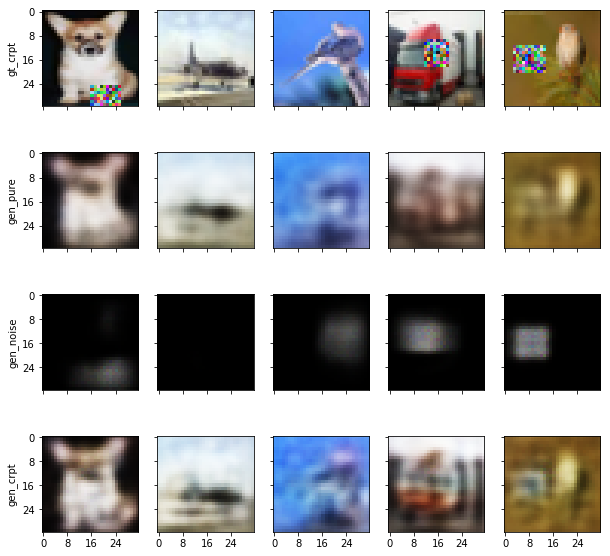

In [12]:
test_disp_idx = np.random.randint(FLAGS.img_num, size=n_plot)
test_gt_pure = np.copy(np.take(cifar10_test_img, test_disp_idx, axis=0))    # (n_plot, 3072) fixed
test_gt_noise = noise_batch(5)    # random noise
test_gt_crpt = occl(test_gt_pure,test_gt_noise)   # corrupted image
test_gt_feeds = {ph_crpt: test_gt_crpt}
test_gen_pure, test_gen_noise, test_gen_crpt = sess.run([core_gen, shell2_gen, full_gen], \
                                                        feed_dict=test_gt_feeds)

# plotting results from testing data
fig, axes = plt.subplots(nrows=4, ncols=n_plot, figsize=(10,2*n_plot))   # displaying 4*n_plot images
plt.setp(axes, xticks=np.arange(0,31,8), yticks=np.arange(0,31,8)) 
for k in range(n_plot):
    test_disp_gt_crpt = np.reshape(test_gt_crpt[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
    axes[0, k].imshow(test_disp_gt_crpt)   
    axes[0, k].set(ylabel='gt_crpt')
    axes[0, k].label_outer()

    test_disp_gen_pure = np.reshape(test_gen_pure[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
    axes[1, k].imshow(test_disp_gen_pure)   
    axes[1, k].set(ylabel='gen_pure')
    axes[1, k].label_outer()           

    test_disp_gen_noise = np.reshape(test_gen_noise[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
    axes[2, k].imshow(test_disp_gen_noise)   
    axes[2, k].set(ylabel='gen_noise')
    axes[2, k].label_outer()

    test_disp_gen_crpt = np.reshape(test_gen_crpt[k], [FLAGS.img_size,FLAGS.img_size, 3])    # 28x28
    axes[3, k].imshow(test_disp_gen_crpt)   
    axes[3, k].set(ylabel='gen_crpt')
    axes[3, k].label_outer()
